In [7]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, LSTM, Masking, Input, GRU, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from tensorflow.keras import regularizers
from sklearn.utils import shuffle
from qkeras import *
import qkeras
from tensorflow.keras.models import load_model
from qkeras.utils import model_quantize
from qkeras.utils import model_save_quantized_weights

In [3]:
file_path = "./Jan06_FlavFix_smear_1_std_xtd_zst.h5"
f5 = h5py.File(file_path, 'r')

In [4]:
x_train = np.array( f5['x_train'] )
y_train = to_categorical ( np.array( f5['y_train'] ) )
w_train = np.array( f5['w_train'] )

(array([[400610.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0., 300906.],
        [601755.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0.,  99761.],
        [400667.,      0.,      0.,      0.,      0.,      0.,      0.,
              0.,      0., 300849.]]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <a list of 3 BarContainer objects>)

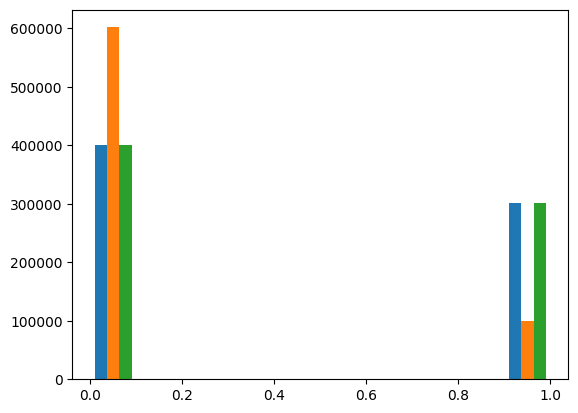

In [5]:
plt.hist(y_train[:])

In [6]:
x_test = np.array( f5['x_test'] )
y_test = to_categorical ( np.array( f5['y_test'] ) )

### Shuffle training data

In [5]:
x_train, y_train, w_train = shuffle(x_train, y_train, w_train)

In [6]:
print("x-shape: ", x_train.shape)
print("y-shape: ", y_train.shape)
print("w-shape: ", w_train.shape)

x-shape:  (701516, 15, 6)
y-shape:  (701516, 3)
w-shape:  (701516,)


### GRU

In [29]:
def grumodel(max_len, n_var, rec_units, ndense=[50, 10], l1_reg=0,
              l2_reg=0, rec_act='sigmoid', extra_lab='none', rec_kernel_init='VarianceScaling',
             dense_kernel_init='lecun_uniform'):
    
    hidden = x_in = Input(shape=(max_len, n_var,))
    hidden = GRU(units=rec_units,
                  recurrent_activation = rec_act,
                  kernel_initializer = rec_kernel_init, 
                  name = 'gru')(hidden)
    
    hidden = Dense(50, kernel_initializer=dense_kernel_init, name='dense_0' )(hidden)
    hidden = Activation('relu', name = 'relu_0')(hidden)
    
    hidden = Dense(10, kernel_initializer=dense_kernel_init, name='dense_1' )(hidden)
    hidden = Activation('relu', name = 'relu_1')(hidden)

    hidden = Dense(3, kernel_initializer=dense_kernel_init, name = 'dense_2')(hidden)
    hidden = Activation('softmax', name = 'output_softmax')(hidden)
    
    model = Model(inputs=x_in, outputs=hidden)
    
    return model

### LSTM

In [7]:
def lstmmodel(max_len, n_var, rec_units, ndense=[10], l1_reg=0,
              l2_reg=0, rec_act='sigmoid', extra_lab='none', rec_kernel_init='VarianceScaling',
             dense_kernel_init='lecun_uniform', domask=False):
    
    hidden = x_in = Input(shape=(max_len, n_var,))
    hidden = LSTM(units=rec_units,
                  recurrent_activation = rec_act,
                  kernel_initializer = rec_kernel_init, 
                  name = 'lstm1')(hidden)
    hidden = Dense(50, kernel_initializer=dense_kernel_init, name='dense_0' )(hidden)
    hidden = Activation('relu', name = 'relu_0')(hidden)
    hidden = Dense(10, kernel_initializer=dense_kernel_init, name='dense_1' )(hidden)
    hidden = Activation('relu', name = 'relu_1')(hidden)
    hidden = Dense(3, kernel_initializer=dense_kernel_init, name='dense_2' )(hidden)
    hidden = Activation('softmax', name='output_softmax')(hidden)
    model = Model(inputs=x_in, outputs=hidden)
    
    return model

## Floating Point Model Training

In [30]:
l1_reg = 0
l2_reg = 0

## GRU Model
model = grumodel(15, 6, 120, [50, 10], l1_reg=l1_reg, l2_reg=l2_reg)

## LSTM Model
#model = lstmmodel(15, 6, 120, [50, 10], l1_reg=l1_reg, l2_reg=l2_reg)

model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])
    
model_output = 'gru_test3/gru_weights.h5'

train = True
if train:
    history = model.fit(x_train, y_train,
            batch_size=2**14,
            epochs=150,
            validation_split=0.1,
            shuffle = True,
            sample_weight= w_train,
            callbacks = [
                EarlyStopping(verbose=True, patience=20, monitor='val_accuracy'),
                ModelCheckpoint(model_output, monitor='val_accuracy', verbose=True, save_best_only=True)
                ],
            verbose=True
            )
y_keras = model.predict(x_test, batch_size=2**10)
auc_score = roc_auc_score(y_test, y_keras)
print("AUC score:", auc_score)

Epoch 1/150
39/39 [==============================] - ETA: 0s - loss: 0.9701 - accuracy: 0.5299WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 1: val_accuracy improved from -inf to 0.61866, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 24s 568ms/step - loss: 0.9701 - accuracy: 0.5299 - val_loss: 0.8841 - val_accuracy: 0.6187
Epoch 2/150
39/39 [==============================] - ETA: 0s - loss: 0.8377 - accuracy: 0.6480WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 2: val_accuracy improved from 0.61866 to 0.66759, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 33ms/step - loss: 0.8377 - accuracy: 0.6480 - val_loss: 0.8037 - val_accuracy: 0.6676
Epoch 3/150
37/39 [===========================>..] - ETA: 0s - loss: 0.7889 - accuracy: 0.6744WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 3: val_accuracy improved from 0.66759 to 0.68449, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 33ms/step - loss: 0.7885 - accuracy: 0.6746 - val_loss: 0.7748 - val_accuracy: 0.6845
Epoch 4/150
37/39 [===========================>..] - ETA: 0s - loss: 0.7694 - accuracy: 0.6849WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 4: val_accuracy improved from 0.68449 to 0.68963, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 32ms/step - loss: 0.7691 - accuracy: 0.6850 - val_loss: 0.7638 - val_accuracy: 0.6896
Epoch 5/150
37/39 [===========================>..] - ETA: 0s - loss: 0.7590 - accuracy: 0.6902WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 5: val_accuracy improved from 0.68963 to 0.69335, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 32ms/step - loss: 0.7586 - accuracy: 0.6904 - val_loss: 0.7551 - val_accuracy: 0.6934
Epoch 6/150
37/39 [===========================>..] - ETA: 0s - loss: 0.7515 - accuracy: 0.6940WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 6: val_accuracy improved from 0.69335 to 0.69548, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 31ms/step - loss: 0.7517 - accuracy: 0.6940 - val_loss: 0.7512 - val_accuracy: 0.6955
Epoch 7/150
37/39 [===========================>..] - ETA: 0s - loss: 0.7456 - accuracy: 0.6964WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 7: val_accuracy improved from 0.69548 to 0.69818, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 32ms/step - loss: 0.7457 - accuracy: 0.6964 - val_loss: 0.7443 - val_accuracy: 0.6982
Epoch 8/150
37/39 [===========================>..] - ETA: 0s - loss: 0.7407 - accuracy: 0.6988WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 8: val_accuracy improved from 0.69818 to 0.70021, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 32ms/step - loss: 0.7406 - accuracy: 0.6989 - val_loss: 0.7405 - val_accuracy: 0.7002
Epoch 9/150
37/39 [===========================>..] - ETA: 0s - loss: 0.7370 - accuracy: 0.7008WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 9: val_accuracy improved from 0.70021 to 0.70247, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 33ms/step - loss: 0.7372 - accuracy: 0.7007 - val_loss: 0.7374 - val_accuracy: 0.7025
Epoch 10/150
37/39 [===========================>..] - ETA: 0s - loss: 0.7344 - accuracy: 0.7021WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 10: val_accuracy improved from 0.70247 to 0.70357, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 33ms/step - loss: 0.7340 - accuracy: 0.7024 - val_loss: 0.7340 - val_accuracy: 0.7036
Epoch 11/150
37/39 [===========================>..] - ETA: 0s - loss: 0.7300 - accuracy: 0.7044WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 11: val_accuracy improved from 0.70357 to 0.70535, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 32ms/step - loss: 0.7302 - accuracy: 0.7043 - val_loss: 0.7313 - val_accuracy: 0.7054
Epoch 12/150
37/39 [===========================>..] - ETA: 0s - loss: 0.7278 - accuracy: 0.7057WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 12: val_accuracy improved from 0.70535 to 0.70712, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 32ms/step - loss: 0.7277 - accuracy: 0.7057 - val_loss: 0.7289 - val_accuracy: 0.7071
Epoch 13/150
37/39 [===========================>..] - ETA: 0s - loss: 0.7252 - accuracy: 0.7067WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 13: val_accuracy did not improve from 0.70712
39/39 [==============================] - 1s 31ms/step - loss: 0.7252 - accuracy: 0.7068 - val_loss: 0.7300 - val_accuracy: 0.7047
Epoch 14/150
37/39 [===========================>..] - ETA: 0s - loss: 0.7235 - accuracy: 0.7078WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 14: val_accuracy improved from 0.70712 to 0.70842, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 32ms/step - loss: 0.7234 - accuracy: 0.7079 - val_loss: 0.7252 - val_accuracy: 0.7084
Epoch 15/150
37/39 [===========================>..] - ETA: 0s - loss: 0.7207 - accuracy: 0.7092WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 15: val_accuracy did not improve from 0.70842
39/39 [==============================] - 1s 31ms/step - loss: 0.7208 - accuracy: 0.7092 - val_loss: 0.7268 - val_accuracy: 0.7059
Epoch 16/150
39/39 [==============================] - ETA: 0s - loss: 0.7195 - accuracy: 0.7100WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 16: val_accuracy improved from 0.70842 to 0.70862, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 33ms/step - loss: 0.7195 - accuracy: 0.7100 - val_loss: 0.7240 - val_accuracy: 0.7086
Epoch 17/150
37/39 [===========================>..] - ETA: 0s - loss: 0.7177 - accuracy: 0.7106WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 17: val_accuracy improved from 0.70862 to 0.71044, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 33ms/step - loss: 0.7174 - accuracy: 0.7108 - val_loss: 0.7205 - val_accuracy: 0.7104
Epoch 18/150
37/39 [===========================>..] - ETA: 0s - loss: 0.7156 - accuracy: 0.7118WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 18: val_accuracy did not improve from 0.71044
39/39 [==============================] - 1s 31ms/step - loss: 0.7156 - accuracy: 0.7118 - val_loss: 0.7197 - val_accuracy: 0.7104
Epoch 19/150
37/39 [===========================>..] - ETA: 0s - loss: 0.7142 - accuracy: 0.7124WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 19: val_accuracy improved from 0.71044 to 0.71116, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 32ms/step - loss: 0.7140 - accuracy: 0.7125 - val_loss: 0.7175 - val_accuracy: 0.7112
Epoch 20/150
37/39 [===========================>..] - ETA: 0s - loss: 0.7122 - accuracy: 0.7134WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 20: val_accuracy improved from 0.71116 to 0.71195, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 32ms/step - loss: 0.7122 - accuracy: 0.7134 - val_loss: 0.7163 - val_accuracy: 0.7120
Epoch 21/150
37/39 [===========================>..] - ETA: 0s - loss: 0.7113 - accuracy: 0.7137WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 21: val_accuracy did not improve from 0.71195
39/39 [==============================] - 1s 31ms/step - loss: 0.7110 - accuracy: 0.7139 - val_loss: 0.7169 - val_accuracy: 0.7116
Epoch 22/150
37/39 [===========================>..] - ETA: 0s - loss: 0.7097 - accuracy: 0.7144WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 22: val_accuracy improved from 0.71195 to 0.71331, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 32ms/step - loss: 0.7096 - accuracy: 0.7144 - val_loss: 0.7140 - val_accuracy: 0.7133
Epoch 23/150
37/39 [===========================>..] - ETA: 0s - loss: 0.7089 - accuracy: 0.7147WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 23: val_accuracy did not improve from 0.71331
39/39 [==============================] - 1s 32ms/step - loss: 0.7088 - accuracy: 0.7148 - val_loss: 0.7129 - val_accuracy: 0.7131
Epoch 24/150
37/39 [===========================>..] - ETA: 0s - loss: 0.7074 - accuracy: 0.7154WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 24: val_accuracy improved from 0.71331 to 0.71423, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 33ms/step - loss: 0.7073 - accuracy: 0.7154 - val_loss: 0.7123 - val_accuracy: 0.7142
Epoch 25/150
37/39 [===========================>..] - ETA: 0s - loss: 0.7057 - accuracy: 0.7163WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 25: val_accuracy improved from 0.71423 to 0.71496, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 32ms/step - loss: 0.7058 - accuracy: 0.7161 - val_loss: 0.7109 - val_accuracy: 0.7150
Epoch 26/150
37/39 [===========================>..] - ETA: 0s - loss: 0.7048 - accuracy: 0.7169WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 26: val_accuracy improved from 0.71496 to 0.71518, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 33ms/step - loss: 0.7047 - accuracy: 0.7169 - val_loss: 0.7098 - val_accuracy: 0.7152
Epoch 27/150
37/39 [===========================>..] - ETA: 0s - loss: 0.7036 - accuracy: 0.7173WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 27: val_accuracy improved from 0.71518 to 0.71610, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 32ms/step - loss: 0.7035 - accuracy: 0.7173 - val_loss: 0.7090 - val_accuracy: 0.7161
Epoch 28/150
37/39 [===========================>..] - ETA: 0s - loss: 0.7031 - accuracy: 0.7175WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 28: val_accuracy did not improve from 0.71610
39/39 [==============================] - 1s 31ms/step - loss: 0.7029 - accuracy: 0.7176 - val_loss: 0.7080 - val_accuracy: 0.7156
Epoch 29/150
37/39 [===========================>..] - ETA: 0s - loss: 0.7014 - accuracy: 0.7183WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 29: val_accuracy improved from 0.71610 to 0.71634, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 32ms/step - loss: 0.7015 - accuracy: 0.7182 - val_loss: 0.7071 - val_accuracy: 0.7163
Epoch 30/150
39/39 [==============================] - ETA: 0s - loss: 0.7006 - accuracy: 0.7186WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 30: val_accuracy did not improve from 0.71634
39/39 [==============================] - 1s 32ms/step - loss: 0.7006 - accuracy: 0.7186 - val_loss: 0.7064 - val_accuracy: 0.7158
Epoch 31/150
39/39 [==============================] - ETA: 0s - loss: 0.6997 - accuracy: 0.7191WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 31: val_accuracy did not improve from 0.71634
39/39 [==============================] - 1s 32ms/step - loss: 0.6997 - accuracy: 0.7191 - val_loss: 0.7062 - val_accuracy: 0.7158
Epoch 32/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6987 - accuracy: 0.7194WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 32: val_accuracy improved from 0.71634 to 0.71643, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 32ms/step - loss: 0.6987 - accuracy: 0.7194 - val_loss: 0.7058 - val_accuracy: 0.7164
Epoch 33/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6980 - accuracy: 0.7197WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 33: val_accuracy did not improve from 0.71643
39/39 [==============================] - 1s 31ms/step - loss: 0.6980 - accuracy: 0.7196 - val_loss: 0.7053 - val_accuracy: 0.7164
Epoch 34/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6971 - accuracy: 0.7200WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 34: val_accuracy improved from 0.71643 to 0.71760, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 32ms/step - loss: 0.6974 - accuracy: 0.7199 - val_loss: 0.7044 - val_accuracy: 0.7176
Epoch 35/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6966 - accuracy: 0.7204WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 35: val_accuracy improved from 0.71760 to 0.71817, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 32ms/step - loss: 0.6967 - accuracy: 0.7204 - val_loss: 0.7035 - val_accuracy: 0.7182
Epoch 36/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6955 - accuracy: 0.7210WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 36: val_accuracy improved from 0.71817 to 0.71845, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 32ms/step - loss: 0.6956 - accuracy: 0.7208 - val_loss: 0.7026 - val_accuracy: 0.7185
Epoch 37/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6952 - accuracy: 0.7207WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 37: val_accuracy did not improve from 0.71845
39/39 [==============================] - 1s 32ms/step - loss: 0.6951 - accuracy: 0.7210 - val_loss: 0.7030 - val_accuracy: 0.7181
Epoch 38/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6949 - accuracy: 0.7209WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 38: val_accuracy did not improve from 0.71845
39/39 [==============================] - 1s 32ms/step - loss: 0.6948 - accuracy: 0.7210 - val_loss: 0.7020 - val_accuracy: 0.7179
Epoch 39/150
39/39 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.7218WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 39: val_accuracy improved from 0.71845 to 0.71911, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 33ms/step - loss: 0.6932 - accuracy: 0.7218 - val_loss: 0.7010 - val_accuracy: 0.7191
Epoch 40/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6925 - accuracy: 0.7218WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 40: val_accuracy improved from 0.71911 to 0.71992, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 32ms/step - loss: 0.6924 - accuracy: 0.7219 - val_loss: 0.7003 - val_accuracy: 0.7199
Epoch 41/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6917 - accuracy: 0.7223WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 41: val_accuracy did not improve from 0.71992
39/39 [==============================] - 1s 32ms/step - loss: 0.6916 - accuracy: 0.7224 - val_loss: 0.6998 - val_accuracy: 0.7194
Epoch 42/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6910 - accuracy: 0.7228WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 42: val_accuracy did not improve from 0.71992
39/39 [==============================] - 1s 32ms/step - loss: 0.6911 - accuracy: 0.7227 - val_loss: 0.6997 - val_accuracy: 0.7194
Epoch 43/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6904 - accuracy: 0.7228WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 43: val_accuracy did not improve from 0.71992
39/39 [==============================] - 1s 31ms/step - loss: 0.6905 - accuracy: 0.7229 - val_loss: 0.6992 - val_accuracy: 0.7195
Epoch 44/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6901 - accuracy: 0.7232WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 44: val_accuracy did not improve from 0.71992
39/39 [==============================] - 1s 32ms/step - loss: 0.6901 - accuracy: 0.7231 - val_loss: 0.6995 - val_accuracy: 0.7191
Epoch 45/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6893 - accuracy: 0.7233WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 45: val_accuracy improved from 0.71992 to 0.72024, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 33ms/step - loss: 0.6894 - accuracy: 0.7232 - val_loss: 0.6978 - val_accuracy: 0.7202
Epoch 46/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6885 - accuracy: 0.7241WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 46: val_accuracy did not improve from 0.72024
39/39 [==============================] - 1s 31ms/step - loss: 0.6888 - accuracy: 0.7239 - val_loss: 0.6998 - val_accuracy: 0.7196
Epoch 47/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6882 - accuracy: 0.7238WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 47: val_accuracy did not improve from 0.72024
39/39 [==============================] - 1s 31ms/step - loss: 0.6885 - accuracy: 0.7237 - val_loss: 0.7008 - val_accuracy: 0.7189
Epoch 48/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6878 - accuracy: 0.7242WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 48: val_accuracy improved from 0.72024 to 0.72056, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 32ms/step - loss: 0.6879 - accuracy: 0.7241 - val_loss: 0.6973 - val_accuracy: 0.7206
Epoch 49/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6874 - accuracy: 0.7245WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 49: val_accuracy improved from 0.72056 to 0.72123, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 32ms/step - loss: 0.6873 - accuracy: 0.7245 - val_loss: 0.6967 - val_accuracy: 0.7212
Epoch 50/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6861 - accuracy: 0.7250WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 50: val_accuracy did not improve from 0.72123
39/39 [==============================] - 1s 31ms/step - loss: 0.6862 - accuracy: 0.7250 - val_loss: 0.6982 - val_accuracy: 0.7200
Epoch 51/150
39/39 [==============================] - ETA: 0s - loss: 0.6862 - accuracy: 0.7249WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 51: val_accuracy did not improve from 0.72123
39/39 [==============================] - 1s 32ms/step - loss: 0.6862 - accuracy: 0.7249 - val_loss: 0.6971 - val_accuracy: 0.7211
Epoch 52/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6863 - accuracy: 0.7245WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 52: val_accuracy improved from 0.72123 to 0.72128, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 33ms/step - loss: 0.6862 - accuracy: 0.7247 - val_loss: 0.6960 - val_accuracy: 0.7213
Epoch 53/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6843 - accuracy: 0.7257WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 53: val_accuracy improved from 0.72128 to 0.72156, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 32ms/step - loss: 0.6847 - accuracy: 0.7255 - val_loss: 0.6954 - val_accuracy: 0.7216
Epoch 54/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6839 - accuracy: 0.7258WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 54: val_accuracy improved from 0.72156 to 0.72185, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 32ms/step - loss: 0.6842 - accuracy: 0.7257 - val_loss: 0.6952 - val_accuracy: 0.7218
Epoch 55/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6838 - accuracy: 0.7262WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 55: val_accuracy did not improve from 0.72185
39/39 [==============================] - 1s 31ms/step - loss: 0.6839 - accuracy: 0.7261 - val_loss: 0.6954 - val_accuracy: 0.7215
Epoch 56/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6838 - accuracy: 0.7257WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 56: val_accuracy did not improve from 0.72185
39/39 [==============================] - 1s 31ms/step - loss: 0.6836 - accuracy: 0.7259 - val_loss: 0.6943 - val_accuracy: 0.7216
Epoch 57/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6824 - accuracy: 0.7265WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 57: val_accuracy improved from 0.72185 to 0.72227, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 33ms/step - loss: 0.6824 - accuracy: 0.7265 - val_loss: 0.6944 - val_accuracy: 0.7223
Epoch 58/150
39/39 [==============================] - ETA: 0s - loss: 0.6828 - accuracy: 0.7264WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 58: val_accuracy did not improve from 0.72227
39/39 [==============================] - 1s 32ms/step - loss: 0.6828 - accuracy: 0.7264 - val_loss: 0.6942 - val_accuracy: 0.7219
Epoch 59/150
39/39 [==============================] - ETA: 0s - loss: 0.6822 - accuracy: 0.7264WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 59: val_accuracy improved from 0.72227 to 0.72246, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 33ms/step - loss: 0.6822 - accuracy: 0.7264 - val_loss: 0.6943 - val_accuracy: 0.7225
Epoch 60/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6810 - accuracy: 0.7272WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 60: val_accuracy did not improve from 0.72246
39/39 [==============================] - 1s 32ms/step - loss: 0.6809 - accuracy: 0.7272 - val_loss: 0.6941 - val_accuracy: 0.7219
Epoch 61/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6808 - accuracy: 0.7272WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 61: val_accuracy did not improve from 0.72246
39/39 [==============================] - 1s 31ms/step - loss: 0.6808 - accuracy: 0.7272 - val_loss: 0.6943 - val_accuracy: 0.7222
Epoch 62/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6808 - accuracy: 0.7272WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 62: val_accuracy did not improve from 0.72246
39/39 [==============================] - 1s 31ms/step - loss: 0.6805 - accuracy: 0.7273 - val_loss: 0.6940 - val_accuracy: 0.7223
Epoch 63/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6804 - accuracy: 0.7273WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 63: val_accuracy improved from 0.72246 to 0.72293, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 32ms/step - loss: 0.6802 - accuracy: 0.7275 - val_loss: 0.6936 - val_accuracy: 0.7229
Epoch 64/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6794 - accuracy: 0.7277WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 64: val_accuracy did not improve from 0.72293
39/39 [==============================] - 1s 31ms/step - loss: 0.6795 - accuracy: 0.7276 - val_loss: 0.6931 - val_accuracy: 0.7229
Epoch 65/150
39/39 [==============================] - ETA: 0s - loss: 0.6788 - accuracy: 0.7280WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 65: val_accuracy improved from 0.72293 to 0.72294, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 33ms/step - loss: 0.6788 - accuracy: 0.7280 - val_loss: 0.6937 - val_accuracy: 0.7229
Epoch 66/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6785 - accuracy: 0.7282WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 66: val_accuracy improved from 0.72294 to 0.72312, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 33ms/step - loss: 0.6786 - accuracy: 0.7282 - val_loss: 0.6927 - val_accuracy: 0.7231
Epoch 67/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6778 - accuracy: 0.7285WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 67: val_accuracy improved from 0.72312 to 0.72364, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 33ms/step - loss: 0.6780 - accuracy: 0.7285 - val_loss: 0.6923 - val_accuracy: 0.7236
Epoch 68/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6778 - accuracy: 0.7285WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 68: val_accuracy did not improve from 0.72364
39/39 [==============================] - 1s 31ms/step - loss: 0.6777 - accuracy: 0.7286 - val_loss: 0.6926 - val_accuracy: 0.7235
Epoch 69/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6770 - accuracy: 0.7286WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 69: val_accuracy did not improve from 0.72364
39/39 [==============================] - 1s 32ms/step - loss: 0.6771 - accuracy: 0.7286 - val_loss: 0.6922 - val_accuracy: 0.7233
Epoch 70/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6767 - accuracy: 0.7289WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 70: val_accuracy did not improve from 0.72364
39/39 [==============================] - 1s 31ms/step - loss: 0.6768 - accuracy: 0.7289 - val_loss: 0.6934 - val_accuracy: 0.7228
Epoch 71/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6769 - accuracy: 0.7288WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 71: val_accuracy did not improve from 0.72364
39/39 [==============================] - 1s 31ms/step - loss: 0.6769 - accuracy: 0.7288 - val_loss: 0.6923 - val_accuracy: 0.7236
Epoch 72/150
39/39 [==============================] - ETA: 0s - loss: 0.6770 - accuracy: 0.7288WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 72: val_accuracy improved from 0.72364 to 0.72414, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 33ms/step - loss: 0.6770 - accuracy: 0.7288 - val_loss: 0.6916 - val_accuracy: 0.7241
Epoch 73/150
39/39 [==============================] - ETA: 0s - loss: 0.6758 - accuracy: 0.7293WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 73: val_accuracy did not improve from 0.72414
39/39 [==============================] - 1s 33ms/step - loss: 0.6758 - accuracy: 0.7293 - val_loss: 0.6921 - val_accuracy: 0.7239
Epoch 74/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6759 - accuracy: 0.7294WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 74: val_accuracy did not improve from 0.72414
39/39 [==============================] - 1s 31ms/step - loss: 0.6759 - accuracy: 0.7294 - val_loss: 0.6920 - val_accuracy: 0.7237
Epoch 75/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6749 - accuracy: 0.7297WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 75: val_accuracy did not improve from 0.72414
39/39 [==============================] - 1s 31ms/step - loss: 0.6748 - accuracy: 0.7298 - val_loss: 0.6928 - val_accuracy: 0.7240
Epoch 76/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6747 - accuracy: 0.7299WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 76: val_accuracy did not improve from 0.72414
39/39 [==============================] - 1s 31ms/step - loss: 0.6747 - accuracy: 0.7298 - val_loss: 0.6917 - val_accuracy: 0.7233
Epoch 77/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6741 - accuracy: 0.7302WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 77: val_accuracy improved from 0.72414 to 0.72443, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 32ms/step - loss: 0.6744 - accuracy: 0.7300 - val_loss: 0.6911 - val_accuracy: 0.7244
Epoch 78/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6737 - accuracy: 0.7302WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 78: val_accuracy improved from 0.72443 to 0.72444, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 33ms/step - loss: 0.6737 - accuracy: 0.7302 - val_loss: 0.6904 - val_accuracy: 0.7244
Epoch 79/150
39/39 [==============================] - ETA: 0s - loss: 0.6732 - accuracy: 0.7306WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 79: val_accuracy did not improve from 0.72444
39/39 [==============================] - 1s 32ms/step - loss: 0.6732 - accuracy: 0.7306 - val_loss: 0.6906 - val_accuracy: 0.7242
Epoch 80/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6732 - accuracy: 0.7307WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 80: val_accuracy did not improve from 0.72444
39/39 [==============================] - 1s 32ms/step - loss: 0.6731 - accuracy: 0.7307 - val_loss: 0.6921 - val_accuracy: 0.7239
Epoch 81/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6729 - accuracy: 0.7308WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 81: val_accuracy improved from 0.72444 to 0.72508, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 33ms/step - loss: 0.6728 - accuracy: 0.7308 - val_loss: 0.6900 - val_accuracy: 0.7251
Epoch 82/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6725 - accuracy: 0.7309WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 82: val_accuracy did not improve from 0.72508
39/39 [==============================] - 1s 31ms/step - loss: 0.6724 - accuracy: 0.7309 - val_loss: 0.6908 - val_accuracy: 0.7244
Epoch 83/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6718 - accuracy: 0.7311WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 83: val_accuracy did not improve from 0.72508
39/39 [==============================] - 1s 31ms/step - loss: 0.6719 - accuracy: 0.7311 - val_loss: 0.6914 - val_accuracy: 0.7232
Epoch 84/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6715 - accuracy: 0.7315WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 84: val_accuracy did not improve from 0.72508
39/39 [==============================] - 1s 31ms/step - loss: 0.6718 - accuracy: 0.7312 - val_loss: 0.6898 - val_accuracy: 0.7243
Epoch 85/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6711 - accuracy: 0.7316WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 85: val_accuracy did not improve from 0.72508
39/39 [==============================] - 1s 31ms/step - loss: 0.6712 - accuracy: 0.7315 - val_loss: 0.6904 - val_accuracy: 0.7246
Epoch 86/150
39/39 [==============================] - ETA: 0s - loss: 0.6707 - accuracy: 0.7315WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 86: val_accuracy did not improve from 0.72508
39/39 [==============================] - 1s 32ms/step - loss: 0.6707 - accuracy: 0.7315 - val_loss: 0.6903 - val_accuracy: 0.7239
Epoch 87/150
39/39 [==============================] - ETA: 0s - loss: 0.6705 - accuracy: 0.7315WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 87: val_accuracy did not improve from 0.72508
39/39 [==============================] - 1s 33ms/step - loss: 0.6705 - accuracy: 0.7315 - val_loss: 0.6904 - val_accuracy: 0.7238
Epoch 88/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6698 - accuracy: 0.7319WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 88: val_accuracy did not improve from 0.72508
39/39 [==============================] - 1s 31ms/step - loss: 0.6700 - accuracy: 0.7318 - val_loss: 0.6901 - val_accuracy: 0.7241
Epoch 89/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6697 - accuracy: 0.7320WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 89: val_accuracy did not improve from 0.72508
39/39 [==============================] - 1s 32ms/step - loss: 0.6698 - accuracy: 0.7321 - val_loss: 0.6897 - val_accuracy: 0.7242
Epoch 90/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6687 - accuracy: 0.7328WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 90: val_accuracy did not improve from 0.72508
39/39 [==============================] - 1s 32ms/step - loss: 0.6690 - accuracy: 0.7326 - val_loss: 0.6897 - val_accuracy: 0.7239
Epoch 91/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6695 - accuracy: 0.7320WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 91: val_accuracy improved from 0.72508 to 0.72523, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 34ms/step - loss: 0.6695 - accuracy: 0.7321 - val_loss: 0.6899 - val_accuracy: 0.7252
Epoch 92/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6689 - accuracy: 0.7324WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 92: val_accuracy did not improve from 0.72523
39/39 [==============================] - 1s 32ms/step - loss: 0.6689 - accuracy: 0.7324 - val_loss: 0.6904 - val_accuracy: 0.7246
Epoch 93/150
39/39 [==============================] - ETA: 0s - loss: 0.6686 - accuracy: 0.7325WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 93: val_accuracy did not improve from 0.72523
39/39 [==============================] - 1s 33ms/step - loss: 0.6686 - accuracy: 0.7325 - val_loss: 0.6895 - val_accuracy: 0.7246
Epoch 94/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6677 - accuracy: 0.7329WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 94: val_accuracy did not improve from 0.72523
39/39 [==============================] - 1s 32ms/step - loss: 0.6678 - accuracy: 0.7328 - val_loss: 0.6899 - val_accuracy: 0.7250
Epoch 95/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6679 - accuracy: 0.7332WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 95: val_accuracy did not improve from 0.72523
39/39 [==============================] - 1s 31ms/step - loss: 0.6677 - accuracy: 0.7332 - val_loss: 0.6897 - val_accuracy: 0.7241
Epoch 96/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6676 - accuracy: 0.7328WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 96: val_accuracy did not improve from 0.72523
39/39 [==============================] - 1s 31ms/step - loss: 0.6674 - accuracy: 0.7330 - val_loss: 0.6894 - val_accuracy: 0.7249
Epoch 97/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6668 - accuracy: 0.7331WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 97: val_accuracy did not improve from 0.72523
39/39 [==============================] - 1s 31ms/step - loss: 0.6668 - accuracy: 0.7332 - val_loss: 0.6906 - val_accuracy: 0.7243
Epoch 98/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6672 - accuracy: 0.7333WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 98: val_accuracy did not improve from 0.72523
39/39 [==============================] - 1s 31ms/step - loss: 0.6670 - accuracy: 0.7333 - val_loss: 0.6891 - val_accuracy: 0.7244
Epoch 99/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6661 - accuracy: 0.7337WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 99: val_accuracy did not improve from 0.72523
39/39 [==============================] - 1s 31ms/step - loss: 0.6663 - accuracy: 0.7336 - val_loss: 0.6890 - val_accuracy: 0.7249
Epoch 100/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6658 - accuracy: 0.7337WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 100: val_accuracy did not improve from 0.72523
39/39 [==============================] - 1s 32ms/step - loss: 0.6660 - accuracy: 0.7335 - val_loss: 0.6892 - val_accuracy: 0.7250
Epoch 101/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6657 - accuracy: 0.7338WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 101: val_accuracy improved from 0.72523 to 0.72577, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 33ms/step - loss: 0.6658 - accuracy: 0.7338 - val_loss: 0.6891 - val_accuracy: 0.7258
Epoch 102/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6650 - accuracy: 0.7340WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 102: val_accuracy did not improve from 0.72577
39/39 [==============================] - 1s 31ms/step - loss: 0.6651 - accuracy: 0.7340 - val_loss: 0.6897 - val_accuracy: 0.7246
Epoch 103/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6646 - accuracy: 0.7341WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 103: val_accuracy did not improve from 0.72577
39/39 [==============================] - 1s 31ms/step - loss: 0.6646 - accuracy: 0.7341 - val_loss: 0.6893 - val_accuracy: 0.7250
Epoch 104/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6638 - accuracy: 0.7348WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 104: val_accuracy did not improve from 0.72577
39/39 [==============================] - 1s 31ms/step - loss: 0.6643 - accuracy: 0.7346 - val_loss: 0.6892 - val_accuracy: 0.7252
Epoch 105/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6642 - accuracy: 0.7345WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 105: val_accuracy did not improve from 0.72577
39/39 [==============================] - 1s 32ms/step - loss: 0.6643 - accuracy: 0.7344 - val_loss: 0.6907 - val_accuracy: 0.7250
Epoch 106/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6638 - accuracy: 0.7345WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 106: val_accuracy did not improve from 0.72577
39/39 [==============================] - 1s 31ms/step - loss: 0.6641 - accuracy: 0.7344 - val_loss: 0.6904 - val_accuracy: 0.7241
Epoch 107/150
39/39 [==============================] - ETA: 0s - loss: 0.6639 - accuracy: 0.7346WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 107: val_accuracy did not improve from 0.72577
39/39 [==============================] - 1s 33ms/step - loss: 0.6639 - accuracy: 0.7346 - val_loss: 0.6895 - val_accuracy: 0.7251
Epoch 108/150
39/39 [==============================] - ETA: 0s - loss: 0.6641 - accuracy: 0.7343WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 108: val_accuracy did not improve from 0.72577
39/39 [==============================] - 1s 32ms/step - loss: 0.6641 - accuracy: 0.7343 - val_loss: 0.6897 - val_accuracy: 0.7256
Epoch 109/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6627 - accuracy: 0.7352WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 109: val_accuracy improved from 0.72577 to 0.72590, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 33ms/step - loss: 0.6630 - accuracy: 0.7350 - val_loss: 0.6891 - val_accuracy: 0.7259
Epoch 110/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6624 - accuracy: 0.7352WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 110: val_accuracy did not improve from 0.72590
39/39 [==============================] - 1s 31ms/step - loss: 0.6627 - accuracy: 0.7349 - val_loss: 0.6900 - val_accuracy: 0.7252
Epoch 111/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6630 - accuracy: 0.7347WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 111: val_accuracy improved from 0.72590 to 0.72614, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 32ms/step - loss: 0.6632 - accuracy: 0.7346 - val_loss: 0.6887 - val_accuracy: 0.7261
Epoch 112/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6626 - accuracy: 0.7349WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 112: val_accuracy did not improve from 0.72614
39/39 [==============================] - 1s 31ms/step - loss: 0.6626 - accuracy: 0.7350 - val_loss: 0.6901 - val_accuracy: 0.7250
Epoch 113/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6619 - accuracy: 0.7352WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 113: val_accuracy did not improve from 0.72614
39/39 [==============================] - 1s 31ms/step - loss: 0.6620 - accuracy: 0.7351 - val_loss: 0.6898 - val_accuracy: 0.7260
Epoch 114/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6617 - accuracy: 0.7355WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 114: val_accuracy did not improve from 0.72614
39/39 [==============================] - 1s 33ms/step - loss: 0.6618 - accuracy: 0.7355 - val_loss: 0.6889 - val_accuracy: 0.7254
Epoch 115/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6615 - accuracy: 0.7354WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 115: val_accuracy did not improve from 0.72614
39/39 [==============================] - 1s 32ms/step - loss: 0.6611 - accuracy: 0.7355 - val_loss: 0.6897 - val_accuracy: 0.7259
Epoch 116/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6608 - accuracy: 0.7357WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 116: val_accuracy did not improve from 0.72614
39/39 [==============================] - 1s 31ms/step - loss: 0.6609 - accuracy: 0.7357 - val_loss: 0.6890 - val_accuracy: 0.7252
Epoch 117/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6608 - accuracy: 0.7356WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 117: val_accuracy did not improve from 0.72614
39/39 [==============================] - 1s 31ms/step - loss: 0.6609 - accuracy: 0.7357 - val_loss: 0.6887 - val_accuracy: 0.7256
Epoch 118/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6600 - accuracy: 0.7360WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 118: val_accuracy did not improve from 0.72614
39/39 [==============================] - 1s 32ms/step - loss: 0.6601 - accuracy: 0.7360 - val_loss: 0.6889 - val_accuracy: 0.7256
Epoch 119/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6598 - accuracy: 0.7360WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 119: val_accuracy did not improve from 0.72614
39/39 [==============================] - 1s 32ms/step - loss: 0.6599 - accuracy: 0.7359 - val_loss: 0.6898 - val_accuracy: 0.7256
Epoch 120/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6595 - accuracy: 0.7361WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 120: val_accuracy did not improve from 0.72614
39/39 [==============================] - 1s 31ms/step - loss: 0.6595 - accuracy: 0.7361 - val_loss: 0.6902 - val_accuracy: 0.7258
Epoch 121/150
39/39 [==============================] - ETA: 0s - loss: 0.6593 - accuracy: 0.7363WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 121: val_accuracy improved from 0.72614 to 0.72627, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 34ms/step - loss: 0.6593 - accuracy: 0.7363 - val_loss: 0.6891 - val_accuracy: 0.7263
Epoch 122/150
39/39 [==============================] - ETA: 0s - loss: 0.6593 - accuracy: 0.7363WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 122: val_accuracy did not improve from 0.72627
39/39 [==============================] - 1s 32ms/step - loss: 0.6593 - accuracy: 0.7363 - val_loss: 0.6890 - val_accuracy: 0.7252
Epoch 123/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6583 - accuracy: 0.7369WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 123: val_accuracy did not improve from 0.72627
39/39 [==============================] - 1s 31ms/step - loss: 0.6583 - accuracy: 0.7369 - val_loss: 0.6899 - val_accuracy: 0.7244
Epoch 124/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6580 - accuracy: 0.7367WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 124: val_accuracy did not improve from 0.72627
39/39 [==============================] - 1s 31ms/step - loss: 0.6580 - accuracy: 0.7369 - val_loss: 0.6918 - val_accuracy: 0.7253
Epoch 125/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6578 - accuracy: 0.7369WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 125: val_accuracy did not improve from 0.72627
39/39 [==============================] - 1s 31ms/step - loss: 0.6579 - accuracy: 0.7368 - val_loss: 0.6896 - val_accuracy: 0.7256
Epoch 126/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6580 - accuracy: 0.7369WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 126: val_accuracy did not improve from 0.72627
39/39 [==============================] - 1s 31ms/step - loss: 0.6579 - accuracy: 0.7370 - val_loss: 0.6897 - val_accuracy: 0.7256
Epoch 127/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6572 - accuracy: 0.7372WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 127: val_accuracy did not improve from 0.72627
39/39 [==============================] - 1s 31ms/step - loss: 0.6574 - accuracy: 0.7371 - val_loss: 0.6905 - val_accuracy: 0.7252
Epoch 128/150
39/39 [==============================] - ETA: 0s - loss: 0.6575 - accuracy: 0.7370WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 128: val_accuracy did not improve from 0.72627
39/39 [==============================] - 1s 33ms/step - loss: 0.6575 - accuracy: 0.7370 - val_loss: 0.6905 - val_accuracy: 0.7245
Epoch 129/150
39/39 [==============================] - ETA: 0s - loss: 0.6572 - accuracy: 0.7374WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 129: val_accuracy did not improve from 0.72627
39/39 [==============================] - 1s 32ms/step - loss: 0.6572 - accuracy: 0.7374 - val_loss: 0.6901 - val_accuracy: 0.7257
Epoch 130/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6567 - accuracy: 0.7372WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 130: val_accuracy did not improve from 0.72627
39/39 [==============================] - 1s 31ms/step - loss: 0.6566 - accuracy: 0.7374 - val_loss: 0.6899 - val_accuracy: 0.7257
Epoch 131/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6566 - accuracy: 0.7374WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 131: val_accuracy did not improve from 0.72627
39/39 [==============================] - 1s 31ms/step - loss: 0.6567 - accuracy: 0.7373 - val_loss: 0.6905 - val_accuracy: 0.7256
Epoch 132/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6559 - accuracy: 0.7378WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 132: val_accuracy did not improve from 0.72627
39/39 [==============================] - 1s 32ms/step - loss: 0.6558 - accuracy: 0.7378 - val_loss: 0.6893 - val_accuracy: 0.7256
Epoch 133/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6559 - accuracy: 0.7377WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 133: val_accuracy did not improve from 0.72627
39/39 [==============================] - 1s 31ms/step - loss: 0.6559 - accuracy: 0.7377 - val_loss: 0.6894 - val_accuracy: 0.7260
Epoch 134/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6548 - accuracy: 0.7383WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 134: val_accuracy did not improve from 0.72627
39/39 [==============================] - 1s 31ms/step - loss: 0.6553 - accuracy: 0.7381 - val_loss: 0.6936 - val_accuracy: 0.7243
Epoch 135/150
39/39 [==============================] - ETA: 0s - loss: 0.6555 - accuracy: 0.7379WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 135: val_accuracy did not improve from 0.72627
39/39 [==============================] - 1s 33ms/step - loss: 0.6555 - accuracy: 0.7379 - val_loss: 0.6907 - val_accuracy: 0.7249
Epoch 136/150
39/39 [==============================] - ETA: 0s - loss: 0.6547 - accuracy: 0.7381WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 136: val_accuracy did not improve from 0.72627
39/39 [==============================] - 1s 33ms/step - loss: 0.6547 - accuracy: 0.7381 - val_loss: 0.6908 - val_accuracy: 0.7251
Epoch 137/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6547 - accuracy: 0.7381WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 137: val_accuracy did not improve from 0.72627
39/39 [==============================] - 1s 32ms/step - loss: 0.6546 - accuracy: 0.7382 - val_loss: 0.6899 - val_accuracy: 0.7255
Epoch 138/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6543 - accuracy: 0.7385WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 138: val_accuracy did not improve from 0.72627
39/39 [==============================] - 1s 32ms/step - loss: 0.6543 - accuracy: 0.7384 - val_loss: 0.6916 - val_accuracy: 0.7247
Epoch 139/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6540 - accuracy: 0.7384WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 139: val_accuracy did not improve from 0.72627
39/39 [==============================] - 1s 31ms/step - loss: 0.6541 - accuracy: 0.7383 - val_loss: 0.6906 - val_accuracy: 0.7256
Epoch 140/150
39/39 [==============================] - ETA: 0s - loss: 0.6536 - accuracy: 0.7387WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 140: val_accuracy did not improve from 0.72627
39/39 [==============================] - 1s 32ms/step - loss: 0.6536 - accuracy: 0.7387 - val_loss: 0.6915 - val_accuracy: 0.7261
Epoch 141/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6528 - accuracy: 0.7390WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 141: val_accuracy improved from 0.72627 to 0.72631, saving model to gru_test3\gru_weights.h5
39/39 [==============================] - 1s 33ms/step - loss: 0.6531 - accuracy: 0.7389 - val_loss: 0.6909 - val_accuracy: 0.7263
Epoch 142/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6531 - accuracy: 0.7389WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 142: val_accuracy did not improve from 0.72631
39/39 [==============================] - 1s 33ms/step - loss: 0.6534 - accuracy: 0.7387 - val_loss: 0.6905 - val_accuracy: 0.7256
Epoch 143/150
39/39 [==============================] - ETA: 0s - loss: 0.6532 - accuracy: 0.7386WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 143: val_accuracy did not improve from 0.72631
39/39 [==============================] - 1s 33ms/step - loss: 0.6532 - accuracy: 0.7386 - val_loss: 0.6904 - val_accuracy: 0.7254
Epoch 144/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6526 - accuracy: 0.7392WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 144: val_accuracy did not improve from 0.72631
39/39 [==============================] - 1s 32ms/step - loss: 0.6526 - accuracy: 0.7392 - val_loss: 0.6910 - val_accuracy: 0.7262
Epoch 145/150
39/39 [==============================] - ETA: 0s - loss: 0.6527 - accuracy: 0.7390WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 145: val_accuracy did not improve from 0.72631
39/39 [==============================] - 1s 32ms/step - loss: 0.6527 - accuracy: 0.7390 - val_loss: 0.6911 - val_accuracy: 0.7256
Epoch 146/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6520 - accuracy: 0.7393WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 146: val_accuracy did not improve from 0.72631
39/39 [==============================] - 1s 32ms/step - loss: 0.6522 - accuracy: 0.7392 - val_loss: 0.6922 - val_accuracy: 0.7261
Epoch 147/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6514 - accuracy: 0.7395WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 147: val_accuracy did not improve from 0.72631
39/39 [==============================] - 1s 32ms/step - loss: 0.6517 - accuracy: 0.7393 - val_loss: 0.6915 - val_accuracy: 0.7253
Epoch 148/150
39/39 [==============================] - ETA: 0s - loss: 0.6513 - accuracy: 0.7395WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 148: val_accuracy did not improve from 0.72631
39/39 [==============================] - 1s 33ms/step - loss: 0.6513 - accuracy: 0.7395 - val_loss: 0.6913 - val_accuracy: 0.7257
Epoch 149/150
39/39 [==============================] - ETA: 0s - loss: 0.6511 - accuracy: 0.7396WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 149: val_accuracy did not improve from 0.72631
39/39 [==============================] - 1s 33ms/step - loss: 0.6511 - accuracy: 0.7396 - val_loss: 0.6913 - val_accuracy: 0.7262
Epoch 150/150
37/39 [===========================>..] - ETA: 0s - loss: 0.6506 - accuracy: 0.7397WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 150: val_accuracy did not improve from 0.72631
294/294 [==============================] - 1s 2ms/step
AUC score: 0.8154915881472825


## GRU weight

In [43]:
model = load_model("gru_test3/gru_weights.h5", custom_objects={'QGRU': QGRU, 'QDense': QDense, 'quantized_bits': quantized_bits, 'QActivation': QActivation})

for layer in model.layers:
    weights = layer.get_weights()
    print(layer.name, weights)

input_1 []
gru [array([[-0.12469812, -0.28928995,  0.24783108, ...,  0.09020978,
         1.3361043 ,  0.2131291 ],
       [ 0.1327692 , -0.08152957,  0.25204852, ...,  0.08305766,
        -0.40952712, -0.08306952],
       [-0.03643114,  0.05480863, -0.37831095, ...,  0.08108549,
        -0.20789394,  0.2881709 ],
       [-0.3405804 , -0.132991  , -0.21851636, ..., -0.02375418,
         0.45972824,  0.17867932],
       [-0.5600249 ,  0.20899312, -0.61330974, ...,  0.16689596,
        -0.23248236, -0.6929572 ],
       [-0.2772438 , -0.26483715,  0.39346495, ...,  0.03653004,
        -0.3099163 ,  0.32959458]], dtype=float32), array([[-0.00120384,  0.02518557,  0.11613223, ...,  0.00860514,
        -0.17399853, -0.09032135],
       [ 0.1389099 , -0.01724965,  0.21604231, ...,  0.02770575,
        -0.20152883,  0.09281268],
       [ 0.22167127,  0.25377536, -0.02039688, ..., -0.06135429,
        -0.1431508 ,  0.08396748],
       ...,
       [-0.00848735, -0.08626914, -0.09164452, ...,  0.

## LSTM weight

In [21]:
model = load_model("lstm_test2/lstm_weights.h5")

for layer in model.layers:
    weights = layer.get_weights()
    print(layer.name, weights)

input_1 []
lstm1 [array([[-0.58963495, -0.65306294,  0.50985825, ...,  1.0137032 ,
         0.02196546,  0.15770978],
       [-0.15424801,  0.57628304, -0.36964563, ..., -0.09466681,
         0.41260427, -0.08563282],
       [ 0.18494439, -0.03675471, -0.79524565, ...,  0.47767442,
        -0.09714114,  0.3135381 ],
       [-0.14735329,  0.6082327 , -0.61543125, ...,  0.26261836,
         0.08817887, -0.37429032],
       [ 0.34194303, -0.09358562,  0.01487087, ..., -0.5444205 ,
         0.01626718,  0.95701003],
       [-0.33648208, -0.5004817 , -0.34336048, ...,  0.1277528 ,
        -0.03531963,  0.3862824 ]], dtype=float32), array([[ 0.17079291,  0.15018411,  0.07714663, ..., -0.11801086,
        -0.07126733, -0.20896389],
       [ 0.00498595,  0.14601009, -0.00364938, ..., -0.19730644,
        -0.21843092, -0.11314441],
       [ 0.04462222,  0.07113124,  0.03417065, ...,  0.01916615,
        -0.07676554,  0.03190433],
       ...,
       [-0.17137632, -0.00948324,  0.07338994, ...,  

## Quantization Aware Training

## QGRU

In [15]:
from qkeras.utils import model_quantize

l1_reg = 0
l2_reg = 0

## GRU Model
model = grumodel(15, 6, 120, [50, 10], l1_reg=l1_reg, l2_reg=l2_reg)

## LSTM Model
#model = lstmmodel(15, 6, 120, [50, 10], l1_reg=l1_reg, l2_reg=l2_reg)
#GRU_4int = []
int_bits = 2
for i in [4, 6, 8, 10, 12, 14]:
    total_bits = i + int_bits + 1
# total_bits = 7
# int_bits = 2
    config = {
        "QGRU":{
            "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
             "bias_quantizer" : f"quantized_bits({total_bits}, {int_bits},1)",
             "recurrent_quantizer": f"quantized_bits({total_bits},{int_bits},1)",
             "state_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
        },
        "QDense":{
            "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
            "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
        },
        "relu_0" : f"quantized_relu({total_bits},{int_bits},1)",
        "relu_1" : f"quantized_relu({total_bits},{int_bits},1)",
    }
    
    qmodel = model_quantize(model, config, total_bits, transfer_weights=True)
    
# for layer in qmodel.layers:
#         if hasattr(layer, "recurrent_quantizer"):
#             print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal), 
#                     "recurrent:", str(layer.recurrent_quantizer_internal), "state:", str(layer.state_quantizer_internal))
#         elif hasattr(layer, "kernel_quantizer"):
#             print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal))
#         elif hasattr(layer, "quantized_relu"):
#             print(layer.name, "quantized_relu:", str(layer.quantizer))
#         else:
#             print(layer.name)
                
    qmodel.summary()
    
    qmodel.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])
    
    model_output = f'{int_bits}int_qgru_test3/{i}frac_qgru_weights.h5'
    
    train = True
    if train:
        history = qmodel.fit(x_train, y_train,
                batch_size=2**14,
                epochs=150,
                validation_split=0.1,
                shuffle = True,
                sample_weight= w_train,
                callbacks = [
                    EarlyStopping(verbose=True, patience=20, monitor='val_accuracy'),
                    ModelCheckpoint(model_output, monitor='val_accuracy', verbose=True, save_best_only=True)
                    ],
                verbose=True
                )
    y_keras = qmodel.predict(x_test, batch_size=2**10)
    auc_score = roc_auc_score(y_test, y_keras)
    print("AUC score:", auc_score)
    GRU_2int.append(auc_score)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 15, 6)]           0         
                                                                 
 gru (QGRU)                  (None, 120)               46080     
                                                                 
 dense_0 (QDense)            (None, 50)                6050      
                                                                 
 relu_0 (QActivation)        (None, 50)                0         
                                                                 
 dense_1 (QDense)            (None, 10)                510       
                                                                 
 relu_1 (QActivation)        (None, 10)                0         
                                                                 
 dense_2 (QDense)            (None, 3)                 33  


Epoch 1: val_accuracy improved from -inf to 0.62322, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 32s 711ms/step - loss: 1.0047 - accuracy: 0.5013 - val_loss: 0.9089 - val_accuracy: 0.6232
Epoch 2/150
39/39 [==============================] - ETA: 0s - loss: 0.8446 - accuracy: 0.6521WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 2: val_accuracy improved from 0.62322 to 0.67203, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.8446 - accuracy: 0.6521 - val_loss: 0.8029 - val_accuracy: 0.6720
Epoch 3/150
39/39 [==============================] - ETA: 0s - loss: 0.7859 - accuracy: 0.6789WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 3: val_accuracy improved from 0.67203 to 0.68628, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.7859 - accuracy: 0.6789 - val_loss: 0.7719 - val_accuracy: 0.6863
Epoch 4/150
39/39 [==============================] - ETA: 0s - loss: 0.7657 - accuracy: 0.6879WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 4: val_accuracy improved from 0.68628 to 0.69113, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7657 - accuracy: 0.6879 - val_loss: 0.7611 - val_accuracy: 0.6911
Epoch 5/150
39/39 [==============================] - ETA: 0s - loss: 0.7550 - accuracy: 0.6923WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 5: val_accuracy improved from 0.69113 to 0.69522, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7550 - accuracy: 0.6923 - val_loss: 0.7506 - val_accuracy: 0.6952
Epoch 6/150
39/39 [==============================] - ETA: 0s - loss: 0.7472 - accuracy: 0.6962WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 6: val_accuracy improved from 0.69522 to 0.69867, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.7472 - accuracy: 0.6962 - val_loss: 0.7454 - val_accuracy: 0.6987
Epoch 7/150
39/39 [==============================] - ETA: 0s - loss: 0.7414 - accuracy: 0.6991WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 7: val_accuracy improved from 0.69867 to 0.70116, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 147ms/step - loss: 0.7414 - accuracy: 0.6991 - val_loss: 0.7394 - val_accuracy: 0.7012
Epoch 8/150
39/39 [==============================] - ETA: 0s - loss: 0.7372 - accuracy: 0.7013WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 8: val_accuracy improved from 0.70116 to 0.70273, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.7372 - accuracy: 0.7013 - val_loss: 0.7368 - val_accuracy: 0.7027
Epoch 9/150
39/39 [==============================] - ETA: 0s - loss: 0.7336 - accuracy: 0.7031WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 9: val_accuracy improved from 0.70273 to 0.70428, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.7336 - accuracy: 0.7031 - val_loss: 0.7328 - val_accuracy: 0.7043
Epoch 10/150
39/39 [==============================] - ETA: 0s - loss: 0.7296 - accuracy: 0.7053WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 10: val_accuracy improved from 0.70428 to 0.70551, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7296 - accuracy: 0.7053 - val_loss: 0.7306 - val_accuracy: 0.7055
Epoch 11/150
39/39 [==============================] - ETA: 0s - loss: 0.7273 - accuracy: 0.7064WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 11: val_accuracy improved from 0.70551 to 0.70584, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.7273 - accuracy: 0.7064 - val_loss: 0.7301 - val_accuracy: 0.7058
Epoch 12/150
39/39 [==============================] - ETA: 0s - loss: 0.7246 - accuracy: 0.7077WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 12: val_accuracy improved from 0.70584 to 0.70752, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7246 - accuracy: 0.7077 - val_loss: 0.7260 - val_accuracy: 0.7075
Epoch 13/150
39/39 [==============================] - ETA: 0s - loss: 0.7218 - accuracy: 0.7092WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 13: val_accuracy improved from 0.70752 to 0.70858, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 155ms/step - loss: 0.7218 - accuracy: 0.7092 - val_loss: 0.7237 - val_accuracy: 0.7086
Epoch 14/150
39/39 [==============================] - ETA: 0s - loss: 0.7195 - accuracy: 0.7103WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 14: val_accuracy improved from 0.70858 to 0.70922, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.7195 - accuracy: 0.7103 - val_loss: 0.7219 - val_accuracy: 0.7092
Epoch 15/150
39/39 [==============================] - ETA: 0s - loss: 0.7173 - accuracy: 0.7114WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 15: val_accuracy improved from 0.70922 to 0.71033, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.7173 - accuracy: 0.7114 - val_loss: 0.7197 - val_accuracy: 0.7103
Epoch 16/150
39/39 [==============================] - ETA: 0s - loss: 0.7151 - accuracy: 0.7124WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 16: val_accuracy improved from 0.71033 to 0.71110, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.7151 - accuracy: 0.7124 - val_loss: 0.7187 - val_accuracy: 0.7111
Epoch 17/150
39/39 [==============================] - ETA: 0s - loss: 0.7135 - accuracy: 0.7133WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 17: val_accuracy did not improve from 0.71110
39/39 [==============================] - 6s 148ms/step - loss: 0.7135 - accuracy: 0.7133 - val_loss: 0.7176 - val_accuracy: 0.7107
Epoch 18/150
39/39 [==============================] - ETA: 0s - loss: 0.7124 - accuracy: 0.7139WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 18: val_accuracy improved from 0.71110 to 0.71251, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.7124 - accuracy: 0.7139 - val_loss: 0.7155 - val_accuracy: 0.7125
Epoch 19/150
39/39 [==============================] - ETA: 0s - loss: 0.7108 - accuracy: 0.7147WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 19: val_accuracy did not improve from 0.71251
39/39 [==============================] - 6s 151ms/step - loss: 0.7108 - accuracy: 0.7147 - val_loss: 0.7154 - val_accuracy: 0.7122
Epoch 20/150
39/39 [==============================] - ETA: 0s - loss: 0.7092 - accuracy: 0.7153WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 20: val_accuracy improved from 0.71251 to 0.71429, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7092 - accuracy: 0.7153 - val_loss: 0.7133 - val_accuracy: 0.7143
Epoch 21/150
39/39 [==============================] - ETA: 0s - loss: 0.7083 - accuracy: 0.7157WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 21: val_accuracy did not improve from 0.71429
39/39 [==============================] - 6s 149ms/step - loss: 0.7083 - accuracy: 0.7157 - val_loss: 0.7119 - val_accuracy: 0.7142
Epoch 22/150
39/39 [==============================] - ETA: 0s - loss: 0.7067 - accuracy: 0.7165WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 22: val_accuracy improved from 0.71429 to 0.71473, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.7067 - accuracy: 0.7165 - val_loss: 0.7109 - val_accuracy: 0.7147
Epoch 23/150
39/39 [==============================] - ETA: 0s - loss: 0.7054 - accuracy: 0.7171WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 23: val_accuracy improved from 0.71473 to 0.71555, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.7054 - accuracy: 0.7171 - val_loss: 0.7096 - val_accuracy: 0.7155
Epoch 24/150
39/39 [==============================] - ETA: 0s - loss: 0.7039 - accuracy: 0.7182WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 24: val_accuracy did not improve from 0.71555
39/39 [==============================] - 6s 151ms/step - loss: 0.7039 - accuracy: 0.7182 - val_loss: 0.7102 - val_accuracy: 0.7147
Epoch 25/150
39/39 [==============================] - ETA: 0s - loss: 0.7031 - accuracy: 0.7183WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 25: val_accuracy improved from 0.71555 to 0.71637, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 147ms/step - loss: 0.7031 - accuracy: 0.7183 - val_loss: 0.7077 - val_accuracy: 0.7164
Epoch 26/150
39/39 [==============================] - ETA: 0s - loss: 0.7018 - accuracy: 0.7189WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 26: val_accuracy did not improve from 0.71637
39/39 [==============================] - 6s 147ms/step - loss: 0.7018 - accuracy: 0.7189 - val_loss: 0.7076 - val_accuracy: 0.7158
Epoch 27/150
39/39 [==============================] - ETA: 0s - loss: 0.6998 - accuracy: 0.7197WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 27: val_accuracy improved from 0.71637 to 0.71746, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 147ms/step - loss: 0.6998 - accuracy: 0.7197 - val_loss: 0.7058 - val_accuracy: 0.7175
Epoch 28/150
39/39 [==============================] - ETA: 0s - loss: 0.6987 - accuracy: 0.7203WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 28: val_accuracy did not improve from 0.71746
39/39 [==============================] - 6s 153ms/step - loss: 0.6987 - accuracy: 0.7203 - val_loss: 0.7047 - val_accuracy: 0.7168
Epoch 29/150
39/39 [==============================] - ETA: 0s - loss: 0.6981 - accuracy: 0.7205WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 29: val_accuracy improved from 0.71746 to 0.71830, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6981 - accuracy: 0.7205 - val_loss: 0.7047 - val_accuracy: 0.7183
Epoch 30/150
39/39 [==============================] - ETA: 0s - loss: 0.6974 - accuracy: 0.7209WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 30: val_accuracy did not improve from 0.71830
39/39 [==============================] - 6s 147ms/step - loss: 0.6974 - accuracy: 0.7209 - val_loss: 0.7055 - val_accuracy: 0.7172
Epoch 31/150
39/39 [==============================] - ETA: 0s - loss: 0.6965 - accuracy: 0.7210WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 31: val_accuracy improved from 0.71830 to 0.71864, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.6965 - accuracy: 0.7210 - val_loss: 0.7032 - val_accuracy: 0.7186
Epoch 32/150
39/39 [==============================] - ETA: 0s - loss: 0.6947 - accuracy: 0.7221WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 32: val_accuracy improved from 0.71864 to 0.71912, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6947 - accuracy: 0.7221 - val_loss: 0.7015 - val_accuracy: 0.7191
Epoch 33/150
39/39 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.7227WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 33: val_accuracy did not improve from 0.71912
39/39 [==============================] - 6s 153ms/step - loss: 0.6938 - accuracy: 0.7227 - val_loss: 0.7022 - val_accuracy: 0.7187
Epoch 34/150
39/39 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.7228WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 34: val_accuracy improved from 0.71912 to 0.71915, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6935 - accuracy: 0.7228 - val_loss: 0.7003 - val_accuracy: 0.7192
Epoch 35/150
39/39 [==============================] - ETA: 0s - loss: 0.6922 - accuracy: 0.7233WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 35: val_accuracy improved from 0.71915 to 0.71937, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.6922 - accuracy: 0.7233 - val_loss: 0.7005 - val_accuracy: 0.7194
Epoch 36/150
39/39 [==============================] - ETA: 0s - loss: 0.6917 - accuracy: 0.7235WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 36: val_accuracy improved from 0.71937 to 0.72035, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6917 - accuracy: 0.7235 - val_loss: 0.6989 - val_accuracy: 0.7204
Epoch 37/150
39/39 [==============================] - ETA: 0s - loss: 0.6902 - accuracy: 0.7243WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 37: val_accuracy did not improve from 0.72035
39/39 [==============================] - 6s 151ms/step - loss: 0.6902 - accuracy: 0.7243 - val_loss: 0.6988 - val_accuracy: 0.7203
Epoch 38/150
39/39 [==============================] - ETA: 0s - loss: 0.6897 - accuracy: 0.7245WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 38: val_accuracy did not improve from 0.72035
39/39 [==============================] - 6s 150ms/step - loss: 0.6897 - accuracy: 0.7245 - val_loss: 0.6989 - val_accuracy: 0.7202
Epoch 39/150
39/39 [==============================] - ETA: 0s - loss: 0.6885 - accuracy: 0.7249WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 39: val_accuracy improved from 0.72035 to 0.72115, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 147ms/step - loss: 0.6885 - accuracy: 0.7249 - val_loss: 0.6981 - val_accuracy: 0.7211
Epoch 40/150
39/39 [==============================] - ETA: 0s - loss: 0.6880 - accuracy: 0.7253WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 40: val_accuracy improved from 0.72115 to 0.72150, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.6880 - accuracy: 0.7253 - val_loss: 0.6972 - val_accuracy: 0.7215
Epoch 41/150
39/39 [==============================] - ETA: 0s - loss: 0.6879 - accuracy: 0.7252WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 41: val_accuracy did not improve from 0.72150
39/39 [==============================] - 6s 147ms/step - loss: 0.6879 - accuracy: 0.7252 - val_loss: 0.6968 - val_accuracy: 0.7212
Epoch 42/150
39/39 [==============================] - ETA: 0s - loss: 0.6868 - accuracy: 0.7258WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 42: val_accuracy improved from 0.72150 to 0.72286, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6868 - accuracy: 0.7258 - val_loss: 0.6962 - val_accuracy: 0.7229
Epoch 43/150
39/39 [==============================] - ETA: 0s - loss: 0.6859 - accuracy: 0.7261WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 43: val_accuracy did not improve from 0.72286
39/39 [==============================] - 6s 149ms/step - loss: 0.6859 - accuracy: 0.7261 - val_loss: 0.6960 - val_accuracy: 0.7219
Epoch 44/150
39/39 [==============================] - ETA: 0s - loss: 0.6855 - accuracy: 0.7264WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 44: val_accuracy did not improve from 0.72286
39/39 [==============================] - 6s 149ms/step - loss: 0.6855 - accuracy: 0.7264 - val_loss: 0.6960 - val_accuracy: 0.7216
Epoch 45/150
39/39 [==============================] - ETA: 0s - loss: 0.6850 - accuracy: 0.7265WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 45: val_accuracy did not improve from 0.72286
39/39 [==============================] - 6s 149ms/step - loss: 0.6850 - accuracy: 0.7265 - val_loss: 0.6949 - val_accuracy: 0.7223
Epoch 46/150
39/39 [==============================] - ETA: 0s - loss: 0.6839 - accuracy: 0.7271WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 46: val_accuracy did not improve from 0.72286
39/39 [==============================] - 6s 149ms/step - loss: 0.6839 - accuracy: 0.7271 - val_loss: 0.6943 - val_accuracy: 0.7227
Epoch 47/150
39/39 [==============================] - ETA: 0s - loss: 0.6839 - accuracy: 0.7271WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 47: val_accuracy improved from 0.72286 to 0.72349, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6839 - accuracy: 0.7271 - val_loss: 0.6940 - val_accuracy: 0.7235
Epoch 48/150
39/39 [==============================] - ETA: 0s - loss: 0.6837 - accuracy: 0.7269WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 48: val_accuracy did not improve from 0.72349
39/39 [==============================] - 6s 150ms/step - loss: 0.6837 - accuracy: 0.7269 - val_loss: 0.6936 - val_accuracy: 0.7224
Epoch 49/150
39/39 [==============================] - ETA: 0s - loss: 0.6834 - accuracy: 0.7269WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 49: val_accuracy did not improve from 0.72349
39/39 [==============================] - 6s 148ms/step - loss: 0.6834 - accuracy: 0.7269 - val_loss: 0.6963 - val_accuracy: 0.7221
Epoch 50/150
39/39 [==============================] - ETA: 0s - loss: 0.6822 - accuracy: 0.7277WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 50: val_accuracy did not improve from 0.72349
39/39 [==============================] - 6s 149ms/step - loss: 0.6822 - accuracy: 0.7277 - val_loss: 0.6929 - val_accuracy: 0.7231
Epoch 51/150
39/39 [==============================] - ETA: 0s - loss: 0.6813 - accuracy: 0.7285WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 51: val_accuracy improved from 0.72349 to 0.72370, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 147ms/step - loss: 0.6813 - accuracy: 0.7285 - val_loss: 0.6933 - val_accuracy: 0.7237
Epoch 52/150
39/39 [==============================] - ETA: 0s - loss: 0.6808 - accuracy: 0.7282WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 52: val_accuracy did not improve from 0.72370
39/39 [==============================] - 6s 152ms/step - loss: 0.6808 - accuracy: 0.7282 - val_loss: 0.6924 - val_accuracy: 0.7236
Epoch 53/150
39/39 [==============================] - ETA: 0s - loss: 0.6805 - accuracy: 0.7284WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 53: val_accuracy did not improve from 0.72370
39/39 [==============================] - 6s 150ms/step - loss: 0.6805 - accuracy: 0.7284 - val_loss: 0.6932 - val_accuracy: 0.7234
Epoch 54/150
39/39 [==============================] - ETA: 0s - loss: 0.6801 - accuracy: 0.7285WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 54: val_accuracy did not improve from 0.72370
39/39 [==============================] - 6s 149ms/step - loss: 0.6801 - accuracy: 0.7285 - val_loss: 0.6937 - val_accuracy: 0.7237
Epoch 55/150
39/39 [==============================] - ETA: 0s - loss: 0.6794 - accuracy: 0.7289WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 55: val_accuracy did not improve from 0.72370
39/39 [==============================] - 6s 153ms/step - loss: 0.6794 - accuracy: 0.7289 - val_loss: 0.6940 - val_accuracy: 0.7228
Epoch 56/150
39/39 [==============================] - ETA: 0s - loss: 0.6788 - accuracy: 0.7292WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 56: val_accuracy improved from 0.72370 to 0.72441, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.6788 - accuracy: 0.7292 - val_loss: 0.6914 - val_accuracy: 0.7244
Epoch 57/150
39/39 [==============================] - ETA: 0s - loss: 0.6782 - accuracy: 0.7292WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 57: val_accuracy did not improve from 0.72441
39/39 [==============================] - 6s 146ms/step - loss: 0.6782 - accuracy: 0.7292 - val_loss: 0.6919 - val_accuracy: 0.7242
Epoch 58/150
39/39 [==============================] - ETA: 0s - loss: 0.6789 - accuracy: 0.7290WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 58: val_accuracy did not improve from 0.72441
39/39 [==============================] - 6s 150ms/step - loss: 0.6789 - accuracy: 0.7290 - val_loss: 0.6929 - val_accuracy: 0.7237
Epoch 59/150
39/39 [==============================] - ETA: 0s - loss: 0.6777 - accuracy: 0.7296WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 59: val_accuracy did not improve from 0.72441
39/39 [==============================] - 6s 149ms/step - loss: 0.6777 - accuracy: 0.7296 - val_loss: 0.6912 - val_accuracy: 0.7243
Epoch 60/150
39/39 [==============================] - ETA: 0s - loss: 0.6768 - accuracy: 0.7301WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 60: val_accuracy improved from 0.72441 to 0.72460, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6768 - accuracy: 0.7301 - val_loss: 0.6915 - val_accuracy: 0.7246
Epoch 61/150
39/39 [==============================] - ETA: 0s - loss: 0.6764 - accuracy: 0.7302WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 61: val_accuracy improved from 0.72460 to 0.72480, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6764 - accuracy: 0.7302 - val_loss: 0.6912 - val_accuracy: 0.7248
Epoch 62/150
39/39 [==============================] - ETA: 0s - loss: 0.6760 - accuracy: 0.7303WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 62: val_accuracy did not improve from 0.72480
39/39 [==============================] - 6s 150ms/step - loss: 0.6760 - accuracy: 0.7303 - val_loss: 0.6910 - val_accuracy: 0.7244
Epoch 63/150
39/39 [==============================] - ETA: 0s - loss: 0.6764 - accuracy: 0.7301WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 63: val_accuracy did not improve from 0.72480
39/39 [==============================] - 6s 149ms/step - loss: 0.6764 - accuracy: 0.7301 - val_loss: 0.6913 - val_accuracy: 0.7240
Epoch 64/150
39/39 [==============================] - ETA: 0s - loss: 0.6758 - accuracy: 0.7307WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 64: val_accuracy improved from 0.72480 to 0.72485, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6758 - accuracy: 0.7307 - val_loss: 0.6938 - val_accuracy: 0.7249
Epoch 65/150
39/39 [==============================] - ETA: 0s - loss: 0.6758 - accuracy: 0.7307WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 65: val_accuracy did not improve from 0.72485
39/39 [==============================] - 6s 149ms/step - loss: 0.6758 - accuracy: 0.7307 - val_loss: 0.6941 - val_accuracy: 0.7238
Epoch 66/150
39/39 [==============================] - ETA: 0s - loss: 0.6754 - accuracy: 0.7310WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 66: val_accuracy did not improve from 0.72485
39/39 [==============================] - 6s 149ms/step - loss: 0.6754 - accuracy: 0.7310 - val_loss: 0.6923 - val_accuracy: 0.7234
Epoch 67/150
39/39 [==============================] - ETA: 0s - loss: 0.6762 - accuracy: 0.7304WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 67: val_accuracy did not improve from 0.72485
39/39 [==============================] - 6s 148ms/step - loss: 0.6762 - accuracy: 0.7304 - val_loss: 0.6920 - val_accuracy: 0.7236
Epoch 68/150
39/39 [==============================] - ETA: 0s - loss: 0.6755 - accuracy: 0.7304WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 68: val_accuracy improved from 0.72485 to 0.72521, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6755 - accuracy: 0.7304 - val_loss: 0.6907 - val_accuracy: 0.7252
Epoch 69/150
39/39 [==============================] - ETA: 0s - loss: 0.6733 - accuracy: 0.7314WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 69: val_accuracy did not improve from 0.72521
39/39 [==============================] - 6s 148ms/step - loss: 0.6733 - accuracy: 0.7314 - val_loss: 0.6932 - val_accuracy: 0.7237
Epoch 70/150
39/39 [==============================] - ETA: 0s - loss: 0.6737 - accuracy: 0.7314WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 70: val_accuracy improved from 0.72521 to 0.72545, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6737 - accuracy: 0.7314 - val_loss: 0.6888 - val_accuracy: 0.7255
Epoch 71/150
39/39 [==============================] - ETA: 0s - loss: 0.6724 - accuracy: 0.7317WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 71: val_accuracy did not improve from 0.72545
39/39 [==============================] - 6s 150ms/step - loss: 0.6724 - accuracy: 0.7317 - val_loss: 0.6889 - val_accuracy: 0.7251
Epoch 72/150
39/39 [==============================] - ETA: 0s - loss: 0.6715 - accuracy: 0.7322WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 72: val_accuracy did not improve from 0.72545
39/39 [==============================] - 6s 147ms/step - loss: 0.6715 - accuracy: 0.7322 - val_loss: 0.6890 - val_accuracy: 0.7251
Epoch 73/150
39/39 [==============================] - ETA: 0s - loss: 0.6714 - accuracy: 0.7323WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 73: val_accuracy did not improve from 0.72545
39/39 [==============================] - 6s 148ms/step - loss: 0.6714 - accuracy: 0.7323 - val_loss: 0.6897 - val_accuracy: 0.7249
Epoch 74/150
39/39 [==============================] - ETA: 0s - loss: 0.6715 - accuracy: 0.7320WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 74: val_accuracy did not improve from 0.72545
39/39 [==============================] - 6s 149ms/step - loss: 0.6715 - accuracy: 0.7320 - val_loss: 0.6894 - val_accuracy: 0.7252
Epoch 75/150
39/39 [==============================] - ETA: 0s - loss: 0.6712 - accuracy: 0.7324WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 75: val_accuracy did not improve from 0.72545
39/39 [==============================] - 6s 149ms/step - loss: 0.6712 - accuracy: 0.7324 - val_loss: 0.6887 - val_accuracy: 0.7253
Epoch 76/150
39/39 [==============================] - ETA: 0s - loss: 0.6698 - accuracy: 0.7332WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 76: val_accuracy did not improve from 0.72545
39/39 [==============================] - 6s 147ms/step - loss: 0.6698 - accuracy: 0.7332 - val_loss: 0.6917 - val_accuracy: 0.7246
Epoch 77/150
39/39 [==============================] - ETA: 0s - loss: 0.6696 - accuracy: 0.7330WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 77: val_accuracy improved from 0.72545 to 0.72554, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.6696 - accuracy: 0.7330 - val_loss: 0.6900 - val_accuracy: 0.7255
Epoch 78/150
39/39 [==============================] - ETA: 0s - loss: 0.6690 - accuracy: 0.7334WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 78: val_accuracy did not improve from 0.72554
39/39 [==============================] - 6s 148ms/step - loss: 0.6690 - accuracy: 0.7334 - val_loss: 0.6896 - val_accuracy: 0.7240
Epoch 79/150
39/39 [==============================] - ETA: 0s - loss: 0.6686 - accuracy: 0.7334WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 79: val_accuracy improved from 0.72554 to 0.72609, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6686 - accuracy: 0.7334 - val_loss: 0.6894 - val_accuracy: 0.7261
Epoch 80/150
39/39 [==============================] - ETA: 0s - loss: 0.6683 - accuracy: 0.7336WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 80: val_accuracy did not improve from 0.72609
39/39 [==============================] - 6s 148ms/step - loss: 0.6683 - accuracy: 0.7336 - val_loss: 0.6893 - val_accuracy: 0.7256
Epoch 81/150
39/39 [==============================] - ETA: 0s - loss: 0.6683 - accuracy: 0.7335WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 81: val_accuracy did not improve from 0.72609
39/39 [==============================] - 6s 147ms/step - loss: 0.6683 - accuracy: 0.7335 - val_loss: 0.6886 - val_accuracy: 0.7254
Epoch 82/150
39/39 [==============================] - ETA: 0s - loss: 0.6680 - accuracy: 0.7337WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 82: val_accuracy improved from 0.72609 to 0.72619, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.6680 - accuracy: 0.7337 - val_loss: 0.6897 - val_accuracy: 0.7262
Epoch 83/150
39/39 [==============================] - ETA: 0s - loss: 0.6670 - accuracy: 0.7343WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 83: val_accuracy did not improve from 0.72619
39/39 [==============================] - 6s 147ms/step - loss: 0.6670 - accuracy: 0.7343 - val_loss: 0.6881 - val_accuracy: 0.7250
Epoch 84/150
39/39 [==============================] - ETA: 0s - loss: 0.6666 - accuracy: 0.7342WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 84: val_accuracy did not improve from 0.72619
39/39 [==============================] - 6s 149ms/step - loss: 0.6666 - accuracy: 0.7342 - val_loss: 0.6929 - val_accuracy: 0.7242
Epoch 85/150
39/39 [==============================] - ETA: 0s - loss: 0.6662 - accuracy: 0.7344WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 85: val_accuracy did not improve from 0.72619
39/39 [==============================] - 6s 150ms/step - loss: 0.6662 - accuracy: 0.7344 - val_loss: 0.6878 - val_accuracy: 0.7253
Epoch 86/150
39/39 [==============================] - ETA: 0s - loss: 0.6661 - accuracy: 0.7347WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 86: val_accuracy did not improve from 0.72619
39/39 [==============================] - 6s 149ms/step - loss: 0.6661 - accuracy: 0.7347 - val_loss: 0.6876 - val_accuracy: 0.7256
Epoch 87/150
39/39 [==============================] - ETA: 0s - loss: 0.6655 - accuracy: 0.7347WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 87: val_accuracy did not improve from 0.72619
39/39 [==============================] - 6s 147ms/step - loss: 0.6655 - accuracy: 0.7347 - val_loss: 0.6890 - val_accuracy: 0.7257
Epoch 88/150
39/39 [==============================] - ETA: 0s - loss: 0.6652 - accuracy: 0.7350WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 88: val_accuracy did not improve from 0.72619
39/39 [==============================] - 6s 149ms/step - loss: 0.6652 - accuracy: 0.7350 - val_loss: 0.6887 - val_accuracy: 0.7257
Epoch 89/150
39/39 [==============================] - ETA: 0s - loss: 0.6651 - accuracy: 0.7347WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 89: val_accuracy did not improve from 0.72619
39/39 [==============================] - 6s 149ms/step - loss: 0.6651 - accuracy: 0.7347 - val_loss: 0.6897 - val_accuracy: 0.7249
Epoch 90/150
39/39 [==============================] - ETA: 0s - loss: 0.6639 - accuracy: 0.7353WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 90: val_accuracy improved from 0.72619 to 0.72632, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 155ms/step - loss: 0.6639 - accuracy: 0.7353 - val_loss: 0.6878 - val_accuracy: 0.7263
Epoch 91/150
39/39 [==============================] - ETA: 0s - loss: 0.6639 - accuracy: 0.7352WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 91: val_accuracy did not improve from 0.72632
39/39 [==============================] - 6s 148ms/step - loss: 0.6639 - accuracy: 0.7352 - val_loss: 0.6891 - val_accuracy: 0.7248
Epoch 92/150
39/39 [==============================] - ETA: 0s - loss: 0.6640 - accuracy: 0.7355WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 92: val_accuracy improved from 0.72632 to 0.72641, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.6640 - accuracy: 0.7355 - val_loss: 0.6877 - val_accuracy: 0.7264
Epoch 93/150
39/39 [==============================] - ETA: 0s - loss: 0.6639 - accuracy: 0.7354WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 93: val_accuracy did not improve from 0.72641
39/39 [==============================] - 6s 149ms/step - loss: 0.6639 - accuracy: 0.7354 - val_loss: 0.6881 - val_accuracy: 0.7262
Epoch 94/150
39/39 [==============================] - ETA: 0s - loss: 0.6635 - accuracy: 0.7354WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 94: val_accuracy did not improve from 0.72641
39/39 [==============================] - 6s 147ms/step - loss: 0.6635 - accuracy: 0.7354 - val_loss: 0.6903 - val_accuracy: 0.7248
Epoch 95/150
39/39 [==============================] - ETA: 0s - loss: 0.6637 - accuracy: 0.7357WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 95: val_accuracy improved from 0.72641 to 0.72652, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6637 - accuracy: 0.7357 - val_loss: 0.6880 - val_accuracy: 0.7265
Epoch 96/150
39/39 [==============================] - ETA: 0s - loss: 0.6622 - accuracy: 0.7359WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 96: val_accuracy did not improve from 0.72652
39/39 [==============================] - 6s 148ms/step - loss: 0.6622 - accuracy: 0.7359 - val_loss: 0.6901 - val_accuracy: 0.7247
Epoch 97/150
39/39 [==============================] - ETA: 0s - loss: 0.6619 - accuracy: 0.7363WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 97: val_accuracy did not improve from 0.72652
39/39 [==============================] - 6s 148ms/step - loss: 0.6619 - accuracy: 0.7363 - val_loss: 0.6908 - val_accuracy: 0.7246
Epoch 98/150
39/39 [==============================] - ETA: 0s - loss: 0.6618 - accuracy: 0.7361WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 98: val_accuracy did not improve from 0.72652
39/39 [==============================] - 6s 149ms/step - loss: 0.6618 - accuracy: 0.7361 - val_loss: 0.6878 - val_accuracy: 0.7256
Epoch 99/150
39/39 [==============================] - ETA: 0s - loss: 0.6613 - accuracy: 0.7365WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 99: val_accuracy did not improve from 0.72652
39/39 [==============================] - 6s 148ms/step - loss: 0.6613 - accuracy: 0.7365 - val_loss: 0.6916 - val_accuracy: 0.7240
Epoch 100/150
39/39 [==============================] - ETA: 0s - loss: 0.6610 - accuracy: 0.7363WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 100: val_accuracy improved from 0.72652 to 0.72678, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6610 - accuracy: 0.7363 - val_loss: 0.6876 - val_accuracy: 0.7268
Epoch 101/150
39/39 [==============================] - ETA: 0s - loss: 0.6602 - accuracy: 0.7368WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 101: val_accuracy did not improve from 0.72678
39/39 [==============================] - 6s 147ms/step - loss: 0.6602 - accuracy: 0.7368 - val_loss: 0.6915 - val_accuracy: 0.7253
Epoch 102/150
39/39 [==============================] - ETA: 0s - loss: 0.6605 - accuracy: 0.7367WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 102: val_accuracy did not improve from 0.72678
39/39 [==============================] - 6s 149ms/step - loss: 0.6605 - accuracy: 0.7367 - val_loss: 0.6883 - val_accuracy: 0.7263
Epoch 103/150
39/39 [==============================] - ETA: 0s - loss: 0.6603 - accuracy: 0.7367WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 103: val_accuracy did not improve from 0.72678
39/39 [==============================] - 6s 147ms/step - loss: 0.6603 - accuracy: 0.7367 - val_loss: 0.6881 - val_accuracy: 0.7264
Epoch 104/150
39/39 [==============================] - ETA: 0s - loss: 0.6596 - accuracy: 0.7371WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 104: val_accuracy did not improve from 0.72678
39/39 [==============================] - 6s 149ms/step - loss: 0.6596 - accuracy: 0.7371 - val_loss: 0.6881 - val_accuracy: 0.7265
Epoch 105/150
39/39 [==============================] - ETA: 0s - loss: 0.6592 - accuracy: 0.7370WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 105: val_accuracy did not improve from 0.72678
39/39 [==============================] - 6s 147ms/step - loss: 0.6592 - accuracy: 0.7370 - val_loss: 0.6882 - val_accuracy: 0.7259
Epoch 106/150
39/39 [==============================] - ETA: 0s - loss: 0.6594 - accuracy: 0.7372WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 106: val_accuracy did not improve from 0.72678
39/39 [==============================] - 6s 149ms/step - loss: 0.6594 - accuracy: 0.7372 - val_loss: 0.6883 - val_accuracy: 0.7267
Epoch 107/150
39/39 [==============================] - ETA: 0s - loss: 0.6584 - accuracy: 0.7373WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 107: val_accuracy did not improve from 0.72678
39/39 [==============================] - 6s 154ms/step - loss: 0.6584 - accuracy: 0.7373 - val_loss: 0.6895 - val_accuracy: 0.7256
Epoch 108/150
39/39 [==============================] - ETA: 0s - loss: 0.6584 - accuracy: 0.7375WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 108: val_accuracy improved from 0.72678 to 0.72721, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 153ms/step - loss: 0.6584 - accuracy: 0.7375 - val_loss: 0.6881 - val_accuracy: 0.7272
Epoch 109/150
39/39 [==============================] - ETA: 0s - loss: 0.6582 - accuracy: 0.7376WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 109: val_accuracy did not improve from 0.72721
39/39 [==============================] - 6s 152ms/step - loss: 0.6582 - accuracy: 0.7376 - val_loss: 0.6891 - val_accuracy: 0.7264
Epoch 110/150
39/39 [==============================] - ETA: 0s - loss: 0.6576 - accuracy: 0.7378WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 110: val_accuracy did not improve from 0.72721
39/39 [==============================] - 6s 148ms/step - loss: 0.6576 - accuracy: 0.7378 - val_loss: 0.6891 - val_accuracy: 0.7256
Epoch 111/150
39/39 [==============================] - ETA: 0s - loss: 0.6578 - accuracy: 0.7375WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 111: val_accuracy did not improve from 0.72721
39/39 [==============================] - 6s 147ms/step - loss: 0.6578 - accuracy: 0.7375 - val_loss: 0.6909 - val_accuracy: 0.7267
Epoch 112/150
39/39 [==============================] - ETA: 0s - loss: 0.6571 - accuracy: 0.7381WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 112: val_accuracy did not improve from 0.72721
39/39 [==============================] - 6s 149ms/step - loss: 0.6571 - accuracy: 0.7381 - val_loss: 0.6896 - val_accuracy: 0.7271
Epoch 113/150
39/39 [==============================] - ETA: 0s - loss: 0.6570 - accuracy: 0.7378WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 113: val_accuracy did not improve from 0.72721
39/39 [==============================] - 6s 149ms/step - loss: 0.6570 - accuracy: 0.7378 - val_loss: 0.6901 - val_accuracy: 0.7251
Epoch 114/150
39/39 [==============================] - ETA: 0s - loss: 0.6566 - accuracy: 0.7381WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 114: val_accuracy did not improve from 0.72721
39/39 [==============================] - 6s 148ms/step - loss: 0.6566 - accuracy: 0.7381 - val_loss: 0.6890 - val_accuracy: 0.7266
Epoch 115/150
39/39 [==============================] - ETA: 0s - loss: 0.6562 - accuracy: 0.7382WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 115: val_accuracy did not improve from 0.72721
39/39 [==============================] - 6s 146ms/step - loss: 0.6562 - accuracy: 0.7382 - val_loss: 0.6896 - val_accuracy: 0.7264
Epoch 116/150
39/39 [==============================] - ETA: 0s - loss: 0.6562 - accuracy: 0.7384WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 116: val_accuracy did not improve from 0.72721
39/39 [==============================] - 6s 148ms/step - loss: 0.6562 - accuracy: 0.7384 - val_loss: 0.6922 - val_accuracy: 0.7255
Epoch 117/150
39/39 [==============================] - ETA: 0s - loss: 0.6565 - accuracy: 0.7381WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 117: val_accuracy did not improve from 0.72721
39/39 [==============================] - 6s 148ms/step - loss: 0.6565 - accuracy: 0.7381 - val_loss: 0.6884 - val_accuracy: 0.7267
Epoch 118/150
39/39 [==============================] - ETA: 0s - loss: 0.6553 - accuracy: 0.7386WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 118: val_accuracy did not improve from 0.72721
39/39 [==============================] - 6s 148ms/step - loss: 0.6553 - accuracy: 0.7386 - val_loss: 0.6919 - val_accuracy: 0.7254
Epoch 119/150
39/39 [==============================] - ETA: 0s - loss: 0.6556 - accuracy: 0.7386WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 119: val_accuracy did not improve from 0.72721
39/39 [==============================] - 6s 147ms/step - loss: 0.6556 - accuracy: 0.7386 - val_loss: 0.6886 - val_accuracy: 0.7265
Epoch 120/150
39/39 [==============================] - ETA: 0s - loss: 0.6550 - accuracy: 0.7389WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 120: val_accuracy did not improve from 0.72721
39/39 [==============================] - 6s 148ms/step - loss: 0.6550 - accuracy: 0.7389 - val_loss: 0.6892 - val_accuracy: 0.7253
Epoch 121/150
39/39 [==============================] - ETA: 0s - loss: 0.6565 - accuracy: 0.7379WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 121: val_accuracy did not improve from 0.72721
39/39 [==============================] - 6s 149ms/step - loss: 0.6565 - accuracy: 0.7379 - val_loss: 0.6916 - val_accuracy: 0.7246
Epoch 122/150
39/39 [==============================] - ETA: 0s - loss: 0.6544 - accuracy: 0.7393WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 122: val_accuracy did not improve from 0.72721
39/39 [==============================] - 6s 151ms/step - loss: 0.6544 - accuracy: 0.7393 - val_loss: 0.6906 - val_accuracy: 0.7257
Epoch 123/150
39/39 [==============================] - ETA: 0s - loss: 0.6542 - accuracy: 0.7392WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 123: val_accuracy did not improve from 0.72721
39/39 [==============================] - 6s 149ms/step - loss: 0.6542 - accuracy: 0.7392 - val_loss: 0.6912 - val_accuracy: 0.7258
Epoch 124/150
39/39 [==============================] - ETA: 0s - loss: 0.6540 - accuracy: 0.7389WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 124: val_accuracy improved from 0.72721 to 0.72733, saving model to 2int_qgru_test3\4frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6540 - accuracy: 0.7389 - val_loss: 0.6898 - val_accuracy: 0.7273
Epoch 125/150
39/39 [==============================] - ETA: 0s - loss: 0.6535 - accuracy: 0.7390WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 125: val_accuracy did not improve from 0.72733
39/39 [==============================] - 6s 150ms/step - loss: 0.6535 - accuracy: 0.7390 - val_loss: 0.6909 - val_accuracy: 0.7265
Epoch 126/150
39/39 [==============================] - ETA: 0s - loss: 0.6542 - accuracy: 0.7392WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 126: val_accuracy did not improve from 0.72733
39/39 [==============================] - 6s 146ms/step - loss: 0.6542 - accuracy: 0.7392 - val_loss: 0.6919 - val_accuracy: 0.7267
Epoch 127/150
39/39 [==============================] - ETA: 0s - loss: 0.6534 - accuracy: 0.7395WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 127: val_accuracy did not improve from 0.72733
39/39 [==============================] - 6s 149ms/step - loss: 0.6534 - accuracy: 0.7395 - val_loss: 0.6909 - val_accuracy: 0.7258
Epoch 128/150
39/39 [==============================] - ETA: 0s - loss: 0.6539 - accuracy: 0.7391WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 128: val_accuracy did not improve from 0.72733
39/39 [==============================] - 6s 149ms/step - loss: 0.6539 - accuracy: 0.7391 - val_loss: 0.6902 - val_accuracy: 0.7259
Epoch 129/150
39/39 [==============================] - ETA: 0s - loss: 0.6529 - accuracy: 0.7397WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 129: val_accuracy did not improve from 0.72733
39/39 [==============================] - 6s 146ms/step - loss: 0.6529 - accuracy: 0.7397 - val_loss: 0.6914 - val_accuracy: 0.7250
Epoch 130/150
39/39 [==============================] - ETA: 0s - loss: 0.6526 - accuracy: 0.7400WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 130: val_accuracy did not improve from 0.72733
39/39 [==============================] - 6s 148ms/step - loss: 0.6526 - accuracy: 0.7400 - val_loss: 0.6985 - val_accuracy: 0.7265
Epoch 131/150
39/39 [==============================] - ETA: 0s - loss: 0.6538 - accuracy: 0.7391WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 131: val_accuracy did not improve from 0.72733
39/39 [==============================] - 6s 147ms/step - loss: 0.6538 - accuracy: 0.7391 - val_loss: 0.6906 - val_accuracy: 0.7263
Epoch 132/150
39/39 [==============================] - ETA: 0s - loss: 0.6521 - accuracy: 0.7399WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 132: val_accuracy did not improve from 0.72733
39/39 [==============================] - 6s 150ms/step - loss: 0.6521 - accuracy: 0.7399 - val_loss: 0.6912 - val_accuracy: 0.7255
Epoch 133/150
39/39 [==============================] - ETA: 0s - loss: 0.6526 - accuracy: 0.7398WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 133: val_accuracy did not improve from 0.72733
39/39 [==============================] - 6s 152ms/step - loss: 0.6526 - accuracy: 0.7398 - val_loss: 0.6929 - val_accuracy: 0.7259
Epoch 134/150
39/39 [==============================] - ETA: 0s - loss: 0.6515 - accuracy: 0.7402WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 134: val_accuracy did not improve from 0.72733
39/39 [==============================] - 6s 150ms/step - loss: 0.6515 - accuracy: 0.7402 - val_loss: 0.6946 - val_accuracy: 0.7236
Epoch 135/150
39/39 [==============================] - ETA: 0s - loss: 0.6515 - accuracy: 0.7401WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 135: val_accuracy did not improve from 0.72733
39/39 [==============================] - 6s 148ms/step - loss: 0.6515 - accuracy: 0.7401 - val_loss: 0.6914 - val_accuracy: 0.7256
Epoch 136/150
39/39 [==============================] - ETA: 0s - loss: 0.6508 - accuracy: 0.7403WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 136: val_accuracy did not improve from 0.72733
39/39 [==============================] - 6s 149ms/step - loss: 0.6508 - accuracy: 0.7403 - val_loss: 0.6902 - val_accuracy: 0.7260
Epoch 137/150
39/39 [==============================] - ETA: 0s - loss: 0.6502 - accuracy: 0.7406WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 137: val_accuracy did not improve from 0.72733
39/39 [==============================] - 6s 148ms/step - loss: 0.6502 - accuracy: 0.7406 - val_loss: 0.6948 - val_accuracy: 0.7246
Epoch 138/150
39/39 [==============================] - ETA: 0s - loss: 0.6511 - accuracy: 0.7401WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 138: val_accuracy did not improve from 0.72733
39/39 [==============================] - 6s 149ms/step - loss: 0.6511 - accuracy: 0.7401 - val_loss: 0.6908 - val_accuracy: 0.7266
Epoch 139/150
39/39 [==============================] - ETA: 0s - loss: 0.6509 - accuracy: 0.7400WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 139: val_accuracy did not improve from 0.72733
39/39 [==============================] - 6s 149ms/step - loss: 0.6509 - accuracy: 0.7400 - val_loss: 0.6972 - val_accuracy: 0.7225
Epoch 140/150
39/39 [==============================] - ETA: 0s - loss: 0.6509 - accuracy: 0.7403WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 140: val_accuracy did not improve from 0.72733
39/39 [==============================] - 6s 149ms/step - loss: 0.6509 - accuracy: 0.7403 - val_loss: 0.6912 - val_accuracy: 0.7245
Epoch 141/150
39/39 [==============================] - ETA: 0s - loss: 0.6496 - accuracy: 0.7408WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 141: val_accuracy did not improve from 0.72733
39/39 [==============================] - 6s 149ms/step - loss: 0.6496 - accuracy: 0.7408 - val_loss: 0.6919 - val_accuracy: 0.7254
Epoch 142/150
39/39 [==============================] - ETA: 0s - loss: 0.6494 - accuracy: 0.7412WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 142: val_accuracy did not improve from 0.72733
39/39 [==============================] - 6s 148ms/step - loss: 0.6494 - accuracy: 0.7412 - val_loss: 0.6963 - val_accuracy: 0.7233
Epoch 143/150
39/39 [==============================] - ETA: 0s - loss: 0.6493 - accuracy: 0.7409WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 143: val_accuracy did not improve from 0.72733
39/39 [==============================] - 6s 146ms/step - loss: 0.6493 - accuracy: 0.7409 - val_loss: 0.6934 - val_accuracy: 0.7248
Epoch 144/150
39/39 [==============================] - ETA: 0s - loss: 0.6493 - accuracy: 0.7409WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 144: val_accuracy did not improve from 0.72733
39/39 [==============================] - 6s 149ms/step - loss: 0.6493 - accuracy: 0.7409 - val_loss: 0.6919 - val_accuracy: 0.7259
Epoch 144: early stopping
294/294 [==============================] - 16s 49ms/step
AUC score: 0.8148535927175784
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 15, 6)]           0         
                                                                 
 gru (QGRU)                  (None, 120)               46080     
                                                                 
 dense_0 (QDense)            (None, 50)                6050      
                                                                 
 relu_0 (QActivation)        (None, 50)                0         
                                                                 
 dense_1 (QDense)        


Epoch 1: val_accuracy improved from -inf to 0.62246, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 32s 712ms/step - loss: 1.0011 - accuracy: 0.5049 - val_loss: 0.9155 - val_accuracy: 0.6225
Epoch 2/150
39/39 [==============================] - ETA: 0s - loss: 0.8464 - accuracy: 0.6519WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 2: val_accuracy improved from 0.62246 to 0.67278, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 153ms/step - loss: 0.8464 - accuracy: 0.6519 - val_loss: 0.8030 - val_accuracy: 0.6728
Epoch 3/150
39/39 [==============================] - ETA: 0s - loss: 0.7866 - accuracy: 0.6792WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 3: val_accuracy improved from 0.67278 to 0.68642, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.7866 - accuracy: 0.6792 - val_loss: 0.7721 - val_accuracy: 0.6864
Epoch 4/150
39/39 [==============================] - ETA: 0s - loss: 0.7645 - accuracy: 0.6887WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 4: val_accuracy improved from 0.68642 to 0.69307, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 145ms/step - loss: 0.7645 - accuracy: 0.6887 - val_loss: 0.7582 - val_accuracy: 0.6931
Epoch 5/150
39/39 [==============================] - ETA: 0s - loss: 0.7536 - accuracy: 0.6935WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 5: val_accuracy improved from 0.69307 to 0.69606, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7536 - accuracy: 0.6935 - val_loss: 0.7495 - val_accuracy: 0.6961
Epoch 6/150
39/39 [==============================] - ETA: 0s - loss: 0.7451 - accuracy: 0.6977WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 6: val_accuracy improved from 0.69606 to 0.69960, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.7451 - accuracy: 0.6977 - val_loss: 0.7430 - val_accuracy: 0.6996
Epoch 7/150
39/39 [==============================] - ETA: 0s - loss: 0.7393 - accuracy: 0.7005WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 7: val_accuracy improved from 0.69960 to 0.70166, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.7393 - accuracy: 0.7005 - val_loss: 0.7389 - val_accuracy: 0.7017
Epoch 8/150
39/39 [==============================] - ETA: 0s - loss: 0.7349 - accuracy: 0.7025WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 8: val_accuracy improved from 0.70166 to 0.70478, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.7349 - accuracy: 0.7025 - val_loss: 0.7339 - val_accuracy: 0.7048
Epoch 9/150
39/39 [==============================] - ETA: 0s - loss: 0.7308 - accuracy: 0.7047WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 9: val_accuracy improved from 0.70478 to 0.70527, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.7308 - accuracy: 0.7047 - val_loss: 0.7314 - val_accuracy: 0.7053
Epoch 10/150
39/39 [==============================] - ETA: 0s - loss: 0.7277 - accuracy: 0.7062WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 10: val_accuracy did not improve from 0.70527
39/39 [==============================] - 6s 149ms/step - loss: 0.7277 - accuracy: 0.7062 - val_loss: 0.7322 - val_accuracy: 0.7047
Epoch 11/150
39/39 [==============================] - ETA: 0s - loss: 0.7250 - accuracy: 0.7076WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 11: val_accuracy improved from 0.70527 to 0.70830, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7250 - accuracy: 0.7076 - val_loss: 0.7260 - val_accuracy: 0.7083
Epoch 12/150
39/39 [==============================] - ETA: 0s - loss: 0.7224 - accuracy: 0.7085WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 12: val_accuracy improved from 0.70830 to 0.70942, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 155ms/step - loss: 0.7224 - accuracy: 0.7085 - val_loss: 0.7240 - val_accuracy: 0.7094
Epoch 13/150
39/39 [==============================] - ETA: 0s - loss: 0.7200 - accuracy: 0.7098WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 13: val_accuracy did not improve from 0.70942
39/39 [==============================] - 6s 148ms/step - loss: 0.7200 - accuracy: 0.7098 - val_loss: 0.7235 - val_accuracy: 0.7082
Epoch 14/150
39/39 [==============================] - ETA: 0s - loss: 0.7175 - accuracy: 0.7111WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 14: val_accuracy improved from 0.70942 to 0.70964, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7175 - accuracy: 0.7111 - val_loss: 0.7205 - val_accuracy: 0.7096
Epoch 15/150
39/39 [==============================] - ETA: 0s - loss: 0.7164 - accuracy: 0.7118WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 15: val_accuracy improved from 0.70964 to 0.70977, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 156ms/step - loss: 0.7164 - accuracy: 0.7118 - val_loss: 0.7215 - val_accuracy: 0.7098
Epoch 16/150
39/39 [==============================] - ETA: 0s - loss: 0.7138 - accuracy: 0.7131WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 16: val_accuracy improved from 0.70977 to 0.71117, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 147ms/step - loss: 0.7138 - accuracy: 0.7131 - val_loss: 0.7179 - val_accuracy: 0.7112
Epoch 17/150
39/39 [==============================] - ETA: 0s - loss: 0.7120 - accuracy: 0.7140WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 17: val_accuracy improved from 0.71117 to 0.71195, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7120 - accuracy: 0.7140 - val_loss: 0.7164 - val_accuracy: 0.7120
Epoch 18/150
39/39 [==============================] - ETA: 0s - loss: 0.7107 - accuracy: 0.7145WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 18: val_accuracy improved from 0.71195 to 0.71287, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.7107 - accuracy: 0.7145 - val_loss: 0.7149 - val_accuracy: 0.7129
Epoch 19/150
39/39 [==============================] - ETA: 0s - loss: 0.7093 - accuracy: 0.7151WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 19: val_accuracy improved from 0.71287 to 0.71364, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.7093 - accuracy: 0.7151 - val_loss: 0.7128 - val_accuracy: 0.7136
Epoch 20/150
39/39 [==============================] - ETA: 0s - loss: 0.7079 - accuracy: 0.7158WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 20: val_accuracy did not improve from 0.71364
39/39 [==============================] - 6s 151ms/step - loss: 0.7079 - accuracy: 0.7158 - val_loss: 0.7122 - val_accuracy: 0.7134
Epoch 21/150
39/39 [==============================] - ETA: 0s - loss: 0.7062 - accuracy: 0.7168WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 21: val_accuracy improved from 0.71364 to 0.71378, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7062 - accuracy: 0.7168 - val_loss: 0.7116 - val_accuracy: 0.7138
Epoch 22/150
39/39 [==============================] - ETA: 0s - loss: 0.7050 - accuracy: 0.7170WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 22: val_accuracy improved from 0.71378 to 0.71472, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.7050 - accuracy: 0.7170 - val_loss: 0.7102 - val_accuracy: 0.7147
Epoch 23/150
39/39 [==============================] - ETA: 0s - loss: 0.7036 - accuracy: 0.7178WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 23: val_accuracy improved from 0.71472 to 0.71556, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.7036 - accuracy: 0.7178 - val_loss: 0.7093 - val_accuracy: 0.7156
Epoch 24/150
39/39 [==============================] - ETA: 0s - loss: 0.7024 - accuracy: 0.7184WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 24: val_accuracy improved from 0.71556 to 0.71642, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7024 - accuracy: 0.7184 - val_loss: 0.7081 - val_accuracy: 0.7164
Epoch 25/150
39/39 [==============================] - ETA: 0s - loss: 0.7013 - accuracy: 0.7192WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 25: val_accuracy did not improve from 0.71642
39/39 [==============================] - 6s 150ms/step - loss: 0.7013 - accuracy: 0.7192 - val_loss: 0.7069 - val_accuracy: 0.7162
Epoch 26/150
39/39 [==============================] - ETA: 0s - loss: 0.7000 - accuracy: 0.7195WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 26: val_accuracy did not improve from 0.71642
39/39 [==============================] - 6s 149ms/step - loss: 0.7000 - accuracy: 0.7195 - val_loss: 0.7084 - val_accuracy: 0.7156
Epoch 27/150
39/39 [==============================] - ETA: 0s - loss: 0.6991 - accuracy: 0.7200WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 27: val_accuracy improved from 0.71642 to 0.71734, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 147ms/step - loss: 0.6991 - accuracy: 0.7200 - val_loss: 0.7051 - val_accuracy: 0.7173
Epoch 28/150
39/39 [==============================] - ETA: 0s - loss: 0.6979 - accuracy: 0.7207WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 28: val_accuracy improved from 0.71734 to 0.71741, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 155ms/step - loss: 0.6979 - accuracy: 0.7207 - val_loss: 0.7050 - val_accuracy: 0.7174
Epoch 29/150
39/39 [==============================] - ETA: 0s - loss: 0.6966 - accuracy: 0.7211WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 29: val_accuracy improved from 0.71741 to 0.71811, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 157ms/step - loss: 0.6966 - accuracy: 0.7211 - val_loss: 0.7038 - val_accuracy: 0.7181
Epoch 30/150
39/39 [==============================] - ETA: 0s - loss: 0.6955 - accuracy: 0.7215WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 30: val_accuracy improved from 0.71811 to 0.71827, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6955 - accuracy: 0.7215 - val_loss: 0.7032 - val_accuracy: 0.7183
Epoch 31/150
39/39 [==============================] - ETA: 0s - loss: 0.6946 - accuracy: 0.7222WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 31: val_accuracy did not improve from 0.71827
39/39 [==============================] - 6s 155ms/step - loss: 0.6946 - accuracy: 0.7222 - val_loss: 0.7030 - val_accuracy: 0.7181
Epoch 32/150
39/39 [==============================] - ETA: 0s - loss: 0.6936 - accuracy: 0.7224WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 32: val_accuracy improved from 0.71827 to 0.71875, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 154ms/step - loss: 0.6936 - accuracy: 0.7224 - val_loss: 0.7020 - val_accuracy: 0.7188
Epoch 33/150
39/39 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.7230WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 33: val_accuracy improved from 0.71875 to 0.71935, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.6926 - accuracy: 0.7230 - val_loss: 0.7013 - val_accuracy: 0.7194
Epoch 34/150
39/39 [==============================] - ETA: 0s - loss: 0.6917 - accuracy: 0.7232WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 34: val_accuracy did not improve from 0.71935
39/39 [==============================] - 6s 150ms/step - loss: 0.6917 - accuracy: 0.7232 - val_loss: 0.7006 - val_accuracy: 0.7187
Epoch 35/150
39/39 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.7238WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 35: val_accuracy improved from 0.71935 to 0.71984, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.6912 - accuracy: 0.7238 - val_loss: 0.6997 - val_accuracy: 0.7198
Epoch 36/150
39/39 [==============================] - ETA: 0s - loss: 0.6903 - accuracy: 0.7241WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 36: val_accuracy improved from 0.71984 to 0.71994, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.6903 - accuracy: 0.7241 - val_loss: 0.6997 - val_accuracy: 0.7199
Epoch 37/150
39/39 [==============================] - ETA: 0s - loss: 0.6891 - accuracy: 0.7246WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 37: val_accuracy did not improve from 0.71994
39/39 [==============================] - 6s 150ms/step - loss: 0.6891 - accuracy: 0.7246 - val_loss: 0.6999 - val_accuracy: 0.7191
Epoch 38/150
39/39 [==============================] - ETA: 0s - loss: 0.6888 - accuracy: 0.7249WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 38: val_accuracy improved from 0.71994 to 0.72096, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6888 - accuracy: 0.7249 - val_loss: 0.6980 - val_accuracy: 0.7210
Epoch 39/150
39/39 [==============================] - ETA: 0s - loss: 0.6878 - accuracy: 0.7251WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 39: val_accuracy improved from 0.72096 to 0.72189, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 147ms/step - loss: 0.6878 - accuracy: 0.7251 - val_loss: 0.6973 - val_accuracy: 0.7219
Epoch 40/150
39/39 [==============================] - ETA: 0s - loss: 0.6874 - accuracy: 0.7253WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 40: val_accuracy improved from 0.72189 to 0.72192, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.6874 - accuracy: 0.7253 - val_loss: 0.6971 - val_accuracy: 0.7219
Epoch 41/150
39/39 [==============================] - ETA: 0s - loss: 0.6861 - accuracy: 0.7261WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 41: val_accuracy did not improve from 0.72192
39/39 [==============================] - 6s 150ms/step - loss: 0.6861 - accuracy: 0.7261 - val_loss: 0.6959 - val_accuracy: 0.7217
Epoch 42/150
39/39 [==============================] - ETA: 0s - loss: 0.6853 - accuracy: 0.7264WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 42: val_accuracy improved from 0.72192 to 0.72269, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.6853 - accuracy: 0.7264 - val_loss: 0.6952 - val_accuracy: 0.7227
Epoch 43/150
39/39 [==============================] - ETA: 0s - loss: 0.6845 - accuracy: 0.7266WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 43: val_accuracy did not improve from 0.72269
39/39 [==============================] - 6s 148ms/step - loss: 0.6845 - accuracy: 0.7266 - val_loss: 0.6956 - val_accuracy: 0.7218
Epoch 44/150
39/39 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.7265WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 44: val_accuracy did not improve from 0.72269
39/39 [==============================] - 6s 149ms/step - loss: 0.6842 - accuracy: 0.7265 - val_loss: 0.6957 - val_accuracy: 0.7222
Epoch 45/150
39/39 [==============================] - ETA: 0s - loss: 0.6832 - accuracy: 0.7274WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 45: val_accuracy improved from 0.72269 to 0.72307, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 153ms/step - loss: 0.6832 - accuracy: 0.7274 - val_loss: 0.6948 - val_accuracy: 0.7231
Epoch 46/150
39/39 [==============================] - ETA: 0s - loss: 0.6828 - accuracy: 0.7275WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 46: val_accuracy did not improve from 0.72307
39/39 [==============================] - 6s 146ms/step - loss: 0.6828 - accuracy: 0.7275 - val_loss: 0.6951 - val_accuracy: 0.7224
Epoch 47/150
39/39 [==============================] - ETA: 0s - loss: 0.6825 - accuracy: 0.7274WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 47: val_accuracy did not improve from 0.72307
39/39 [==============================] - 6s 149ms/step - loss: 0.6825 - accuracy: 0.7274 - val_loss: 0.6948 - val_accuracy: 0.7227
Epoch 48/150
39/39 [==============================] - ETA: 0s - loss: 0.6818 - accuracy: 0.7277WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 48: val_accuracy improved from 0.72307 to 0.72316, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 153ms/step - loss: 0.6818 - accuracy: 0.7277 - val_loss: 0.6939 - val_accuracy: 0.7232
Epoch 49/150
39/39 [==============================] - ETA: 0s - loss: 0.6812 - accuracy: 0.7280WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 49: val_accuracy did not improve from 0.72316
39/39 [==============================] - 6s 150ms/step - loss: 0.6812 - accuracy: 0.7280 - val_loss: 0.6957 - val_accuracy: 0.7224
Epoch 50/150
39/39 [==============================] - ETA: 0s - loss: 0.6810 - accuracy: 0.7282WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 50: val_accuracy did not improve from 0.72316
39/39 [==============================] - 6s 150ms/step - loss: 0.6810 - accuracy: 0.7282 - val_loss: 0.6939 - val_accuracy: 0.7228
Epoch 51/150
39/39 [==============================] - ETA: 0s - loss: 0.6803 - accuracy: 0.7284WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 51: val_accuracy improved from 0.72316 to 0.72424, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6803 - accuracy: 0.7284 - val_loss: 0.6927 - val_accuracy: 0.7242
Epoch 52/150
39/39 [==============================] - ETA: 0s - loss: 0.6793 - accuracy: 0.7287WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 52: val_accuracy did not improve from 0.72424
39/39 [==============================] - 6s 151ms/step - loss: 0.6793 - accuracy: 0.7287 - val_loss: 0.6930 - val_accuracy: 0.7238
Epoch 53/150
39/39 [==============================] - ETA: 0s - loss: 0.6794 - accuracy: 0.7291WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 53: val_accuracy did not improve from 0.72424
39/39 [==============================] - 6s 150ms/step - loss: 0.6794 - accuracy: 0.7291 - val_loss: 0.6928 - val_accuracy: 0.7235
Epoch 54/150
39/39 [==============================] - ETA: 0s - loss: 0.6785 - accuracy: 0.7292WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 54: val_accuracy did not improve from 0.72424
39/39 [==============================] - 6s 149ms/step - loss: 0.6785 - accuracy: 0.7292 - val_loss: 0.6930 - val_accuracy: 0.7236
Epoch 55/150
39/39 [==============================] - ETA: 0s - loss: 0.6778 - accuracy: 0.7295WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 55: val_accuracy improved from 0.72424 to 0.72428, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.6778 - accuracy: 0.7295 - val_loss: 0.6926 - val_accuracy: 0.7243
Epoch 56/150
39/39 [==============================] - ETA: 0s - loss: 0.6775 - accuracy: 0.7298WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 56: val_accuracy did not improve from 0.72428
39/39 [==============================] - 6s 148ms/step - loss: 0.6775 - accuracy: 0.7298 - val_loss: 0.6917 - val_accuracy: 0.7241
Epoch 57/150
39/39 [==============================] - ETA: 0s - loss: 0.6771 - accuracy: 0.7295WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 57: val_accuracy did not improve from 0.72428
39/39 [==============================] - 6s 150ms/step - loss: 0.6771 - accuracy: 0.7295 - val_loss: 0.6918 - val_accuracy: 0.7240
Epoch 58/150
39/39 [==============================] - ETA: 0s - loss: 0.6769 - accuracy: 0.7300WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 58: val_accuracy did not improve from 0.72428
39/39 [==============================] - 6s 152ms/step - loss: 0.6769 - accuracy: 0.7300 - val_loss: 0.6936 - val_accuracy: 0.7235
Epoch 59/150
39/39 [==============================] - ETA: 0s - loss: 0.6762 - accuracy: 0.7304WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 59: val_accuracy did not improve from 0.72428
39/39 [==============================] - 6s 153ms/step - loss: 0.6762 - accuracy: 0.7304 - val_loss: 0.6915 - val_accuracy: 0.7241
Epoch 60/150
39/39 [==============================] - ETA: 0s - loss: 0.6759 - accuracy: 0.7303WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 60: val_accuracy did not improve from 0.72428
39/39 [==============================] - 6s 151ms/step - loss: 0.6759 - accuracy: 0.7303 - val_loss: 0.6924 - val_accuracy: 0.7240
Epoch 61/150
39/39 [==============================] - ETA: 0s - loss: 0.6755 - accuracy: 0.7302WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 61: val_accuracy improved from 0.72428 to 0.72514, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6755 - accuracy: 0.7302 - val_loss: 0.6916 - val_accuracy: 0.7251
Epoch 62/150
39/39 [==============================] - ETA: 0s - loss: 0.6752 - accuracy: 0.7309WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 62: val_accuracy did not improve from 0.72514
39/39 [==============================] - 6s 151ms/step - loss: 0.6752 - accuracy: 0.7309 - val_loss: 0.6907 - val_accuracy: 0.7251
Epoch 63/150
39/39 [==============================] - ETA: 0s - loss: 0.6747 - accuracy: 0.7306WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 63: val_accuracy did not improve from 0.72514
39/39 [==============================] - 6s 149ms/step - loss: 0.6747 - accuracy: 0.7306 - val_loss: 0.6913 - val_accuracy: 0.7238
Epoch 64/150
39/39 [==============================] - ETA: 0s - loss: 0.6743 - accuracy: 0.7312WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 64: val_accuracy did not improve from 0.72514
39/39 [==============================] - 6s 148ms/step - loss: 0.6743 - accuracy: 0.7312 - val_loss: 0.6907 - val_accuracy: 0.7247
Epoch 65/150
39/39 [==============================] - ETA: 0s - loss: 0.6734 - accuracy: 0.7313WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 65: val_accuracy improved from 0.72514 to 0.72557, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 154ms/step - loss: 0.6734 - accuracy: 0.7313 - val_loss: 0.6906 - val_accuracy: 0.7256
Epoch 66/150
39/39 [==============================] - ETA: 0s - loss: 0.6729 - accuracy: 0.7313WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 66: val_accuracy did not improve from 0.72557
39/39 [==============================] - 6s 149ms/step - loss: 0.6729 - accuracy: 0.7313 - val_loss: 0.6915 - val_accuracy: 0.7237
Epoch 67/150
39/39 [==============================] - ETA: 0s - loss: 0.6725 - accuracy: 0.7318WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 67: val_accuracy did not improve from 0.72557
39/39 [==============================] - 6s 150ms/step - loss: 0.6725 - accuracy: 0.7318 - val_loss: 0.6899 - val_accuracy: 0.7254
Epoch 68/150
39/39 [==============================] - ETA: 0s - loss: 0.6719 - accuracy: 0.7320WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 68: val_accuracy improved from 0.72557 to 0.72609, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6719 - accuracy: 0.7320 - val_loss: 0.6902 - val_accuracy: 0.7261
Epoch 69/150
39/39 [==============================] - ETA: 0s - loss: 0.6715 - accuracy: 0.7321WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 69: val_accuracy did not improve from 0.72609
39/39 [==============================] - 6s 152ms/step - loss: 0.6715 - accuracy: 0.7321 - val_loss: 0.6901 - val_accuracy: 0.7256
Epoch 70/150
39/39 [==============================] - ETA: 0s - loss: 0.6709 - accuracy: 0.7326WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 70: val_accuracy did not improve from 0.72609
39/39 [==============================] - 6s 150ms/step - loss: 0.6709 - accuracy: 0.7326 - val_loss: 0.6908 - val_accuracy: 0.7255
Epoch 71/150
39/39 [==============================] - ETA: 0s - loss: 0.6706 - accuracy: 0.7327WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 71: val_accuracy did not improve from 0.72609
39/39 [==============================] - 6s 149ms/step - loss: 0.6706 - accuracy: 0.7327 - val_loss: 0.6928 - val_accuracy: 0.7232
Epoch 72/150
39/39 [==============================] - ETA: 0s - loss: 0.6706 - accuracy: 0.7324WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 72: val_accuracy did not improve from 0.72609
39/39 [==============================] - 6s 150ms/step - loss: 0.6706 - accuracy: 0.7324 - val_loss: 0.6905 - val_accuracy: 0.7257
Epoch 73/150
39/39 [==============================] - ETA: 0s - loss: 0.6698 - accuracy: 0.7328WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 73: val_accuracy did not improve from 0.72609
39/39 [==============================] - 6s 148ms/step - loss: 0.6698 - accuracy: 0.7328 - val_loss: 0.6902 - val_accuracy: 0.7246
Epoch 74/150
39/39 [==============================] - ETA: 0s - loss: 0.6694 - accuracy: 0.7329WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 74: val_accuracy did not improve from 0.72609
39/39 [==============================] - 6s 147ms/step - loss: 0.6694 - accuracy: 0.7329 - val_loss: 0.6908 - val_accuracy: 0.7243
Epoch 75/150
39/39 [==============================] - ETA: 0s - loss: 0.6690 - accuracy: 0.7332WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 75: val_accuracy did not improve from 0.72609
39/39 [==============================] - 6s 146ms/step - loss: 0.6690 - accuracy: 0.7332 - val_loss: 0.6896 - val_accuracy: 0.7258
Epoch 76/150
39/39 [==============================] - ETA: 0s - loss: 0.6687 - accuracy: 0.7332WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 76: val_accuracy did not improve from 0.72609
39/39 [==============================] - 6s 147ms/step - loss: 0.6687 - accuracy: 0.7332 - val_loss: 0.6898 - val_accuracy: 0.7261
Epoch 77/150
39/39 [==============================] - ETA: 0s - loss: 0.6682 - accuracy: 0.7336WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 77: val_accuracy improved from 0.72609 to 0.72622, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6682 - accuracy: 0.7336 - val_loss: 0.6899 - val_accuracy: 0.7262
Epoch 78/150
39/39 [==============================] - ETA: 0s - loss: 0.6677 - accuracy: 0.7336WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 78: val_accuracy did not improve from 0.72622
39/39 [==============================] - 6s 149ms/step - loss: 0.6677 - accuracy: 0.7336 - val_loss: 0.6888 - val_accuracy: 0.7258
Epoch 79/150
39/39 [==============================] - ETA: 0s - loss: 0.6676 - accuracy: 0.7337WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 79: val_accuracy did not improve from 0.72622
39/39 [==============================] - 6s 150ms/step - loss: 0.6676 - accuracy: 0.7337 - val_loss: 0.6895 - val_accuracy: 0.7247
Epoch 80/150
39/39 [==============================] - ETA: 0s - loss: 0.6669 - accuracy: 0.7342WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 80: val_accuracy did not improve from 0.72622
39/39 [==============================] - 6s 146ms/step - loss: 0.6669 - accuracy: 0.7342 - val_loss: 0.6895 - val_accuracy: 0.7259
Epoch 81/150
39/39 [==============================] - ETA: 0s - loss: 0.6662 - accuracy: 0.7346WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 81: val_accuracy did not improve from 0.72622
39/39 [==============================] - 6s 149ms/step - loss: 0.6662 - accuracy: 0.7346 - val_loss: 0.6894 - val_accuracy: 0.7255
Epoch 82/150
39/39 [==============================] - ETA: 0s - loss: 0.6666 - accuracy: 0.7342WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 82: val_accuracy did not improve from 0.72622
39/39 [==============================] - 6s 149ms/step - loss: 0.6666 - accuracy: 0.7342 - val_loss: 0.6890 - val_accuracy: 0.7262
Epoch 83/150
39/39 [==============================] - ETA: 0s - loss: 0.6656 - accuracy: 0.7348WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 83: val_accuracy did not improve from 0.72622
39/39 [==============================] - 6s 147ms/step - loss: 0.6656 - accuracy: 0.7348 - val_loss: 0.6899 - val_accuracy: 0.7262
Epoch 84/150
39/39 [==============================] - ETA: 0s - loss: 0.6652 - accuracy: 0.7350WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 84: val_accuracy did not improve from 0.72622
39/39 [==============================] - 6s 147ms/step - loss: 0.6652 - accuracy: 0.7350 - val_loss: 0.6897 - val_accuracy: 0.7262
Epoch 85/150
39/39 [==============================] - ETA: 0s - loss: 0.6650 - accuracy: 0.7346WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 85: val_accuracy did not improve from 0.72622
39/39 [==============================] - 6s 152ms/step - loss: 0.6650 - accuracy: 0.7346 - val_loss: 0.6898 - val_accuracy: 0.7244
Epoch 86/150
39/39 [==============================] - ETA: 0s - loss: 0.6650 - accuracy: 0.7353WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 86: val_accuracy did not improve from 0.72622
39/39 [==============================] - 6s 148ms/step - loss: 0.6650 - accuracy: 0.7353 - val_loss: 0.6901 - val_accuracy: 0.7253
Epoch 87/150
39/39 [==============================] - ETA: 0s - loss: 0.6643 - accuracy: 0.7351WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 87: val_accuracy did not improve from 0.72622
39/39 [==============================] - 6s 146ms/step - loss: 0.6643 - accuracy: 0.7351 - val_loss: 0.6906 - val_accuracy: 0.7249
Epoch 88/150
39/39 [==============================] - ETA: 0s - loss: 0.6639 - accuracy: 0.7353WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 88: val_accuracy did not improve from 0.72622
39/39 [==============================] - 6s 152ms/step - loss: 0.6639 - accuracy: 0.7353 - val_loss: 0.6901 - val_accuracy: 0.7253
Epoch 89/150
39/39 [==============================] - ETA: 0s - loss: 0.6638 - accuracy: 0.7355WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 89: val_accuracy did not improve from 0.72622
39/39 [==============================] - 6s 149ms/step - loss: 0.6638 - accuracy: 0.7355 - val_loss: 0.6886 - val_accuracy: 0.7259
Epoch 90/150
39/39 [==============================] - ETA: 0s - loss: 0.6636 - accuracy: 0.7354WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 90: val_accuracy did not improve from 0.72622
39/39 [==============================] - 6s 149ms/step - loss: 0.6636 - accuracy: 0.7354 - val_loss: 0.6921 - val_accuracy: 0.7243
Epoch 91/150
39/39 [==============================] - ETA: 0s - loss: 0.6639 - accuracy: 0.7350WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 91: val_accuracy did not improve from 0.72622
39/39 [==============================] - 6s 150ms/step - loss: 0.6639 - accuracy: 0.7350 - val_loss: 0.6889 - val_accuracy: 0.7254
Epoch 92/150
39/39 [==============================] - ETA: 0s - loss: 0.6622 - accuracy: 0.7360WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 92: val_accuracy improved from 0.72622 to 0.72655, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6622 - accuracy: 0.7360 - val_loss: 0.6895 - val_accuracy: 0.7266
Epoch 93/150
39/39 [==============================] - ETA: 0s - loss: 0.6618 - accuracy: 0.7363WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 93: val_accuracy did not improve from 0.72655
39/39 [==============================] - 6s 148ms/step - loss: 0.6618 - accuracy: 0.7363 - val_loss: 0.6890 - val_accuracy: 0.7254
Epoch 94/150
39/39 [==============================] - ETA: 0s - loss: 0.6614 - accuracy: 0.7364WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 94: val_accuracy did not improve from 0.72655
39/39 [==============================] - 6s 148ms/step - loss: 0.6614 - accuracy: 0.7364 - val_loss: 0.6889 - val_accuracy: 0.7255
Epoch 95/150
39/39 [==============================] - ETA: 0s - loss: 0.6611 - accuracy: 0.7366WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 95: val_accuracy did not improve from 0.72655
39/39 [==============================] - 6s 148ms/step - loss: 0.6611 - accuracy: 0.7366 - val_loss: 0.6893 - val_accuracy: 0.7261
Epoch 96/150
39/39 [==============================] - ETA: 0s - loss: 0.6613 - accuracy: 0.7367WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 96: val_accuracy did not improve from 0.72655
39/39 [==============================] - 6s 149ms/step - loss: 0.6613 - accuracy: 0.7367 - val_loss: 0.6917 - val_accuracy: 0.7247
Epoch 97/150
39/39 [==============================] - ETA: 0s - loss: 0.6616 - accuracy: 0.7364WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 97: val_accuracy did not improve from 0.72655
39/39 [==============================] - 6s 150ms/step - loss: 0.6616 - accuracy: 0.7364 - val_loss: 0.6884 - val_accuracy: 0.7261
Epoch 98/150
39/39 [==============================] - ETA: 0s - loss: 0.6598 - accuracy: 0.7373WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 98: val_accuracy did not improve from 0.72655
39/39 [==============================] - 6s 147ms/step - loss: 0.6598 - accuracy: 0.7373 - val_loss: 0.6896 - val_accuracy: 0.7263
Epoch 99/150
39/39 [==============================] - ETA: 0s - loss: 0.6600 - accuracy: 0.7373WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 99: val_accuracy did not improve from 0.72655
39/39 [==============================] - 6s 148ms/step - loss: 0.6600 - accuracy: 0.7373 - val_loss: 0.6916 - val_accuracy: 0.7265
Epoch 100/150
39/39 [==============================] - ETA: 0s - loss: 0.6598 - accuracy: 0.7369WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 100: val_accuracy did not improve from 0.72655
39/39 [==============================] - 6s 150ms/step - loss: 0.6598 - accuracy: 0.7369 - val_loss: 0.6900 - val_accuracy: 0.7254
Epoch 101/150
39/39 [==============================] - ETA: 0s - loss: 0.6593 - accuracy: 0.7372WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 101: val_accuracy did not improve from 0.72655
39/39 [==============================] - 6s 150ms/step - loss: 0.6593 - accuracy: 0.7372 - val_loss: 0.6901 - val_accuracy: 0.7254
Epoch 102/150
39/39 [==============================] - ETA: 0s - loss: 0.6595 - accuracy: 0.7369WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 102: val_accuracy did not improve from 0.72655
39/39 [==============================] - 6s 151ms/step - loss: 0.6595 - accuracy: 0.7369 - val_loss: 0.6934 - val_accuracy: 0.7244
Epoch 103/150
39/39 [==============================] - ETA: 0s - loss: 0.6605 - accuracy: 0.7368WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 103: val_accuracy did not improve from 0.72655
39/39 [==============================] - 6s 152ms/step - loss: 0.6605 - accuracy: 0.7368 - val_loss: 0.6895 - val_accuracy: 0.7262
Epoch 104/150
39/39 [==============================] - ETA: 0s - loss: 0.6580 - accuracy: 0.7378WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 104: val_accuracy did not improve from 0.72655
39/39 [==============================] - 6s 151ms/step - loss: 0.6580 - accuracy: 0.7378 - val_loss: 0.6908 - val_accuracy: 0.7255
Epoch 105/150
39/39 [==============================] - ETA: 0s - loss: 0.6574 - accuracy: 0.7380WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 105: val_accuracy improved from 0.72655 to 0.72671, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6574 - accuracy: 0.7380 - val_loss: 0.6898 - val_accuracy: 0.7267
Epoch 106/150
39/39 [==============================] - ETA: 0s - loss: 0.6571 - accuracy: 0.7381WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 106: val_accuracy did not improve from 0.72671
39/39 [==============================] - 6s 151ms/step - loss: 0.6571 - accuracy: 0.7381 - val_loss: 0.6903 - val_accuracy: 0.7259
Epoch 107/150
39/39 [==============================] - ETA: 0s - loss: 0.6577 - accuracy: 0.7378WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 107: val_accuracy did not improve from 0.72671
39/39 [==============================] - 6s 149ms/step - loss: 0.6577 - accuracy: 0.7378 - val_loss: 0.6915 - val_accuracy: 0.7253
Epoch 108/150
39/39 [==============================] - ETA: 0s - loss: 0.6572 - accuracy: 0.7380WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 108: val_accuracy did not improve from 0.72671
39/39 [==============================] - 6s 147ms/step - loss: 0.6572 - accuracy: 0.7380 - val_loss: 0.6908 - val_accuracy: 0.7251
Epoch 109/150
39/39 [==============================] - ETA: 0s - loss: 0.6561 - accuracy: 0.7386WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 109: val_accuracy did not improve from 0.72671
39/39 [==============================] - 6s 148ms/step - loss: 0.6561 - accuracy: 0.7386 - val_loss: 0.6902 - val_accuracy: 0.7251
Epoch 110/150
39/39 [==============================] - ETA: 0s - loss: 0.6559 - accuracy: 0.7387WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 110: val_accuracy did not improve from 0.72671
39/39 [==============================] - 6s 149ms/step - loss: 0.6559 - accuracy: 0.7387 - val_loss: 0.6902 - val_accuracy: 0.7261
Epoch 111/150
39/39 [==============================] - ETA: 0s - loss: 0.6557 - accuracy: 0.7387WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 111: val_accuracy did not improve from 0.72671
39/39 [==============================] - 6s 149ms/step - loss: 0.6557 - accuracy: 0.7387 - val_loss: 0.6898 - val_accuracy: 0.7261
Epoch 112/150
39/39 [==============================] - ETA: 0s - loss: 0.6558 - accuracy: 0.7386WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 112: val_accuracy did not improve from 0.72671
39/39 [==============================] - 6s 152ms/step - loss: 0.6558 - accuracy: 0.7386 - val_loss: 0.6904 - val_accuracy: 0.7265
Epoch 113/150
39/39 [==============================] - ETA: 0s - loss: 0.6551 - accuracy: 0.7392WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 113: val_accuracy improved from 0.72671 to 0.72678, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6551 - accuracy: 0.7392 - val_loss: 0.6900 - val_accuracy: 0.7268
Epoch 114/150
39/39 [==============================] - ETA: 0s - loss: 0.6546 - accuracy: 0.7392WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 114: val_accuracy did not improve from 0.72678
39/39 [==============================] - 6s 148ms/step - loss: 0.6546 - accuracy: 0.7392 - val_loss: 0.6903 - val_accuracy: 0.7260
Epoch 115/150
39/39 [==============================] - ETA: 0s - loss: 0.6544 - accuracy: 0.7392WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 115: val_accuracy did not improve from 0.72678
39/39 [==============================] - 6s 147ms/step - loss: 0.6544 - accuracy: 0.7392 - val_loss: 0.6901 - val_accuracy: 0.7264
Epoch 116/150
39/39 [==============================] - ETA: 0s - loss: 0.6543 - accuracy: 0.7394WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 116: val_accuracy did not improve from 0.72678
39/39 [==============================] - 6s 152ms/step - loss: 0.6543 - accuracy: 0.7394 - val_loss: 0.6936 - val_accuracy: 0.7260
Epoch 117/150
39/39 [==============================] - ETA: 0s - loss: 0.6540 - accuracy: 0.7394WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 117: val_accuracy did not improve from 0.72678
39/39 [==============================] - 6s 148ms/step - loss: 0.6540 - accuracy: 0.7394 - val_loss: 0.6901 - val_accuracy: 0.7263
Epoch 118/150
39/39 [==============================] - ETA: 0s - loss: 0.6531 - accuracy: 0.7400WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 118: val_accuracy did not improve from 0.72678
39/39 [==============================] - 6s 148ms/step - loss: 0.6531 - accuracy: 0.7400 - val_loss: 0.6914 - val_accuracy: 0.7256
Epoch 119/150
39/39 [==============================] - ETA: 0s - loss: 0.6532 - accuracy: 0.7398WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 119: val_accuracy improved from 0.72678 to 0.72725, saving model to 2int_qgru_test3\6frac_qgru_weights.h5
39/39 [==============================] - 6s 147ms/step - loss: 0.6532 - accuracy: 0.7398 - val_loss: 0.6898 - val_accuracy: 0.7272
Epoch 120/150
39/39 [==============================] - ETA: 0s - loss: 0.6526 - accuracy: 0.7401WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 120: val_accuracy did not improve from 0.72725
39/39 [==============================] - 6s 151ms/step - loss: 0.6526 - accuracy: 0.7401 - val_loss: 0.6919 - val_accuracy: 0.7263
Epoch 121/150
39/39 [==============================] - ETA: 0s - loss: 0.6518 - accuracy: 0.7405WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 121: val_accuracy did not improve from 0.72725
39/39 [==============================] - 6s 151ms/step - loss: 0.6518 - accuracy: 0.7405 - val_loss: 0.6925 - val_accuracy: 0.7256
Epoch 122/150
39/39 [==============================] - ETA: 0s - loss: 0.6524 - accuracy: 0.7402WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 122: val_accuracy did not improve from 0.72725
39/39 [==============================] - 6s 150ms/step - loss: 0.6524 - accuracy: 0.7402 - val_loss: 0.6929 - val_accuracy: 0.7268
Epoch 123/150
39/39 [==============================] - ETA: 0s - loss: 0.6519 - accuracy: 0.7403WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 123: val_accuracy did not improve from 0.72725
39/39 [==============================] - 6s 146ms/step - loss: 0.6519 - accuracy: 0.7403 - val_loss: 0.6909 - val_accuracy: 0.7270
Epoch 124/150
39/39 [==============================] - ETA: 0s - loss: 0.6510 - accuracy: 0.7409WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 124: val_accuracy did not improve from 0.72725
39/39 [==============================] - 6s 147ms/step - loss: 0.6510 - accuracy: 0.7409 - val_loss: 0.6911 - val_accuracy: 0.7255
Epoch 125/150
39/39 [==============================] - ETA: 0s - loss: 0.6511 - accuracy: 0.7405WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 125: val_accuracy did not improve from 0.72725
39/39 [==============================] - 6s 146ms/step - loss: 0.6511 - accuracy: 0.7405 - val_loss: 0.6904 - val_accuracy: 0.7262
Epoch 126/150
39/39 [==============================] - ETA: 0s - loss: 0.6506 - accuracy: 0.7409WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 126: val_accuracy did not improve from 0.72725
39/39 [==============================] - 6s 147ms/step - loss: 0.6506 - accuracy: 0.7409 - val_loss: 0.6914 - val_accuracy: 0.7264
Epoch 127/150
39/39 [==============================] - ETA: 0s - loss: 0.6504 - accuracy: 0.7410WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 127: val_accuracy did not improve from 0.72725
39/39 [==============================] - 6s 150ms/step - loss: 0.6504 - accuracy: 0.7410 - val_loss: 0.6973 - val_accuracy: 0.7232
Epoch 128/150
39/39 [==============================] - ETA: 0s - loss: 0.6511 - accuracy: 0.7406WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 128: val_accuracy did not improve from 0.72725
39/39 [==============================] - 6s 147ms/step - loss: 0.6511 - accuracy: 0.7406 - val_loss: 0.6951 - val_accuracy: 0.7248
Epoch 129/150
39/39 [==============================] - ETA: 0s - loss: 0.6495 - accuracy: 0.7412WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 129: val_accuracy did not improve from 0.72725
39/39 [==============================] - 6s 152ms/step - loss: 0.6495 - accuracy: 0.7412 - val_loss: 0.6931 - val_accuracy: 0.7252
Epoch 130/150
39/39 [==============================] - ETA: 0s - loss: 0.6495 - accuracy: 0.7414WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 130: val_accuracy did not improve from 0.72725
39/39 [==============================] - 6s 146ms/step - loss: 0.6495 - accuracy: 0.7414 - val_loss: 0.6930 - val_accuracy: 0.7263
Epoch 131/150
39/39 [==============================] - ETA: 0s - loss: 0.6489 - accuracy: 0.7418WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 131: val_accuracy did not improve from 0.72725
39/39 [==============================] - 6s 153ms/step - loss: 0.6489 - accuracy: 0.7418 - val_loss: 0.6914 - val_accuracy: 0.7265
Epoch 132/150
39/39 [==============================] - ETA: 0s - loss: 0.6490 - accuracy: 0.7414WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 132: val_accuracy did not improve from 0.72725
39/39 [==============================] - 6s 148ms/step - loss: 0.6490 - accuracy: 0.7414 - val_loss: 0.6921 - val_accuracy: 0.7262
Epoch 133/150
39/39 [==============================] - ETA: 0s - loss: 0.6482 - accuracy: 0.7420WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 133: val_accuracy did not improve from 0.72725
39/39 [==============================] - 6s 151ms/step - loss: 0.6482 - accuracy: 0.7420 - val_loss: 0.6915 - val_accuracy: 0.7263
Epoch 134/150
39/39 [==============================] - ETA: 0s - loss: 0.6481 - accuracy: 0.7419WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 134: val_accuracy did not improve from 0.72725
39/39 [==============================] - 6s 148ms/step - loss: 0.6481 - accuracy: 0.7419 - val_loss: 0.6921 - val_accuracy: 0.7264
Epoch 135/150
39/39 [==============================] - ETA: 0s - loss: 0.6483 - accuracy: 0.7418WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 135: val_accuracy did not improve from 0.72725
39/39 [==============================] - 6s 147ms/step - loss: 0.6483 - accuracy: 0.7418 - val_loss: 0.6941 - val_accuracy: 0.7267
Epoch 136/150
39/39 [==============================] - ETA: 0s - loss: 0.6475 - accuracy: 0.7421WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 136: val_accuracy did not improve from 0.72725
39/39 [==============================] - 6s 149ms/step - loss: 0.6475 - accuracy: 0.7421 - val_loss: 0.6933 - val_accuracy: 0.7258
Epoch 137/150
39/39 [==============================] - ETA: 0s - loss: 0.6472 - accuracy: 0.7423WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 137: val_accuracy did not improve from 0.72725
39/39 [==============================] - 6s 148ms/step - loss: 0.6472 - accuracy: 0.7423 - val_loss: 0.6933 - val_accuracy: 0.7265
Epoch 138/150
39/39 [==============================] - ETA: 0s - loss: 0.6473 - accuracy: 0.7422WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 138: val_accuracy did not improve from 0.72725
39/39 [==============================] - 6s 148ms/step - loss: 0.6473 - accuracy: 0.7422 - val_loss: 0.6943 - val_accuracy: 0.7252
Epoch 139/150
39/39 [==============================] - ETA: 0s - loss: 0.6471 - accuracy: 0.7426WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 139: val_accuracy did not improve from 0.72725
39/39 [==============================] - 6s 149ms/step - loss: 0.6471 - accuracy: 0.7426 - val_loss: 0.6929 - val_accuracy: 0.7259
Epoch 139: early stopping
294/294 [==============================] - 17s 51ms/step
AUC score: 0.8137848318442513
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 15, 6)]           0         
                                                                 
 gru (QGRU)                  (None, 120)               46080     
                                                                 
 dense_0 (QDense)            (None, 50)                6050      
                                                                 
 relu_0 (QActivation)        (None, 50)                0         
                                                                 
 dense_1 (QDense)        


Epoch 1: val_accuracy improved from -inf to 0.62491, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 32s 712ms/step - loss: 0.9992 - accuracy: 0.5071 - val_loss: 0.9104 - val_accuracy: 0.6249
Epoch 2/150
39/39 [==============================] - ETA: 0s - loss: 0.8440 - accuracy: 0.6527WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 2: val_accuracy improved from 0.62491 to 0.67146, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.8440 - accuracy: 0.6527 - val_loss: 0.8021 - val_accuracy: 0.6715
Epoch 3/150
39/39 [==============================] - ETA: 0s - loss: 0.7865 - accuracy: 0.6789WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 3: val_accuracy improved from 0.67146 to 0.68668, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.7865 - accuracy: 0.6789 - val_loss: 0.7733 - val_accuracy: 0.6867
Epoch 4/150
39/39 [==============================] - ETA: 0s - loss: 0.7651 - accuracy: 0.6881WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 4: val_accuracy improved from 0.68668 to 0.69274, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.7651 - accuracy: 0.6881 - val_loss: 0.7582 - val_accuracy: 0.6927
Epoch 5/150
39/39 [==============================] - ETA: 0s - loss: 0.7532 - accuracy: 0.6936WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 5: val_accuracy improved from 0.69274 to 0.69663, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 146ms/step - loss: 0.7532 - accuracy: 0.6936 - val_loss: 0.7487 - val_accuracy: 0.6966
Epoch 6/150
39/39 [==============================] - ETA: 0s - loss: 0.7450 - accuracy: 0.6975WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 6: val_accuracy improved from 0.69663 to 0.69901, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7450 - accuracy: 0.6975 - val_loss: 0.7427 - val_accuracy: 0.6990
Epoch 7/150
39/39 [==============================] - ETA: 0s - loss: 0.7398 - accuracy: 0.7001WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 7: val_accuracy improved from 0.69901 to 0.70182, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.7398 - accuracy: 0.7001 - val_loss: 0.7385 - val_accuracy: 0.7018
Epoch 8/150
39/39 [==============================] - ETA: 0s - loss: 0.7347 - accuracy: 0.7026WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 8: val_accuracy improved from 0.70182 to 0.70458, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7347 - accuracy: 0.7026 - val_loss: 0.7345 - val_accuracy: 0.7046
Epoch 9/150
39/39 [==============================] - ETA: 0s - loss: 0.7307 - accuracy: 0.7047WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 9: val_accuracy improved from 0.70458 to 0.70543, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7307 - accuracy: 0.7047 - val_loss: 0.7318 - val_accuracy: 0.7054
Epoch 10/150
39/39 [==============================] - ETA: 0s - loss: 0.7275 - accuracy: 0.7064WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 10: val_accuracy improved from 0.70543 to 0.70638, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 158ms/step - loss: 0.7275 - accuracy: 0.7064 - val_loss: 0.7284 - val_accuracy: 0.7064
Epoch 11/150
39/39 [==============================] - ETA: 0s - loss: 0.7250 - accuracy: 0.7073WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 11: val_accuracy improved from 0.70638 to 0.70752, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.7250 - accuracy: 0.7073 - val_loss: 0.7264 - val_accuracy: 0.7075
Epoch 12/150
39/39 [==============================] - ETA: 0s - loss: 0.7224 - accuracy: 0.7085WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 12: val_accuracy improved from 0.70752 to 0.70893, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.7224 - accuracy: 0.7085 - val_loss: 0.7246 - val_accuracy: 0.7089
Epoch 13/150
39/39 [==============================] - ETA: 0s - loss: 0.7199 - accuracy: 0.7100WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 13: val_accuracy improved from 0.70893 to 0.70950, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.7199 - accuracy: 0.7100 - val_loss: 0.7221 - val_accuracy: 0.7095
Epoch 14/150
39/39 [==============================] - ETA: 0s - loss: 0.7177 - accuracy: 0.7109WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 14: val_accuracy improved from 0.70950 to 0.71023, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.7177 - accuracy: 0.7109 - val_loss: 0.7198 - val_accuracy: 0.7102
Epoch 15/150
39/39 [==============================] - ETA: 0s - loss: 0.7155 - accuracy: 0.7122WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 15: val_accuracy did not improve from 0.71023
39/39 [==============================] - 6s 151ms/step - loss: 0.7155 - accuracy: 0.7122 - val_loss: 0.7192 - val_accuracy: 0.7101
Epoch 16/150
39/39 [==============================] - ETA: 0s - loss: 0.7141 - accuracy: 0.7130WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 16: val_accuracy improved from 0.71023 to 0.71143, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.7141 - accuracy: 0.7130 - val_loss: 0.7181 - val_accuracy: 0.7114
Epoch 17/150
39/39 [==============================] - ETA: 0s - loss: 0.7121 - accuracy: 0.7138WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 17: val_accuracy improved from 0.71143 to 0.71255, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 153ms/step - loss: 0.7121 - accuracy: 0.7138 - val_loss: 0.7157 - val_accuracy: 0.7126
Epoch 18/150
39/39 [==============================] - ETA: 0s - loss: 0.7111 - accuracy: 0.7142WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 18: val_accuracy improved from 0.71255 to 0.71307, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.7111 - accuracy: 0.7142 - val_loss: 0.7144 - val_accuracy: 0.7131
Epoch 19/150
39/39 [==============================] - ETA: 0s - loss: 0.7095 - accuracy: 0.7150WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 19: val_accuracy did not improve from 0.71307
39/39 [==============================] - 6s 153ms/step - loss: 0.7095 - accuracy: 0.7150 - val_loss: 0.7149 - val_accuracy: 0.7130
Epoch 20/150
39/39 [==============================] - ETA: 0s - loss: 0.7080 - accuracy: 0.7157WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 20: val_accuracy improved from 0.71307 to 0.71433, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.7080 - accuracy: 0.7157 - val_loss: 0.7117 - val_accuracy: 0.7143
Epoch 21/150
39/39 [==============================] - ETA: 0s - loss: 0.7058 - accuracy: 0.7169WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 21: val_accuracy improved from 0.71433 to 0.71439, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.7058 - accuracy: 0.7169 - val_loss: 0.7111 - val_accuracy: 0.7144
Epoch 22/150
39/39 [==============================] - ETA: 0s - loss: 0.7051 - accuracy: 0.7172WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 22: val_accuracy improved from 0.71439 to 0.71505, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.7051 - accuracy: 0.7172 - val_loss: 0.7102 - val_accuracy: 0.7150
Epoch 23/150
39/39 [==============================] - ETA: 0s - loss: 0.7038 - accuracy: 0.7177WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 23: val_accuracy did not improve from 0.71505
39/39 [==============================] - 6s 149ms/step - loss: 0.7038 - accuracy: 0.7177 - val_loss: 0.7110 - val_accuracy: 0.7148
Epoch 24/150
39/39 [==============================] - ETA: 0s - loss: 0.7032 - accuracy: 0.7182WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 24: val_accuracy improved from 0.71505 to 0.71650, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.7032 - accuracy: 0.7182 - val_loss: 0.7081 - val_accuracy: 0.7165
Epoch 25/150
39/39 [==============================] - ETA: 0s - loss: 0.7010 - accuracy: 0.7191WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 25: val_accuracy did not improve from 0.71650
39/39 [==============================] - 6s 152ms/step - loss: 0.7010 - accuracy: 0.7191 - val_loss: 0.7074 - val_accuracy: 0.7158
Epoch 26/150
39/39 [==============================] - ETA: 0s - loss: 0.7000 - accuracy: 0.7195WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 26: val_accuracy improved from 0.71650 to 0.71666, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7000 - accuracy: 0.7195 - val_loss: 0.7064 - val_accuracy: 0.7167
Epoch 27/150
39/39 [==============================] - ETA: 0s - loss: 0.6986 - accuracy: 0.7202WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 27: val_accuracy improved from 0.71666 to 0.71700, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.6986 - accuracy: 0.7202 - val_loss: 0.7059 - val_accuracy: 0.7170
Epoch 28/150
39/39 [==============================] - ETA: 0s - loss: 0.6982 - accuracy: 0.7204WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 28: val_accuracy improved from 0.71700 to 0.71813, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6982 - accuracy: 0.7204 - val_loss: 0.7045 - val_accuracy: 0.7181
Epoch 29/150
39/39 [==============================] - ETA: 0s - loss: 0.6963 - accuracy: 0.7213WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 29: val_accuracy did not improve from 0.71813
39/39 [==============================] - 6s 150ms/step - loss: 0.6963 - accuracy: 0.7213 - val_loss: 0.7038 - val_accuracy: 0.7179
Epoch 30/150
39/39 [==============================] - ETA: 0s - loss: 0.6961 - accuracy: 0.7213WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 30: val_accuracy improved from 0.71813 to 0.71834, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6961 - accuracy: 0.7213 - val_loss: 0.7029 - val_accuracy: 0.7183
Epoch 31/150
39/39 [==============================] - ETA: 0s - loss: 0.6946 - accuracy: 0.7220WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 31: val_accuracy improved from 0.71834 to 0.71887, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6946 - accuracy: 0.7220 - val_loss: 0.7024 - val_accuracy: 0.7189
Epoch 32/150
39/39 [==============================] - ETA: 0s - loss: 0.6933 - accuracy: 0.7226WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 32: val_accuracy improved from 0.71887 to 0.71895, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.6933 - accuracy: 0.7226 - val_loss: 0.7015 - val_accuracy: 0.7190
Epoch 33/150
39/39 [==============================] - ETA: 0s - loss: 0.6924 - accuracy: 0.7231WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 33: val_accuracy improved from 0.71895 to 0.71911, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.6924 - accuracy: 0.7231 - val_loss: 0.7009 - val_accuracy: 0.7191
Epoch 34/150
39/39 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.7233WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 34: val_accuracy improved from 0.71911 to 0.71942, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6918 - accuracy: 0.7233 - val_loss: 0.6999 - val_accuracy: 0.7194
Epoch 35/150
39/39 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.7234WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 35: val_accuracy did not improve from 0.71942
39/39 [==============================] - 6s 151ms/step - loss: 0.6912 - accuracy: 0.7234 - val_loss: 0.7004 - val_accuracy: 0.7189
Epoch 36/150
39/39 [==============================] - ETA: 0s - loss: 0.6904 - accuracy: 0.7239WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 36: val_accuracy improved from 0.71942 to 0.72108, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.6904 - accuracy: 0.7239 - val_loss: 0.6989 - val_accuracy: 0.7211
Epoch 37/150
39/39 [==============================] - ETA: 0s - loss: 0.6894 - accuracy: 0.7242WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 37: val_accuracy did not improve from 0.72108
39/39 [==============================] - 6s 148ms/step - loss: 0.6894 - accuracy: 0.7242 - val_loss: 0.6988 - val_accuracy: 0.7209
Epoch 38/150
39/39 [==============================] - ETA: 0s - loss: 0.6889 - accuracy: 0.7248WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 38: val_accuracy did not improve from 0.72108
39/39 [==============================] - 6s 150ms/step - loss: 0.6889 - accuracy: 0.7248 - val_loss: 0.6983 - val_accuracy: 0.7202
Epoch 39/150
39/39 [==============================] - ETA: 0s - loss: 0.6879 - accuracy: 0.7252WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 39: val_accuracy did not improve from 0.72108
39/39 [==============================] - 6s 154ms/step - loss: 0.6879 - accuracy: 0.7252 - val_loss: 0.6980 - val_accuracy: 0.7208
Epoch 40/150
39/39 [==============================] - ETA: 0s - loss: 0.6865 - accuracy: 0.7256WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 40: val_accuracy did not improve from 0.72108
39/39 [==============================] - 6s 151ms/step - loss: 0.6865 - accuracy: 0.7256 - val_loss: 0.6974 - val_accuracy: 0.7206
Epoch 41/150
39/39 [==============================] - ETA: 0s - loss: 0.6866 - accuracy: 0.7256WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 41: val_accuracy did not improve from 0.72108
39/39 [==============================] - 6s 149ms/step - loss: 0.6866 - accuracy: 0.7256 - val_loss: 0.6972 - val_accuracy: 0.7206
Epoch 42/150
39/39 [==============================] - ETA: 0s - loss: 0.6854 - accuracy: 0.7260WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 42: val_accuracy did not improve from 0.72108
39/39 [==============================] - 6s 149ms/step - loss: 0.6854 - accuracy: 0.7260 - val_loss: 0.6974 - val_accuracy: 0.7205
Epoch 43/150
39/39 [==============================] - ETA: 0s - loss: 0.6847 - accuracy: 0.7264WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 43: val_accuracy improved from 0.72108 to 0.72109, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6847 - accuracy: 0.7264 - val_loss: 0.6959 - val_accuracy: 0.7211
Epoch 44/150
39/39 [==============================] - ETA: 0s - loss: 0.6845 - accuracy: 0.7267WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 44: val_accuracy improved from 0.72109 to 0.72149, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6845 - accuracy: 0.7267 - val_loss: 0.6964 - val_accuracy: 0.7215
Epoch 45/150
39/39 [==============================] - ETA: 0s - loss: 0.6838 - accuracy: 0.7266WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 45: val_accuracy improved from 0.72149 to 0.72222, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.6838 - accuracy: 0.7266 - val_loss: 0.6949 - val_accuracy: 0.7222
Epoch 46/150
39/39 [==============================] - ETA: 0s - loss: 0.6830 - accuracy: 0.7275WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 46: val_accuracy did not improve from 0.72222
39/39 [==============================] - 6s 150ms/step - loss: 0.6830 - accuracy: 0.7275 - val_loss: 0.6955 - val_accuracy: 0.7218
Epoch 47/150
39/39 [==============================] - ETA: 0s - loss: 0.6822 - accuracy: 0.7276WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 47: val_accuracy improved from 0.72222 to 0.72283, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6822 - accuracy: 0.7276 - val_loss: 0.6940 - val_accuracy: 0.7228
Epoch 48/150
39/39 [==============================] - ETA: 0s - loss: 0.6819 - accuracy: 0.7276WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 48: val_accuracy improved from 0.72283 to 0.72300, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.6819 - accuracy: 0.7276 - val_loss: 0.6954 - val_accuracy: 0.7230
Epoch 49/150
39/39 [==============================] - ETA: 0s - loss: 0.6812 - accuracy: 0.7281WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 49: val_accuracy did not improve from 0.72300
39/39 [==============================] - 6s 152ms/step - loss: 0.6812 - accuracy: 0.7281 - val_loss: 0.6939 - val_accuracy: 0.7229
Epoch 50/150
39/39 [==============================] - ETA: 0s - loss: 0.6806 - accuracy: 0.7281WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 50: val_accuracy did not improve from 0.72300
39/39 [==============================] - 6s 152ms/step - loss: 0.6806 - accuracy: 0.7281 - val_loss: 0.6937 - val_accuracy: 0.7227
Epoch 51/150
39/39 [==============================] - ETA: 0s - loss: 0.6797 - accuracy: 0.7286WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 51: val_accuracy improved from 0.72300 to 0.72350, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6797 - accuracy: 0.7286 - val_loss: 0.6934 - val_accuracy: 0.7235
Epoch 52/150
39/39 [==============================] - ETA: 0s - loss: 0.6795 - accuracy: 0.7289WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 52: val_accuracy did not improve from 0.72350
39/39 [==============================] - 6s 148ms/step - loss: 0.6795 - accuracy: 0.7289 - val_loss: 0.6934 - val_accuracy: 0.7225
Epoch 53/150
39/39 [==============================] - ETA: 0s - loss: 0.6791 - accuracy: 0.7289WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 53: val_accuracy did not improve from 0.72350
39/39 [==============================] - 6s 150ms/step - loss: 0.6791 - accuracy: 0.7289 - val_loss: 0.6929 - val_accuracy: 0.7230
Epoch 54/150
39/39 [==============================] - ETA: 0s - loss: 0.6788 - accuracy: 0.7289WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 54: val_accuracy improved from 0.72350 to 0.72373, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 153ms/step - loss: 0.6788 - accuracy: 0.7289 - val_loss: 0.6927 - val_accuracy: 0.7237
Epoch 55/150
39/39 [==============================] - ETA: 0s - loss: 0.6780 - accuracy: 0.7294WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 55: val_accuracy improved from 0.72373 to 0.72404, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6780 - accuracy: 0.7294 - val_loss: 0.6922 - val_accuracy: 0.7240
Epoch 56/150
39/39 [==============================] - ETA: 0s - loss: 0.6780 - accuracy: 0.7295WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 56: val_accuracy improved from 0.72404 to 0.72437, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6780 - accuracy: 0.7295 - val_loss: 0.6927 - val_accuracy: 0.7244
Epoch 57/150
39/39 [==============================] - ETA: 0s - loss: 0.6772 - accuracy: 0.7298WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 57: val_accuracy did not improve from 0.72437
39/39 [==============================] - 6s 151ms/step - loss: 0.6772 - accuracy: 0.7298 - val_loss: 0.6923 - val_accuracy: 0.7238
Epoch 58/150
39/39 [==============================] - ETA: 0s - loss: 0.6764 - accuracy: 0.7301WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 58: val_accuracy did not improve from 0.72437
39/39 [==============================] - 6s 150ms/step - loss: 0.6764 - accuracy: 0.7301 - val_loss: 0.6930 - val_accuracy: 0.7241
Epoch 59/150
39/39 [==============================] - ETA: 0s - loss: 0.6761 - accuracy: 0.7303WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 59: val_accuracy did not improve from 0.72437
39/39 [==============================] - 6s 150ms/step - loss: 0.6761 - accuracy: 0.7303 - val_loss: 0.6917 - val_accuracy: 0.7229
Epoch 60/150
39/39 [==============================] - ETA: 0s - loss: 0.6756 - accuracy: 0.7304WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 60: val_accuracy did not improve from 0.72437
39/39 [==============================] - 6s 151ms/step - loss: 0.6756 - accuracy: 0.7304 - val_loss: 0.6918 - val_accuracy: 0.7241
Epoch 61/150
39/39 [==============================] - ETA: 0s - loss: 0.6754 - accuracy: 0.7304WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 61: val_accuracy did not improve from 0.72437
39/39 [==============================] - 6s 150ms/step - loss: 0.6754 - accuracy: 0.7304 - val_loss: 0.6921 - val_accuracy: 0.7231
Epoch 62/150
39/39 [==============================] - ETA: 0s - loss: 0.6745 - accuracy: 0.7309WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 62: val_accuracy did not improve from 0.72437
39/39 [==============================] - 6s 149ms/step - loss: 0.6745 - accuracy: 0.7309 - val_loss: 0.6935 - val_accuracy: 0.7235
Epoch 63/150
39/39 [==============================] - ETA: 0s - loss: 0.6745 - accuracy: 0.7308WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 63: val_accuracy did not improve from 0.72437
39/39 [==============================] - 6s 153ms/step - loss: 0.6745 - accuracy: 0.7308 - val_loss: 0.6929 - val_accuracy: 0.7240
Epoch 64/150
39/39 [==============================] - ETA: 0s - loss: 0.6740 - accuracy: 0.7309WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 64: val_accuracy did not improve from 0.72437
39/39 [==============================] - 6s 149ms/step - loss: 0.6740 - accuracy: 0.7309 - val_loss: 0.6920 - val_accuracy: 0.7240
Epoch 65/150
39/39 [==============================] - ETA: 0s - loss: 0.6731 - accuracy: 0.7316WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 65: val_accuracy improved from 0.72437 to 0.72461, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.6731 - accuracy: 0.7316 - val_loss: 0.6917 - val_accuracy: 0.7246
Epoch 66/150
39/39 [==============================] - ETA: 0s - loss: 0.6724 - accuracy: 0.7318WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 66: val_accuracy improved from 0.72461 to 0.72491, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6724 - accuracy: 0.7318 - val_loss: 0.6912 - val_accuracy: 0.7249
Epoch 67/150
39/39 [==============================] - ETA: 0s - loss: 0.6724 - accuracy: 0.7318WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 67: val_accuracy did not improve from 0.72491
39/39 [==============================] - 6s 148ms/step - loss: 0.6724 - accuracy: 0.7318 - val_loss: 0.6926 - val_accuracy: 0.7237
Epoch 68/150
39/39 [==============================] - ETA: 0s - loss: 0.6726 - accuracy: 0.7315WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 68: val_accuracy did not improve from 0.72491
39/39 [==============================] - 6s 151ms/step - loss: 0.6726 - accuracy: 0.7315 - val_loss: 0.6910 - val_accuracy: 0.7243
Epoch 69/150
39/39 [==============================] - ETA: 0s - loss: 0.6717 - accuracy: 0.7322WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 69: val_accuracy did not improve from 0.72491
39/39 [==============================] - 6s 152ms/step - loss: 0.6717 - accuracy: 0.7322 - val_loss: 0.6903 - val_accuracy: 0.7248
Epoch 70/150
39/39 [==============================] - ETA: 0s - loss: 0.6709 - accuracy: 0.7322WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 70: val_accuracy improved from 0.72491 to 0.72557, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6709 - accuracy: 0.7322 - val_loss: 0.6907 - val_accuracy: 0.7256
Epoch 71/150
39/39 [==============================] - ETA: 0s - loss: 0.6703 - accuracy: 0.7326WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 71: val_accuracy improved from 0.72557 to 0.72580, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6703 - accuracy: 0.7326 - val_loss: 0.6904 - val_accuracy: 0.7258
Epoch 72/150
39/39 [==============================] - ETA: 0s - loss: 0.6699 - accuracy: 0.7329WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 72: val_accuracy did not improve from 0.72580
39/39 [==============================] - 6s 149ms/step - loss: 0.6699 - accuracy: 0.7329 - val_loss: 0.6918 - val_accuracy: 0.7247
Epoch 73/150
39/39 [==============================] - ETA: 0s - loss: 0.6701 - accuracy: 0.7328WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 73: val_accuracy did not improve from 0.72580
39/39 [==============================] - 6s 150ms/step - loss: 0.6701 - accuracy: 0.7328 - val_loss: 0.6914 - val_accuracy: 0.7248
Epoch 74/150
39/39 [==============================] - ETA: 0s - loss: 0.6696 - accuracy: 0.7332WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 74: val_accuracy improved from 0.72580 to 0.72582, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6696 - accuracy: 0.7332 - val_loss: 0.6899 - val_accuracy: 0.7258
Epoch 75/150
39/39 [==============================] - ETA: 0s - loss: 0.6691 - accuracy: 0.7331WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 75: val_accuracy did not improve from 0.72582
39/39 [==============================] - 6s 152ms/step - loss: 0.6691 - accuracy: 0.7331 - val_loss: 0.6896 - val_accuracy: 0.7251
Epoch 76/150
39/39 [==============================] - ETA: 0s - loss: 0.6692 - accuracy: 0.7329WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 76: val_accuracy did not improve from 0.72582
39/39 [==============================] - 6s 149ms/step - loss: 0.6692 - accuracy: 0.7329 - val_loss: 0.6907 - val_accuracy: 0.7252
Epoch 77/150
39/39 [==============================] - ETA: 0s - loss: 0.6681 - accuracy: 0.7337WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 77: val_accuracy did not improve from 0.72582
39/39 [==============================] - 6s 150ms/step - loss: 0.6681 - accuracy: 0.7337 - val_loss: 0.6897 - val_accuracy: 0.7256
Epoch 78/150
39/39 [==============================] - ETA: 0s - loss: 0.6679 - accuracy: 0.7334WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 78: val_accuracy did not improve from 0.72582
39/39 [==============================] - 6s 150ms/step - loss: 0.6679 - accuracy: 0.7334 - val_loss: 0.6911 - val_accuracy: 0.7244
Epoch 79/150
39/39 [==============================] - ETA: 0s - loss: 0.6675 - accuracy: 0.7336WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 79: val_accuracy did not improve from 0.72582
39/39 [==============================] - 6s 152ms/step - loss: 0.6675 - accuracy: 0.7336 - val_loss: 0.6898 - val_accuracy: 0.7250
Epoch 80/150
39/39 [==============================] - ETA: 0s - loss: 0.6668 - accuracy: 0.7344WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 80: val_accuracy did not improve from 0.72582
39/39 [==============================] - 6s 150ms/step - loss: 0.6668 - accuracy: 0.7344 - val_loss: 0.6895 - val_accuracy: 0.7256
Epoch 81/150
39/39 [==============================] - ETA: 0s - loss: 0.6658 - accuracy: 0.7349WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 81: val_accuracy did not improve from 0.72582
39/39 [==============================] - 6s 149ms/step - loss: 0.6658 - accuracy: 0.7349 - val_loss: 0.6901 - val_accuracy: 0.7250
Epoch 82/150
39/39 [==============================] - ETA: 0s - loss: 0.6658 - accuracy: 0.7346WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 82: val_accuracy did not improve from 0.72582
39/39 [==============================] - 6s 147ms/step - loss: 0.6658 - accuracy: 0.7346 - val_loss: 0.6896 - val_accuracy: 0.7255
Epoch 83/150
39/39 [==============================] - ETA: 0s - loss: 0.6651 - accuracy: 0.7349WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 83: val_accuracy did not improve from 0.72582
39/39 [==============================] - 6s 151ms/step - loss: 0.6651 - accuracy: 0.7349 - val_loss: 0.6893 - val_accuracy: 0.7247
Epoch 84/150
39/39 [==============================] - ETA: 0s - loss: 0.6654 - accuracy: 0.7347WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 84: val_accuracy did not improve from 0.72582
39/39 [==============================] - 6s 150ms/step - loss: 0.6654 - accuracy: 0.7347 - val_loss: 0.6896 - val_accuracy: 0.7247
Epoch 85/150
39/39 [==============================] - ETA: 0s - loss: 0.6658 - accuracy: 0.7346WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 85: val_accuracy did not improve from 0.72582
39/39 [==============================] - 6s 149ms/step - loss: 0.6658 - accuracy: 0.7346 - val_loss: 0.6914 - val_accuracy: 0.7253
Epoch 86/150
39/39 [==============================] - ETA: 0s - loss: 0.6648 - accuracy: 0.7351WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 86: val_accuracy did not improve from 0.72582
39/39 [==============================] - 6s 148ms/step - loss: 0.6648 - accuracy: 0.7351 - val_loss: 0.6890 - val_accuracy: 0.7257
Epoch 87/150
39/39 [==============================] - ETA: 0s - loss: 0.6633 - accuracy: 0.7356WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 87: val_accuracy did not improve from 0.72582
39/39 [==============================] - 6s 150ms/step - loss: 0.6633 - accuracy: 0.7356 - val_loss: 0.6896 - val_accuracy: 0.7257
Epoch 88/150
39/39 [==============================] - ETA: 0s - loss: 0.6636 - accuracy: 0.7355WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 88: val_accuracy improved from 0.72582 to 0.72621, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 154ms/step - loss: 0.6636 - accuracy: 0.7355 - val_loss: 0.6899 - val_accuracy: 0.7262
Epoch 89/150
39/39 [==============================] - ETA: 0s - loss: 0.6632 - accuracy: 0.7356WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 89: val_accuracy did not improve from 0.72621
39/39 [==============================] - 6s 152ms/step - loss: 0.6632 - accuracy: 0.7356 - val_loss: 0.6904 - val_accuracy: 0.7251
Epoch 90/150
39/39 [==============================] - ETA: 0s - loss: 0.6628 - accuracy: 0.7359WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 90: val_accuracy did not improve from 0.72621
39/39 [==============================] - 6s 149ms/step - loss: 0.6628 - accuracy: 0.7359 - val_loss: 0.6895 - val_accuracy: 0.7261
Epoch 91/150
39/39 [==============================] - ETA: 0s - loss: 0.6622 - accuracy: 0.7361WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 91: val_accuracy did not improve from 0.72621
39/39 [==============================] - 6s 152ms/step - loss: 0.6622 - accuracy: 0.7361 - val_loss: 0.6891 - val_accuracy: 0.7259
Epoch 92/150
39/39 [==============================] - ETA: 0s - loss: 0.6618 - accuracy: 0.7364WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 92: val_accuracy improved from 0.72621 to 0.72638, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.6618 - accuracy: 0.7364 - val_loss: 0.6892 - val_accuracy: 0.7264
Epoch 93/150
39/39 [==============================] - ETA: 0s - loss: 0.6621 - accuracy: 0.7360WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 93: val_accuracy did not improve from 0.72638
39/39 [==============================] - 6s 149ms/step - loss: 0.6621 - accuracy: 0.7360 - val_loss: 0.6890 - val_accuracy: 0.7262
Epoch 94/150
39/39 [==============================] - ETA: 0s - loss: 0.6617 - accuracy: 0.7363WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 94: val_accuracy did not improve from 0.72638
39/39 [==============================] - 6s 149ms/step - loss: 0.6617 - accuracy: 0.7363 - val_loss: 0.6892 - val_accuracy: 0.7254
Epoch 95/150
39/39 [==============================] - ETA: 0s - loss: 0.6609 - accuracy: 0.7365WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 95: val_accuracy did not improve from 0.72638
39/39 [==============================] - 6s 148ms/step - loss: 0.6609 - accuracy: 0.7365 - val_loss: 0.6901 - val_accuracy: 0.7260
Epoch 96/150
39/39 [==============================] - ETA: 0s - loss: 0.6605 - accuracy: 0.7366WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 96: val_accuracy improved from 0.72638 to 0.72659, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6605 - accuracy: 0.7366 - val_loss: 0.6899 - val_accuracy: 0.7266
Epoch 97/150
39/39 [==============================] - ETA: 0s - loss: 0.6600 - accuracy: 0.7369WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 97: val_accuracy did not improve from 0.72659
39/39 [==============================] - 6s 147ms/step - loss: 0.6600 - accuracy: 0.7369 - val_loss: 0.6887 - val_accuracy: 0.7263
Epoch 98/150
39/39 [==============================] - ETA: 0s - loss: 0.6598 - accuracy: 0.7370WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 98: val_accuracy did not improve from 0.72659
39/39 [==============================] - 6s 147ms/step - loss: 0.6598 - accuracy: 0.7370 - val_loss: 0.6896 - val_accuracy: 0.7261
Epoch 99/150
39/39 [==============================] - ETA: 0s - loss: 0.6594 - accuracy: 0.7374WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 99: val_accuracy did not improve from 0.72659
39/39 [==============================] - 6s 148ms/step - loss: 0.6594 - accuracy: 0.7374 - val_loss: 0.6896 - val_accuracy: 0.7254
Epoch 100/150
39/39 [==============================] - ETA: 0s - loss: 0.6590 - accuracy: 0.7376WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 100: val_accuracy improved from 0.72659 to 0.72709, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.6590 - accuracy: 0.7376 - val_loss: 0.6892 - val_accuracy: 0.7271
Epoch 101/150
39/39 [==============================] - ETA: 0s - loss: 0.6590 - accuracy: 0.7375WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 101: val_accuracy did not improve from 0.72709
39/39 [==============================] - 6s 154ms/step - loss: 0.6590 - accuracy: 0.7375 - val_loss: 0.6888 - val_accuracy: 0.7257
Epoch 102/150
39/39 [==============================] - ETA: 0s - loss: 0.6584 - accuracy: 0.7377WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 102: val_accuracy did not improve from 0.72709
39/39 [==============================] - 6s 150ms/step - loss: 0.6584 - accuracy: 0.7377 - val_loss: 0.6898 - val_accuracy: 0.7256
Epoch 103/150
39/39 [==============================] - ETA: 0s - loss: 0.6584 - accuracy: 0.7374WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 103: val_accuracy did not improve from 0.72709
39/39 [==============================] - 6s 152ms/step - loss: 0.6584 - accuracy: 0.7374 - val_loss: 0.6892 - val_accuracy: 0.7270
Epoch 104/150
39/39 [==============================] - ETA: 0s - loss: 0.6573 - accuracy: 0.7382WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 104: val_accuracy did not improve from 0.72709
39/39 [==============================] - 6s 151ms/step - loss: 0.6573 - accuracy: 0.7382 - val_loss: 0.6907 - val_accuracy: 0.7255
Epoch 105/150
39/39 [==============================] - ETA: 0s - loss: 0.6574 - accuracy: 0.7380WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 105: val_accuracy did not improve from 0.72709
39/39 [==============================] - 6s 147ms/step - loss: 0.6574 - accuracy: 0.7380 - val_loss: 0.6896 - val_accuracy: 0.7266
Epoch 106/150
39/39 [==============================] - ETA: 0s - loss: 0.6567 - accuracy: 0.7383WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 106: val_accuracy did not improve from 0.72709
39/39 [==============================] - 6s 150ms/step - loss: 0.6567 - accuracy: 0.7383 - val_loss: 0.6907 - val_accuracy: 0.7263
Epoch 107/150
39/39 [==============================] - ETA: 0s - loss: 0.6564 - accuracy: 0.7383WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 107: val_accuracy did not improve from 0.72709
39/39 [==============================] - 6s 148ms/step - loss: 0.6564 - accuracy: 0.7383 - val_loss: 0.6894 - val_accuracy: 0.7270
Epoch 108/150
39/39 [==============================] - ETA: 0s - loss: 0.6559 - accuracy: 0.7386WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 108: val_accuracy did not improve from 0.72709
39/39 [==============================] - 6s 153ms/step - loss: 0.6559 - accuracy: 0.7386 - val_loss: 0.6898 - val_accuracy: 0.7263
Epoch 109/150
39/39 [==============================] - ETA: 0s - loss: 0.6560 - accuracy: 0.7387WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 109: val_accuracy did not improve from 0.72709
39/39 [==============================] - 6s 152ms/step - loss: 0.6560 - accuracy: 0.7387 - val_loss: 0.6911 - val_accuracy: 0.7270
Epoch 110/150
39/39 [==============================] - ETA: 0s - loss: 0.6551 - accuracy: 0.7389WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 110: val_accuracy did not improve from 0.72709
39/39 [==============================] - 6s 153ms/step - loss: 0.6551 - accuracy: 0.7389 - val_loss: 0.6915 - val_accuracy: 0.7264
Epoch 111/150
39/39 [==============================] - ETA: 0s - loss: 0.6547 - accuracy: 0.7391WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 111: val_accuracy did not improve from 0.72709
39/39 [==============================] - 6s 146ms/step - loss: 0.6547 - accuracy: 0.7391 - val_loss: 0.6901 - val_accuracy: 0.7270
Epoch 112/150
39/39 [==============================] - ETA: 0s - loss: 0.6544 - accuracy: 0.7393WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 112: val_accuracy did not improve from 0.72709
39/39 [==============================] - 6s 152ms/step - loss: 0.6544 - accuracy: 0.7393 - val_loss: 0.6899 - val_accuracy: 0.7259
Epoch 113/150
39/39 [==============================] - ETA: 0s - loss: 0.6545 - accuracy: 0.7391WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 113: val_accuracy did not improve from 0.72709
39/39 [==============================] - 6s 151ms/step - loss: 0.6545 - accuracy: 0.7391 - val_loss: 0.6935 - val_accuracy: 0.7255
Epoch 114/150
39/39 [==============================] - ETA: 0s - loss: 0.6542 - accuracy: 0.7390WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 114: val_accuracy did not improve from 0.72709
39/39 [==============================] - 6s 147ms/step - loss: 0.6542 - accuracy: 0.7390 - val_loss: 0.6905 - val_accuracy: 0.7259
Epoch 115/150
39/39 [==============================] - ETA: 0s - loss: 0.6544 - accuracy: 0.7391WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 115: val_accuracy did not improve from 0.72709
39/39 [==============================] - 6s 148ms/step - loss: 0.6544 - accuracy: 0.7391 - val_loss: 0.6896 - val_accuracy: 0.7266
Epoch 116/150
39/39 [==============================] - ETA: 0s - loss: 0.6535 - accuracy: 0.7397WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 116: val_accuracy did not improve from 0.72709
39/39 [==============================] - 6s 152ms/step - loss: 0.6535 - accuracy: 0.7397 - val_loss: 0.6914 - val_accuracy: 0.7269
Epoch 117/150
39/39 [==============================] - ETA: 0s - loss: 0.6543 - accuracy: 0.7392WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 117: val_accuracy improved from 0.72709 to 0.72738, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6543 - accuracy: 0.7392 - val_loss: 0.6901 - val_accuracy: 0.7274
Epoch 118/150
39/39 [==============================] - ETA: 0s - loss: 0.6523 - accuracy: 0.7400WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 118: val_accuracy did not improve from 0.72738
39/39 [==============================] - 6s 148ms/step - loss: 0.6523 - accuracy: 0.7400 - val_loss: 0.6901 - val_accuracy: 0.7264
Epoch 119/150
39/39 [==============================] - ETA: 0s - loss: 0.6525 - accuracy: 0.7399WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 119: val_accuracy did not improve from 0.72738
39/39 [==============================] - 6s 150ms/step - loss: 0.6525 - accuracy: 0.7399 - val_loss: 0.6908 - val_accuracy: 0.7264
Epoch 120/150
39/39 [==============================] - ETA: 0s - loss: 0.6522 - accuracy: 0.7402WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 120: val_accuracy did not improve from 0.72738
39/39 [==============================] - 6s 152ms/step - loss: 0.6522 - accuracy: 0.7402 - val_loss: 0.6903 - val_accuracy: 0.7267
Epoch 121/150
39/39 [==============================] - ETA: 0s - loss: 0.6514 - accuracy: 0.7405WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 121: val_accuracy did not improve from 0.72738
39/39 [==============================] - 6s 148ms/step - loss: 0.6514 - accuracy: 0.7405 - val_loss: 0.6904 - val_accuracy: 0.7266
Epoch 122/150
39/39 [==============================] - ETA: 0s - loss: 0.6515 - accuracy: 0.7407WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 122: val_accuracy did not improve from 0.72738
39/39 [==============================] - 6s 148ms/step - loss: 0.6515 - accuracy: 0.7407 - val_loss: 0.6915 - val_accuracy: 0.7267
Epoch 123/150
39/39 [==============================] - ETA: 0s - loss: 0.6519 - accuracy: 0.7401WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 123: val_accuracy did not improve from 0.72738
39/39 [==============================] - 6s 151ms/step - loss: 0.6519 - accuracy: 0.7401 - val_loss: 0.6931 - val_accuracy: 0.7261
Epoch 124/150
39/39 [==============================] - ETA: 0s - loss: 0.6510 - accuracy: 0.7406WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 124: val_accuracy did not improve from 0.72738
39/39 [==============================] - 6s 149ms/step - loss: 0.6510 - accuracy: 0.7406 - val_loss: 0.6951 - val_accuracy: 0.7245
Epoch 125/150
39/39 [==============================] - ETA: 0s - loss: 0.6507 - accuracy: 0.7407WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 125: val_accuracy did not improve from 0.72738
39/39 [==============================] - 6s 152ms/step - loss: 0.6507 - accuracy: 0.7407 - val_loss: 0.6906 - val_accuracy: 0.7271
Epoch 126/150
39/39 [==============================] - ETA: 0s - loss: 0.6501 - accuracy: 0.7410WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 126: val_accuracy did not improve from 0.72738
39/39 [==============================] - 6s 153ms/step - loss: 0.6501 - accuracy: 0.7410 - val_loss: 0.6931 - val_accuracy: 0.7272
Epoch 127/150
39/39 [==============================] - ETA: 0s - loss: 0.6504 - accuracy: 0.7412WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 127: val_accuracy did not improve from 0.72738
39/39 [==============================] - 6s 150ms/step - loss: 0.6504 - accuracy: 0.7412 - val_loss: 0.6923 - val_accuracy: 0.7262
Epoch 128/150
39/39 [==============================] - ETA: 0s - loss: 0.6495 - accuracy: 0.7413WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 128: val_accuracy did not improve from 0.72738
39/39 [==============================] - 6s 151ms/step - loss: 0.6495 - accuracy: 0.7413 - val_loss: 0.6919 - val_accuracy: 0.7264
Epoch 129/150
39/39 [==============================] - ETA: 0s - loss: 0.6490 - accuracy: 0.7417WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 129: val_accuracy did not improve from 0.72738
39/39 [==============================] - 6s 150ms/step - loss: 0.6490 - accuracy: 0.7417 - val_loss: 0.6912 - val_accuracy: 0.7266
Epoch 130/150
39/39 [==============================] - ETA: 0s - loss: 0.6486 - accuracy: 0.7416WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 130: val_accuracy did not improve from 0.72738
39/39 [==============================] - 6s 153ms/step - loss: 0.6486 - accuracy: 0.7416 - val_loss: 0.6924 - val_accuracy: 0.7272
Epoch 131/150
39/39 [==============================] - ETA: 0s - loss: 0.6511 - accuracy: 0.7405WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 131: val_accuracy improved from 0.72738 to 0.72741, saving model to 2int_qgru_test3\8frac_qgru_weights.h5
39/39 [==============================] - 6s 155ms/step - loss: 0.6511 - accuracy: 0.7405 - val_loss: 0.6917 - val_accuracy: 0.7274
Epoch 132/150
39/39 [==============================] - ETA: 0s - loss: 0.6501 - accuracy: 0.7414WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 132: val_accuracy did not improve from 0.72741
39/39 [==============================] - 6s 151ms/step - loss: 0.6501 - accuracy: 0.7414 - val_loss: 0.6964 - val_accuracy: 0.7256
Epoch 133/150
39/39 [==============================] - ETA: 0s - loss: 0.6496 - accuracy: 0.7414WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 133: val_accuracy did not improve from 0.72741
39/39 [==============================] - 6s 151ms/step - loss: 0.6496 - accuracy: 0.7414 - val_loss: 0.6965 - val_accuracy: 0.7254
Epoch 134/150
39/39 [==============================] - ETA: 0s - loss: 0.6483 - accuracy: 0.7419WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 134: val_accuracy did not improve from 0.72741
39/39 [==============================] - 6s 153ms/step - loss: 0.6483 - accuracy: 0.7419 - val_loss: 0.6922 - val_accuracy: 0.7265
Epoch 135/150
39/39 [==============================] - ETA: 0s - loss: 0.6479 - accuracy: 0.7423WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 135: val_accuracy did not improve from 0.72741
39/39 [==============================] - 6s 148ms/step - loss: 0.6479 - accuracy: 0.7423 - val_loss: 0.6929 - val_accuracy: 0.7259
Epoch 136/150
39/39 [==============================] - ETA: 0s - loss: 0.6481 - accuracy: 0.7421WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 136: val_accuracy did not improve from 0.72741
39/39 [==============================] - 6s 147ms/step - loss: 0.6481 - accuracy: 0.7421 - val_loss: 0.6938 - val_accuracy: 0.7257
Epoch 137/150
39/39 [==============================] - ETA: 0s - loss: 0.6473 - accuracy: 0.7423WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 137: val_accuracy did not improve from 0.72741
39/39 [==============================] - 6s 149ms/step - loss: 0.6473 - accuracy: 0.7423 - val_loss: 0.6934 - val_accuracy: 0.7258
Epoch 138/150
39/39 [==============================] - ETA: 0s - loss: 0.6475 - accuracy: 0.7419WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 138: val_accuracy did not improve from 0.72741
39/39 [==============================] - 6s 150ms/step - loss: 0.6475 - accuracy: 0.7419 - val_loss: 0.6955 - val_accuracy: 0.7258
Epoch 139/150
39/39 [==============================] - ETA: 0s - loss: 0.6471 - accuracy: 0.7422WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 139: val_accuracy did not improve from 0.72741
39/39 [==============================] - 6s 149ms/step - loss: 0.6471 - accuracy: 0.7422 - val_loss: 0.6933 - val_accuracy: 0.7256
Epoch 140/150
39/39 [==============================] - ETA: 0s - loss: 0.6462 - accuracy: 0.7427WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 140: val_accuracy did not improve from 0.72741
39/39 [==============================] - 6s 151ms/step - loss: 0.6462 - accuracy: 0.7427 - val_loss: 0.6935 - val_accuracy: 0.7259
Epoch 141/150
39/39 [==============================] - ETA: 0s - loss: 0.6461 - accuracy: 0.7428WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 141: val_accuracy did not improve from 0.72741
39/39 [==============================] - 6s 148ms/step - loss: 0.6461 - accuracy: 0.7428 - val_loss: 0.6948 - val_accuracy: 0.7265
Epoch 142/150
39/39 [==============================] - ETA: 0s - loss: 0.6469 - accuracy: 0.7425WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 142: val_accuracy did not improve from 0.72741
39/39 [==============================] - 6s 149ms/step - loss: 0.6469 - accuracy: 0.7425 - val_loss: 0.6950 - val_accuracy: 0.7254
Epoch 143/150
39/39 [==============================] - ETA: 0s - loss: 0.6462 - accuracy: 0.7424WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 143: val_accuracy did not improve from 0.72741
39/39 [==============================] - 6s 150ms/step - loss: 0.6462 - accuracy: 0.7424 - val_loss: 0.6937 - val_accuracy: 0.7259
Epoch 144/150
39/39 [==============================] - ETA: 0s - loss: 0.6450 - accuracy: 0.7431WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 144: val_accuracy did not improve from 0.72741
39/39 [==============================] - 6s 150ms/step - loss: 0.6450 - accuracy: 0.7431 - val_loss: 0.6945 - val_accuracy: 0.7264
Epoch 145/150
39/39 [==============================] - ETA: 0s - loss: 0.6447 - accuracy: 0.7432WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 145: val_accuracy did not improve from 0.72741
39/39 [==============================] - 6s 150ms/step - loss: 0.6447 - accuracy: 0.7432 - val_loss: 0.6939 - val_accuracy: 0.7263
Epoch 146/150
39/39 [==============================] - ETA: 0s - loss: 0.6452 - accuracy: 0.7430WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 146: val_accuracy did not improve from 0.72741
39/39 [==============================] - 6s 150ms/step - loss: 0.6452 - accuracy: 0.7430 - val_loss: 0.6983 - val_accuracy: 0.7244
Epoch 147/150
39/39 [==============================] - ETA: 0s - loss: 0.6445 - accuracy: 0.7432WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 147: val_accuracy did not improve from 0.72741
39/39 [==============================] - 6s 146ms/step - loss: 0.6445 - accuracy: 0.7432 - val_loss: 0.6949 - val_accuracy: 0.7257
Epoch 148/150
39/39 [==============================] - ETA: 0s - loss: 0.6439 - accuracy: 0.7436WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 148: val_accuracy did not improve from 0.72741
39/39 [==============================] - 6s 150ms/step - loss: 0.6439 - accuracy: 0.7436 - val_loss: 0.6964 - val_accuracy: 0.7248
Epoch 149/150
39/39 [==============================] - ETA: 0s - loss: 0.6441 - accuracy: 0.7435WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 149: val_accuracy did not improve from 0.72741
39/39 [==============================] - 6s 149ms/step - loss: 0.6441 - accuracy: 0.7435 - val_loss: 0.6963 - val_accuracy: 0.7243
Epoch 150/150
39/39 [==============================] - ETA: 0s - loss: 0.6432 - accuracy: 0.7440WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 150: val_accuracy did not improve from 0.72741
294/294 [==============================] - 16s 49ms/step
AUC score: 0.8133497089089783
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 15, 6)]           0         
                                                                 
 gru (QGRU)                  (None, 120)               46080     
                                                                 
 dense_0 (QDense)            (None, 50)                6050      
                                                                 
 relu_0 (QActivation)        (None, 50)                0         
                                                                 
 dense_1 (QDense)            (None, 10)                510       
                                                                 
 relu_1 (QActivation)        (None, 10)           


Epoch 1: val_accuracy improved from -inf to 0.62513, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 32s 713ms/step - loss: 0.9989 - accuracy: 0.5083 - val_loss: 0.9084 - val_accuracy: 0.6251
Epoch 2/150
39/39 [==============================] - ETA: 0s - loss: 0.8425 - accuracy: 0.6535WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 2: val_accuracy improved from 0.62513 to 0.67166, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.8425 - accuracy: 0.6535 - val_loss: 0.8016 - val_accuracy: 0.6717
Epoch 3/150
39/39 [==============================] - ETA: 0s - loss: 0.7851 - accuracy: 0.6795WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 3: val_accuracy improved from 0.67166 to 0.68678, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7851 - accuracy: 0.6795 - val_loss: 0.7708 - val_accuracy: 0.6868
Epoch 4/150
39/39 [==============================] - ETA: 0s - loss: 0.7634 - accuracy: 0.6891WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 4: val_accuracy improved from 0.68678 to 0.69187, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.7634 - accuracy: 0.6891 - val_loss: 0.7579 - val_accuracy: 0.6919
Epoch 5/150
39/39 [==============================] - ETA: 0s - loss: 0.7529 - accuracy: 0.6936WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 5: val_accuracy improved from 0.69187 to 0.69672, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.7529 - accuracy: 0.6936 - val_loss: 0.7484 - val_accuracy: 0.6967
Epoch 6/150
39/39 [==============================] - ETA: 0s - loss: 0.7445 - accuracy: 0.6977WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 6: val_accuracy improved from 0.69672 to 0.69938, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7445 - accuracy: 0.6977 - val_loss: 0.7425 - val_accuracy: 0.6994
Epoch 7/150
39/39 [==============================] - ETA: 0s - loss: 0.7385 - accuracy: 0.7007WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 7: val_accuracy improved from 0.69938 to 0.70262, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 147ms/step - loss: 0.7385 - accuracy: 0.7007 - val_loss: 0.7376 - val_accuracy: 0.7026
Epoch 8/150
39/39 [==============================] - ETA: 0s - loss: 0.7339 - accuracy: 0.7029WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 8: val_accuracy improved from 0.70262 to 0.70427, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.7339 - accuracy: 0.7029 - val_loss: 0.7338 - val_accuracy: 0.7043
Epoch 9/150
39/39 [==============================] - ETA: 0s - loss: 0.7298 - accuracy: 0.7051WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 9: val_accuracy improved from 0.70427 to 0.70590, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.7298 - accuracy: 0.7051 - val_loss: 0.7307 - val_accuracy: 0.7059
Epoch 10/150
39/39 [==============================] - ETA: 0s - loss: 0.7270 - accuracy: 0.7066WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 10: val_accuracy improved from 0.70590 to 0.70682, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 153ms/step - loss: 0.7270 - accuracy: 0.7066 - val_loss: 0.7289 - val_accuracy: 0.7068
Epoch 11/150
39/39 [==============================] - ETA: 0s - loss: 0.7239 - accuracy: 0.7080WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 11: val_accuracy improved from 0.70682 to 0.70862, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 147ms/step - loss: 0.7239 - accuracy: 0.7080 - val_loss: 0.7254 - val_accuracy: 0.7086
Epoch 12/150
39/39 [==============================] - ETA: 0s - loss: 0.7214 - accuracy: 0.7091WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 12: val_accuracy did not improve from 0.70862
39/39 [==============================] - 6s 148ms/step - loss: 0.7214 - accuracy: 0.7091 - val_loss: 0.7235 - val_accuracy: 0.7085
Epoch 13/150
39/39 [==============================] - ETA: 0s - loss: 0.7194 - accuracy: 0.7102WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 13: val_accuracy improved from 0.70862 to 0.70925, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 147ms/step - loss: 0.7194 - accuracy: 0.7102 - val_loss: 0.7211 - val_accuracy: 0.7092
Epoch 14/150
39/39 [==============================] - ETA: 0s - loss: 0.7166 - accuracy: 0.7116WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 14: val_accuracy improved from 0.70925 to 0.71017, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 147ms/step - loss: 0.7166 - accuracy: 0.7116 - val_loss: 0.7198 - val_accuracy: 0.7102
Epoch 15/150
39/39 [==============================] - ETA: 0s - loss: 0.7148 - accuracy: 0.7122WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 15: val_accuracy improved from 0.71017 to 0.71019, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.7148 - accuracy: 0.7122 - val_loss: 0.7200 - val_accuracy: 0.7102
Epoch 16/150
39/39 [==============================] - ETA: 0s - loss: 0.7142 - accuracy: 0.7127WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 16: val_accuracy did not improve from 0.71019
39/39 [==============================] - 6s 150ms/step - loss: 0.7142 - accuracy: 0.7127 - val_loss: 0.7207 - val_accuracy: 0.7098
Epoch 17/150
39/39 [==============================] - ETA: 0s - loss: 0.7123 - accuracy: 0.7136WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 17: val_accuracy improved from 0.71019 to 0.71224, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.7123 - accuracy: 0.7136 - val_loss: 0.7158 - val_accuracy: 0.7122
Epoch 18/150
39/39 [==============================] - ETA: 0s - loss: 0.7102 - accuracy: 0.7144WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 18: val_accuracy improved from 0.71224 to 0.71322, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7102 - accuracy: 0.7144 - val_loss: 0.7139 - val_accuracy: 0.7132
Epoch 19/150
39/39 [==============================] - ETA: 0s - loss: 0.7080 - accuracy: 0.7156WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 19: val_accuracy did not improve from 0.71322
39/39 [==============================] - 6s 149ms/step - loss: 0.7080 - accuracy: 0.7156 - val_loss: 0.7134 - val_accuracy: 0.7125
Epoch 20/150
39/39 [==============================] - ETA: 0s - loss: 0.7070 - accuracy: 0.7160WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 20: val_accuracy improved from 0.71322 to 0.71429, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7070 - accuracy: 0.7160 - val_loss: 0.7127 - val_accuracy: 0.7143
Epoch 21/150
39/39 [==============================] - ETA: 0s - loss: 0.7057 - accuracy: 0.7168WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 21: val_accuracy improved from 0.71429 to 0.71433, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 147ms/step - loss: 0.7057 - accuracy: 0.7168 - val_loss: 0.7126 - val_accuracy: 0.7143
Epoch 22/150
39/39 [==============================] - ETA: 0s - loss: 0.7045 - accuracy: 0.7174WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 22: val_accuracy did not improve from 0.71433
39/39 [==============================] - 6s 148ms/step - loss: 0.7045 - accuracy: 0.7174 - val_loss: 0.7109 - val_accuracy: 0.7142
Epoch 23/150
39/39 [==============================] - ETA: 0s - loss: 0.7032 - accuracy: 0.7181WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 23: val_accuracy improved from 0.71433 to 0.71471, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7032 - accuracy: 0.7181 - val_loss: 0.7112 - val_accuracy: 0.7147
Epoch 24/150
39/39 [==============================] - ETA: 0s - loss: 0.7029 - accuracy: 0.7183WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 24: val_accuracy improved from 0.71471 to 0.71553, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 147ms/step - loss: 0.7029 - accuracy: 0.7183 - val_loss: 0.7083 - val_accuracy: 0.7155
Epoch 25/150
39/39 [==============================] - ETA: 0s - loss: 0.7012 - accuracy: 0.7191WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 25: val_accuracy improved from 0.71553 to 0.71663, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.7012 - accuracy: 0.7191 - val_loss: 0.7076 - val_accuracy: 0.7166
Epoch 26/150
39/39 [==============================] - ETA: 0s - loss: 0.6997 - accuracy: 0.7197WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 26: val_accuracy did not improve from 0.71663
39/39 [==============================] - 6s 151ms/step - loss: 0.6997 - accuracy: 0.7197 - val_loss: 0.7067 - val_accuracy: 0.7165
Epoch 27/150
39/39 [==============================] - ETA: 0s - loss: 0.6991 - accuracy: 0.7201WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 27: val_accuracy improved from 0.71663 to 0.71672, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6991 - accuracy: 0.7201 - val_loss: 0.7056 - val_accuracy: 0.7167
Epoch 28/150
39/39 [==============================] - ETA: 0s - loss: 0.6978 - accuracy: 0.7208WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 28: val_accuracy improved from 0.71672 to 0.71773, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.6978 - accuracy: 0.7208 - val_loss: 0.7047 - val_accuracy: 0.7177
Epoch 29/150
39/39 [==============================] - ETA: 0s - loss: 0.6963 - accuracy: 0.7212WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 29: val_accuracy did not improve from 0.71773
39/39 [==============================] - 6s 151ms/step - loss: 0.6963 - accuracy: 0.7212 - val_loss: 0.7038 - val_accuracy: 0.7176
Epoch 30/150
39/39 [==============================] - ETA: 0s - loss: 0.6959 - accuracy: 0.7217WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 30: val_accuracy improved from 0.71773 to 0.71790, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.6959 - accuracy: 0.7217 - val_loss: 0.7048 - val_accuracy: 0.7179
Epoch 31/150
39/39 [==============================] - ETA: 0s - loss: 0.6943 - accuracy: 0.7225WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 31: val_accuracy improved from 0.71790 to 0.71931, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 147ms/step - loss: 0.6943 - accuracy: 0.7225 - val_loss: 0.7023 - val_accuracy: 0.7193
Epoch 32/150
39/39 [==============================] - ETA: 0s - loss: 0.6941 - accuracy: 0.7224WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 32: val_accuracy did not improve from 0.71931
39/39 [==============================] - 6s 149ms/step - loss: 0.6941 - accuracy: 0.7224 - val_loss: 0.7017 - val_accuracy: 0.7190
Epoch 33/150
39/39 [==============================] - ETA: 0s - loss: 0.6926 - accuracy: 0.7233WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 33: val_accuracy did not improve from 0.71931
39/39 [==============================] - 6s 147ms/step - loss: 0.6926 - accuracy: 0.7233 - val_loss: 0.7011 - val_accuracy: 0.7190
Epoch 34/150
39/39 [==============================] - ETA: 0s - loss: 0.6916 - accuracy: 0.7235WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 34: val_accuracy improved from 0.71931 to 0.72008, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6916 - accuracy: 0.7235 - val_loss: 0.7005 - val_accuracy: 0.7201
Epoch 35/150
39/39 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.7234WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 35: val_accuracy did not improve from 0.72008
39/39 [==============================] - 6s 150ms/step - loss: 0.6918 - accuracy: 0.7234 - val_loss: 0.7008 - val_accuracy: 0.7197
Epoch 36/150
39/39 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.7242WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 36: val_accuracy improved from 0.72008 to 0.72059, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.6909 - accuracy: 0.7242 - val_loss: 0.6993 - val_accuracy: 0.7206
Epoch 37/150
39/39 [==============================] - ETA: 0s - loss: 0.6900 - accuracy: 0.7246WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 37: val_accuracy did not improve from 0.72059
39/39 [==============================] - 6s 149ms/step - loss: 0.6900 - accuracy: 0.7246 - val_loss: 0.6997 - val_accuracy: 0.7205
Epoch 38/150
39/39 [==============================] - ETA: 0s - loss: 0.6887 - accuracy: 0.7250WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 38: val_accuracy improved from 0.72059 to 0.72165, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.6887 - accuracy: 0.7250 - val_loss: 0.6983 - val_accuracy: 0.7216
Epoch 39/150
39/39 [==============================] - ETA: 0s - loss: 0.6881 - accuracy: 0.7251WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 39: val_accuracy did not improve from 0.72165
39/39 [==============================] - 6s 147ms/step - loss: 0.6881 - accuracy: 0.7251 - val_loss: 0.6977 - val_accuracy: 0.7214
Epoch 40/150
39/39 [==============================] - ETA: 0s - loss: 0.6869 - accuracy: 0.7255WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 40: val_accuracy did not improve from 0.72165
39/39 [==============================] - 6s 147ms/step - loss: 0.6869 - accuracy: 0.7255 - val_loss: 0.6974 - val_accuracy: 0.7211
Epoch 41/150
39/39 [==============================] - ETA: 0s - loss: 0.6867 - accuracy: 0.7258WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 41: val_accuracy did not improve from 0.72165
39/39 [==============================] - 6s 149ms/step - loss: 0.6867 - accuracy: 0.7258 - val_loss: 0.6973 - val_accuracy: 0.7213
Epoch 42/150
39/39 [==============================] - ETA: 0s - loss: 0.6857 - accuracy: 0.7263WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 42: val_accuracy improved from 0.72165 to 0.72200, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.6857 - accuracy: 0.7263 - val_loss: 0.6959 - val_accuracy: 0.7220
Epoch 43/150
39/39 [==============================] - ETA: 0s - loss: 0.6847 - accuracy: 0.7266WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 43: val_accuracy did not improve from 0.72200
39/39 [==============================] - 6s 149ms/step - loss: 0.6847 - accuracy: 0.7266 - val_loss: 0.6970 - val_accuracy: 0.7215
Epoch 44/150
39/39 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.7268WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 44: val_accuracy improved from 0.72200 to 0.72307, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6842 - accuracy: 0.7268 - val_loss: 0.6951 - val_accuracy: 0.7231
Epoch 45/150
39/39 [==============================] - ETA: 0s - loss: 0.6839 - accuracy: 0.7271WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 45: val_accuracy did not improve from 0.72307
39/39 [==============================] - 6s 150ms/step - loss: 0.6839 - accuracy: 0.7271 - val_loss: 0.6952 - val_accuracy: 0.7222
Epoch 46/150
39/39 [==============================] - ETA: 0s - loss: 0.6833 - accuracy: 0.7272WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 46: val_accuracy did not improve from 0.72307
39/39 [==============================] - 6s 148ms/step - loss: 0.6833 - accuracy: 0.7272 - val_loss: 0.6950 - val_accuracy: 0.7228
Epoch 47/150
39/39 [==============================] - ETA: 0s - loss: 0.6827 - accuracy: 0.7275WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 47: val_accuracy did not improve from 0.72307
39/39 [==============================] - 6s 149ms/step - loss: 0.6827 - accuracy: 0.7275 - val_loss: 0.6951 - val_accuracy: 0.7229
Epoch 48/150
39/39 [==============================] - ETA: 0s - loss: 0.6818 - accuracy: 0.7280WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 48: val_accuracy did not improve from 0.72307
39/39 [==============================] - 6s 149ms/step - loss: 0.6818 - accuracy: 0.7280 - val_loss: 0.6944 - val_accuracy: 0.7228
Epoch 49/150
39/39 [==============================] - ETA: 0s - loss: 0.6817 - accuracy: 0.7278WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 49: val_accuracy did not improve from 0.72307
39/39 [==============================] - 6s 147ms/step - loss: 0.6817 - accuracy: 0.7278 - val_loss: 0.6947 - val_accuracy: 0.7222
Epoch 50/150
39/39 [==============================] - ETA: 0s - loss: 0.6807 - accuracy: 0.7285WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 50: val_accuracy did not improve from 0.72307
39/39 [==============================] - 6s 146ms/step - loss: 0.6807 - accuracy: 0.7285 - val_loss: 0.6938 - val_accuracy: 0.7223
Epoch 51/150
39/39 [==============================] - ETA: 0s - loss: 0.6803 - accuracy: 0.7287WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 51: val_accuracy did not improve from 0.72307
39/39 [==============================] - 6s 146ms/step - loss: 0.6803 - accuracy: 0.7287 - val_loss: 0.6945 - val_accuracy: 0.7228
Epoch 52/150
39/39 [==============================] - ETA: 0s - loss: 0.6807 - accuracy: 0.7281WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 52: val_accuracy improved from 0.72307 to 0.72396, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6807 - accuracy: 0.7281 - val_loss: 0.6929 - val_accuracy: 0.7240
Epoch 53/150
39/39 [==============================] - ETA: 0s - loss: 0.6791 - accuracy: 0.7292WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 53: val_accuracy did not improve from 0.72396
39/39 [==============================] - 6s 148ms/step - loss: 0.6791 - accuracy: 0.7292 - val_loss: 0.6933 - val_accuracy: 0.7236
Epoch 54/150
39/39 [==============================] - ETA: 0s - loss: 0.6790 - accuracy: 0.7292WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 54: val_accuracy did not improve from 0.72396
39/39 [==============================] - 6s 150ms/step - loss: 0.6790 - accuracy: 0.7292 - val_loss: 0.6929 - val_accuracy: 0.7231
Epoch 55/150
39/39 [==============================] - ETA: 0s - loss: 0.6786 - accuracy: 0.7291WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 55: val_accuracy improved from 0.72396 to 0.72423, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6786 - accuracy: 0.7291 - val_loss: 0.6920 - val_accuracy: 0.7242
Epoch 56/150
39/39 [==============================] - ETA: 0s - loss: 0.6775 - accuracy: 0.7298WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 56: val_accuracy improved from 0.72423 to 0.72441, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6775 - accuracy: 0.7298 - val_loss: 0.6926 - val_accuracy: 0.7244
Epoch 57/150
39/39 [==============================] - ETA: 0s - loss: 0.6770 - accuracy: 0.7299WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 57: val_accuracy did not improve from 0.72441
39/39 [==============================] - 6s 146ms/step - loss: 0.6770 - accuracy: 0.7299 - val_loss: 0.6917 - val_accuracy: 0.7244
Epoch 58/150
39/39 [==============================] - ETA: 0s - loss: 0.6765 - accuracy: 0.7301WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 58: val_accuracy did not improve from 0.72441
39/39 [==============================] - 6s 147ms/step - loss: 0.6765 - accuracy: 0.7301 - val_loss: 0.6926 - val_accuracy: 0.7230
Epoch 59/150
39/39 [==============================] - ETA: 0s - loss: 0.6766 - accuracy: 0.7300WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 59: val_accuracy improved from 0.72441 to 0.72451, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.6766 - accuracy: 0.7300 - val_loss: 0.6923 - val_accuracy: 0.7245
Epoch 60/150
39/39 [==============================] - ETA: 0s - loss: 0.6765 - accuracy: 0.7302WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 60: val_accuracy did not improve from 0.72451
39/39 [==============================] - 6s 149ms/step - loss: 0.6765 - accuracy: 0.7302 - val_loss: 0.6914 - val_accuracy: 0.7245
Epoch 61/150
39/39 [==============================] - ETA: 0s - loss: 0.6756 - accuracy: 0.7304WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 61: val_accuracy did not improve from 0.72451
39/39 [==============================] - 6s 147ms/step - loss: 0.6756 - accuracy: 0.7304 - val_loss: 0.6917 - val_accuracy: 0.7243
Epoch 62/150
39/39 [==============================] - ETA: 0s - loss: 0.6753 - accuracy: 0.7307WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 62: val_accuracy improved from 0.72451 to 0.72471, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.6753 - accuracy: 0.7307 - val_loss: 0.6906 - val_accuracy: 0.7247
Epoch 63/150
39/39 [==============================] - ETA: 0s - loss: 0.6743 - accuracy: 0.7310WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 63: val_accuracy did not improve from 0.72471
39/39 [==============================] - 6s 149ms/step - loss: 0.6743 - accuracy: 0.7310 - val_loss: 0.6910 - val_accuracy: 0.7238
Epoch 64/150
39/39 [==============================] - ETA: 0s - loss: 0.6750 - accuracy: 0.7309WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 64: val_accuracy improved from 0.72471 to 0.72507, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 147ms/step - loss: 0.6750 - accuracy: 0.7309 - val_loss: 0.6914 - val_accuracy: 0.7251
Epoch 65/150
39/39 [==============================] - ETA: 0s - loss: 0.6738 - accuracy: 0.7311WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 65: val_accuracy improved from 0.72507 to 0.72520, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 145ms/step - loss: 0.6738 - accuracy: 0.7311 - val_loss: 0.6909 - val_accuracy: 0.7252
Epoch 66/150
39/39 [==============================] - ETA: 0s - loss: 0.6729 - accuracy: 0.7318WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 66: val_accuracy did not improve from 0.72520
39/39 [==============================] - 6s 148ms/step - loss: 0.6729 - accuracy: 0.7318 - val_loss: 0.6902 - val_accuracy: 0.7245
Epoch 67/150
39/39 [==============================] - ETA: 0s - loss: 0.6730 - accuracy: 0.7314WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 67: val_accuracy did not improve from 0.72520
39/39 [==============================] - 6s 145ms/step - loss: 0.6730 - accuracy: 0.7314 - val_loss: 0.6907 - val_accuracy: 0.7245
Epoch 68/150
39/39 [==============================] - ETA: 0s - loss: 0.6717 - accuracy: 0.7320WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 68: val_accuracy did not improve from 0.72520
39/39 [==============================] - 6s 149ms/step - loss: 0.6717 - accuracy: 0.7320 - val_loss: 0.6907 - val_accuracy: 0.7250
Epoch 69/150
39/39 [==============================] - ETA: 0s - loss: 0.6715 - accuracy: 0.7321WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 69: val_accuracy improved from 0.72520 to 0.72571, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 146ms/step - loss: 0.6715 - accuracy: 0.7321 - val_loss: 0.6899 - val_accuracy: 0.7257
Epoch 70/150
39/39 [==============================] - ETA: 0s - loss: 0.6715 - accuracy: 0.7321WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 70: val_accuracy did not improve from 0.72571
39/39 [==============================] - 6s 147ms/step - loss: 0.6715 - accuracy: 0.7321 - val_loss: 0.6897 - val_accuracy: 0.7250
Epoch 71/150
39/39 [==============================] - ETA: 0s - loss: 0.6711 - accuracy: 0.7323WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 71: val_accuracy did not improve from 0.72571
39/39 [==============================] - 6s 149ms/step - loss: 0.6711 - accuracy: 0.7323 - val_loss: 0.6907 - val_accuracy: 0.7242
Epoch 72/150
39/39 [==============================] - ETA: 0s - loss: 0.6711 - accuracy: 0.7323WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 72: val_accuracy improved from 0.72571 to 0.72598, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6711 - accuracy: 0.7323 - val_loss: 0.6890 - val_accuracy: 0.7260
Epoch 73/150
39/39 [==============================] - ETA: 0s - loss: 0.6702 - accuracy: 0.7329WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 73: val_accuracy improved from 0.72598 to 0.72635, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6702 - accuracy: 0.7329 - val_loss: 0.6896 - val_accuracy: 0.7264
Epoch 74/150
39/39 [==============================] - ETA: 0s - loss: 0.6700 - accuracy: 0.7328WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 74: val_accuracy did not improve from 0.72635
39/39 [==============================] - 6s 147ms/step - loss: 0.6700 - accuracy: 0.7328 - val_loss: 0.6894 - val_accuracy: 0.7258
Epoch 75/150
39/39 [==============================] - ETA: 0s - loss: 0.6693 - accuracy: 0.7331WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 75: val_accuracy did not improve from 0.72635
39/39 [==============================] - 6s 147ms/step - loss: 0.6693 - accuracy: 0.7331 - val_loss: 0.6910 - val_accuracy: 0.7255
Epoch 76/150
39/39 [==============================] - ETA: 0s - loss: 0.6698 - accuracy: 0.7327WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 76: val_accuracy did not improve from 0.72635
39/39 [==============================] - 6s 149ms/step - loss: 0.6698 - accuracy: 0.7327 - val_loss: 0.6928 - val_accuracy: 0.7244
Epoch 77/150
39/39 [==============================] - ETA: 0s - loss: 0.6690 - accuracy: 0.7332WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 77: val_accuracy did not improve from 0.72635
39/39 [==============================] - 6s 148ms/step - loss: 0.6690 - accuracy: 0.7332 - val_loss: 0.6896 - val_accuracy: 0.7254
Epoch 78/150
39/39 [==============================] - ETA: 0s - loss: 0.6682 - accuracy: 0.7337WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 78: val_accuracy did not improve from 0.72635
39/39 [==============================] - 6s 149ms/step - loss: 0.6682 - accuracy: 0.7337 - val_loss: 0.6909 - val_accuracy: 0.7242
Epoch 79/150
39/39 [==============================] - ETA: 0s - loss: 0.6677 - accuracy: 0.7339WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 79: val_accuracy did not improve from 0.72635
39/39 [==============================] - 6s 147ms/step - loss: 0.6677 - accuracy: 0.7339 - val_loss: 0.6887 - val_accuracy: 0.7262
Epoch 80/150
39/39 [==============================] - ETA: 0s - loss: 0.6670 - accuracy: 0.7342WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 80: val_accuracy did not improve from 0.72635
39/39 [==============================] - 6s 149ms/step - loss: 0.6670 - accuracy: 0.7342 - val_loss: 0.6887 - val_accuracy: 0.7257
Epoch 81/150
39/39 [==============================] - ETA: 0s - loss: 0.6669 - accuracy: 0.7345WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 81: val_accuracy did not improve from 0.72635
39/39 [==============================] - 6s 148ms/step - loss: 0.6669 - accuracy: 0.7345 - val_loss: 0.6914 - val_accuracy: 0.7261
Epoch 82/150
39/39 [==============================] - ETA: 0s - loss: 0.6667 - accuracy: 0.7345WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 82: val_accuracy did not improve from 0.72635
39/39 [==============================] - 6s 147ms/step - loss: 0.6667 - accuracy: 0.7345 - val_loss: 0.6888 - val_accuracy: 0.7257
Epoch 83/150
39/39 [==============================] - ETA: 0s - loss: 0.6659 - accuracy: 0.7348WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 83: val_accuracy did not improve from 0.72635
39/39 [==============================] - 6s 151ms/step - loss: 0.6659 - accuracy: 0.7348 - val_loss: 0.6897 - val_accuracy: 0.7255
Epoch 84/150
39/39 [==============================] - ETA: 0s - loss: 0.6655 - accuracy: 0.7347WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 84: val_accuracy did not improve from 0.72635
39/39 [==============================] - 6s 148ms/step - loss: 0.6655 - accuracy: 0.7347 - val_loss: 0.6890 - val_accuracy: 0.7254
Epoch 85/150
39/39 [==============================] - ETA: 0s - loss: 0.6652 - accuracy: 0.7351WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 85: val_accuracy did not improve from 0.72635
39/39 [==============================] - 6s 146ms/step - loss: 0.6652 - accuracy: 0.7351 - val_loss: 0.6901 - val_accuracy: 0.7255
Epoch 86/150
39/39 [==============================] - ETA: 0s - loss: 0.6662 - accuracy: 0.7344WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 86: val_accuracy did not improve from 0.72635
39/39 [==============================] - 6s 149ms/step - loss: 0.6662 - accuracy: 0.7344 - val_loss: 0.6944 - val_accuracy: 0.7224
Epoch 87/150
39/39 [==============================] - ETA: 0s - loss: 0.6649 - accuracy: 0.7348WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 87: val_accuracy did not improve from 0.72635
39/39 [==============================] - 6s 149ms/step - loss: 0.6649 - accuracy: 0.7348 - val_loss: 0.6906 - val_accuracy: 0.7257
Epoch 88/150
39/39 [==============================] - ETA: 0s - loss: 0.6645 - accuracy: 0.7352WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 88: val_accuracy did not improve from 0.72635
39/39 [==============================] - 6s 148ms/step - loss: 0.6645 - accuracy: 0.7352 - val_loss: 0.6890 - val_accuracy: 0.7258
Epoch 89/150
39/39 [==============================] - ETA: 0s - loss: 0.6634 - accuracy: 0.7358WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 89: val_accuracy did not improve from 0.72635
39/39 [==============================] - 6s 148ms/step - loss: 0.6634 - accuracy: 0.7358 - val_loss: 0.6883 - val_accuracy: 0.7261
Epoch 90/150
39/39 [==============================] - ETA: 0s - loss: 0.6634 - accuracy: 0.7357WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 90: val_accuracy improved from 0.72635 to 0.72639, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.6634 - accuracy: 0.7357 - val_loss: 0.6884 - val_accuracy: 0.7264
Epoch 91/150
39/39 [==============================] - ETA: 0s - loss: 0.6624 - accuracy: 0.7362WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 91: val_accuracy did not improve from 0.72639
39/39 [==============================] - 6s 148ms/step - loss: 0.6624 - accuracy: 0.7362 - val_loss: 0.6890 - val_accuracy: 0.7259
Epoch 92/150
39/39 [==============================] - ETA: 0s - loss: 0.6624 - accuracy: 0.7361WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 92: val_accuracy improved from 0.72639 to 0.72641, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 147ms/step - loss: 0.6624 - accuracy: 0.7361 - val_loss: 0.6883 - val_accuracy: 0.7264
Epoch 93/150
39/39 [==============================] - ETA: 0s - loss: 0.6619 - accuracy: 0.7365WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 93: val_accuracy did not improve from 0.72641
39/39 [==============================] - 6s 149ms/step - loss: 0.6619 - accuracy: 0.7365 - val_loss: 0.6892 - val_accuracy: 0.7260
Epoch 94/150
39/39 [==============================] - ETA: 0s - loss: 0.6619 - accuracy: 0.7364WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 94: val_accuracy did not improve from 0.72641
39/39 [==============================] - 6s 150ms/step - loss: 0.6619 - accuracy: 0.7364 - val_loss: 0.6888 - val_accuracy: 0.7261
Epoch 95/150
39/39 [==============================] - ETA: 0s - loss: 0.6612 - accuracy: 0.7366WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 95: val_accuracy improved from 0.72641 to 0.72689, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6612 - accuracy: 0.7366 - val_loss: 0.6886 - val_accuracy: 0.7269
Epoch 96/150
39/39 [==============================] - ETA: 0s - loss: 0.6615 - accuracy: 0.7364WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 96: val_accuracy did not improve from 0.72689
39/39 [==============================] - 6s 149ms/step - loss: 0.6615 - accuracy: 0.7364 - val_loss: 0.6894 - val_accuracy: 0.7265
Epoch 97/150
39/39 [==============================] - ETA: 0s - loss: 0.6606 - accuracy: 0.7372WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 97: val_accuracy did not improve from 0.72689
39/39 [==============================] - 6s 148ms/step - loss: 0.6606 - accuracy: 0.7372 - val_loss: 0.6895 - val_accuracy: 0.7264
Epoch 98/150
39/39 [==============================] - ETA: 0s - loss: 0.6602 - accuracy: 0.7370WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 98: val_accuracy did not improve from 0.72689
39/39 [==============================] - 6s 148ms/step - loss: 0.6602 - accuracy: 0.7370 - val_loss: 0.6892 - val_accuracy: 0.7257
Epoch 99/150
39/39 [==============================] - ETA: 0s - loss: 0.6600 - accuracy: 0.7371WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 99: val_accuracy did not improve from 0.72689
39/39 [==============================] - 6s 149ms/step - loss: 0.6600 - accuracy: 0.7371 - val_loss: 0.6891 - val_accuracy: 0.7257
Epoch 100/150
39/39 [==============================] - ETA: 0s - loss: 0.6594 - accuracy: 0.7375WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 100: val_accuracy did not improve from 0.72689
39/39 [==============================] - 6s 147ms/step - loss: 0.6594 - accuracy: 0.7375 - val_loss: 0.6899 - val_accuracy: 0.7266
Epoch 101/150
39/39 [==============================] - ETA: 0s - loss: 0.6600 - accuracy: 0.7370WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 101: val_accuracy improved from 0.72689 to 0.72699, saving model to 2int_qgru_test3\10frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6600 - accuracy: 0.7370 - val_loss: 0.6900 - val_accuracy: 0.7270
Epoch 102/150
39/39 [==============================] - ETA: 0s - loss: 0.6597 - accuracy: 0.7374WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 102: val_accuracy did not improve from 0.72699
39/39 [==============================] - 6s 151ms/step - loss: 0.6597 - accuracy: 0.7374 - val_loss: 0.6905 - val_accuracy: 0.7256
Epoch 103/150
39/39 [==============================] - ETA: 0s - loss: 0.6589 - accuracy: 0.7374WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 103: val_accuracy did not improve from 0.72699
39/39 [==============================] - 6s 149ms/step - loss: 0.6589 - accuracy: 0.7374 - val_loss: 0.6909 - val_accuracy: 0.7245
Epoch 104/150
39/39 [==============================] - ETA: 0s - loss: 0.6586 - accuracy: 0.7376WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 104: val_accuracy did not improve from 0.72699
39/39 [==============================] - 6s 148ms/step - loss: 0.6586 - accuracy: 0.7376 - val_loss: 0.6908 - val_accuracy: 0.7257
Epoch 105/150
39/39 [==============================] - ETA: 0s - loss: 0.6578 - accuracy: 0.7380WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 105: val_accuracy did not improve from 0.72699
39/39 [==============================] - 6s 152ms/step - loss: 0.6578 - accuracy: 0.7380 - val_loss: 0.6901 - val_accuracy: 0.7263
Epoch 106/150
39/39 [==============================] - ETA: 0s - loss: 0.6579 - accuracy: 0.7381WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 106: val_accuracy did not improve from 0.72699
39/39 [==============================] - 6s 145ms/step - loss: 0.6579 - accuracy: 0.7381 - val_loss: 0.6908 - val_accuracy: 0.7265
Epoch 107/150
39/39 [==============================] - ETA: 0s - loss: 0.6574 - accuracy: 0.7385WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 107: val_accuracy did not improve from 0.72699
39/39 [==============================] - 6s 148ms/step - loss: 0.6574 - accuracy: 0.7385 - val_loss: 0.6888 - val_accuracy: 0.7266
Epoch 108/150
39/39 [==============================] - ETA: 0s - loss: 0.6567 - accuracy: 0.7385WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 108: val_accuracy did not improve from 0.72699
39/39 [==============================] - 6s 146ms/step - loss: 0.6567 - accuracy: 0.7385 - val_loss: 0.6894 - val_accuracy: 0.7265
Epoch 109/150
39/39 [==============================] - ETA: 0s - loss: 0.6569 - accuracy: 0.7383WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 109: val_accuracy did not improve from 0.72699
39/39 [==============================] - 6s 146ms/step - loss: 0.6569 - accuracy: 0.7383 - val_loss: 0.6911 - val_accuracy: 0.7251
Epoch 110/150
39/39 [==============================] - ETA: 0s - loss: 0.6563 - accuracy: 0.7384WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 110: val_accuracy did not improve from 0.72699
39/39 [==============================] - 6s 148ms/step - loss: 0.6563 - accuracy: 0.7384 - val_loss: 0.6907 - val_accuracy: 0.7268
Epoch 111/150
39/39 [==============================] - ETA: 0s - loss: 0.6562 - accuracy: 0.7389WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 111: val_accuracy did not improve from 0.72699
39/39 [==============================] - 6s 149ms/step - loss: 0.6562 - accuracy: 0.7389 - val_loss: 0.6912 - val_accuracy: 0.7258
Epoch 112/150
39/39 [==============================] - ETA: 0s - loss: 0.6553 - accuracy: 0.7391WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 112: val_accuracy did not improve from 0.72699
39/39 [==============================] - 6s 147ms/step - loss: 0.6553 - accuracy: 0.7391 - val_loss: 0.6909 - val_accuracy: 0.7268
Epoch 113/150
39/39 [==============================] - ETA: 0s - loss: 0.6551 - accuracy: 0.7391WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 113: val_accuracy did not improve from 0.72699
39/39 [==============================] - 6s 151ms/step - loss: 0.6551 - accuracy: 0.7391 - val_loss: 0.6905 - val_accuracy: 0.7263
Epoch 114/150
39/39 [==============================] - ETA: 0s - loss: 0.6549 - accuracy: 0.7393WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 114: val_accuracy did not improve from 0.72699
39/39 [==============================] - 6s 147ms/step - loss: 0.6549 - accuracy: 0.7393 - val_loss: 0.6902 - val_accuracy: 0.7264
Epoch 115/150
39/39 [==============================] - ETA: 0s - loss: 0.6545 - accuracy: 0.7393WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 115: val_accuracy did not improve from 0.72699
39/39 [==============================] - 6s 147ms/step - loss: 0.6545 - accuracy: 0.7393 - val_loss: 0.6916 - val_accuracy: 0.7247
Epoch 116/150
39/39 [==============================] - ETA: 0s - loss: 0.6545 - accuracy: 0.7396WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 116: val_accuracy did not improve from 0.72699
39/39 [==============================] - 6s 146ms/step - loss: 0.6545 - accuracy: 0.7396 - val_loss: 0.6898 - val_accuracy: 0.7267
Epoch 117/150
39/39 [==============================] - ETA: 0s - loss: 0.6537 - accuracy: 0.7396WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 117: val_accuracy did not improve from 0.72699
39/39 [==============================] - 6s 148ms/step - loss: 0.6537 - accuracy: 0.7396 - val_loss: 0.6900 - val_accuracy: 0.7261
Epoch 118/150
39/39 [==============================] - ETA: 0s - loss: 0.6539 - accuracy: 0.7397WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 118: val_accuracy did not improve from 0.72699
39/39 [==============================] - 6s 147ms/step - loss: 0.6539 - accuracy: 0.7397 - val_loss: 0.6904 - val_accuracy: 0.7254
Epoch 119/150
39/39 [==============================] - ETA: 0s - loss: 0.6536 - accuracy: 0.7395WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 119: val_accuracy did not improve from 0.72699
39/39 [==============================] - 6s 148ms/step - loss: 0.6536 - accuracy: 0.7395 - val_loss: 0.6904 - val_accuracy: 0.7267
Epoch 120/150
39/39 [==============================] - ETA: 0s - loss: 0.6528 - accuracy: 0.7401WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 120: val_accuracy did not improve from 0.72699
39/39 [==============================] - 6s 148ms/step - loss: 0.6528 - accuracy: 0.7401 - val_loss: 0.6921 - val_accuracy: 0.7255
Epoch 121/150
39/39 [==============================] - ETA: 0s - loss: 0.6532 - accuracy: 0.7398WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 121: val_accuracy did not improve from 0.72699
39/39 [==============================] - 6s 148ms/step - loss: 0.6532 - accuracy: 0.7398 - val_loss: 0.6907 - val_accuracy: 0.7261
Epoch 121: early stopping
294/294 [==============================] - 16s 50ms/step
AUC score: 0.8151228400404543
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 15, 6)]           0         
                                                                 
 gru (QGRU)                  (None, 120)               46080     
                                                                 
 dense_0 (QDense)            (None, 50)                6050      
                                                                 
 relu_0 (QActivation)        (None, 50)                0         
                                                                 
 dense_1 (QDense)        


Epoch 1: val_accuracy improved from -inf to 0.62450, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 32s 713ms/step - loss: 0.9989 - accuracy: 0.5081 - val_loss: 0.9109 - val_accuracy: 0.6245
Epoch 2/150
39/39 [==============================] - ETA: 0s - loss: 0.8438 - accuracy: 0.6531WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 2: val_accuracy improved from 0.62450 to 0.67274, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.8438 - accuracy: 0.6531 - val_loss: 0.8010 - val_accuracy: 0.6727
Epoch 3/150
39/39 [==============================] - ETA: 0s - loss: 0.7846 - accuracy: 0.6801WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 3: val_accuracy improved from 0.67274 to 0.68635, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 154ms/step - loss: 0.7846 - accuracy: 0.6801 - val_loss: 0.7717 - val_accuracy: 0.6864
Epoch 4/150
39/39 [==============================] - ETA: 0s - loss: 0.7636 - accuracy: 0.6889WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 4: val_accuracy improved from 0.68635 to 0.69365, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 153ms/step - loss: 0.7636 - accuracy: 0.6889 - val_loss: 0.7569 - val_accuracy: 0.6937
Epoch 5/150
39/39 [==============================] - ETA: 0s - loss: 0.7519 - accuracy: 0.6943WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 5: val_accuracy improved from 0.69365 to 0.69644, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.7519 - accuracy: 0.6943 - val_loss: 0.7481 - val_accuracy: 0.6964
Epoch 6/150
39/39 [==============================] - ETA: 0s - loss: 0.7443 - accuracy: 0.6976WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 6: val_accuracy improved from 0.69644 to 0.69960, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7443 - accuracy: 0.6976 - val_loss: 0.7421 - val_accuracy: 0.6996
Epoch 7/150
39/39 [==============================] - ETA: 0s - loss: 0.7382 - accuracy: 0.7011WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 7: val_accuracy improved from 0.69960 to 0.70292, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 147ms/step - loss: 0.7382 - accuracy: 0.7011 - val_loss: 0.7373 - val_accuracy: 0.7029
Epoch 8/150
39/39 [==============================] - ETA: 0s - loss: 0.7335 - accuracy: 0.7033WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 8: val_accuracy improved from 0.70292 to 0.70511, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 154ms/step - loss: 0.7335 - accuracy: 0.7033 - val_loss: 0.7331 - val_accuracy: 0.7051
Epoch 9/150
39/39 [==============================] - ETA: 0s - loss: 0.7302 - accuracy: 0.7050WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 9: val_accuracy did not improve from 0.70511
39/39 [==============================] - 6s 152ms/step - loss: 0.7302 - accuracy: 0.7050 - val_loss: 0.7345 - val_accuracy: 0.7035
Epoch 10/150
39/39 [==============================] - ETA: 0s - loss: 0.7269 - accuracy: 0.7067WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 10: val_accuracy improved from 0.70511 to 0.70696, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.7269 - accuracy: 0.7067 - val_loss: 0.7287 - val_accuracy: 0.7070
Epoch 11/150
39/39 [==============================] - ETA: 0s - loss: 0.7238 - accuracy: 0.7081WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 11: val_accuracy did not improve from 0.70696
39/39 [==============================] - 6s 150ms/step - loss: 0.7238 - accuracy: 0.7081 - val_loss: 0.7270 - val_accuracy: 0.7062
Epoch 12/150
39/39 [==============================] - ETA: 0s - loss: 0.7222 - accuracy: 0.7089WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 12: val_accuracy improved from 0.70696 to 0.70974, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.7222 - accuracy: 0.7089 - val_loss: 0.7231 - val_accuracy: 0.7097
Epoch 13/150
39/39 [==============================] - ETA: 0s - loss: 0.7190 - accuracy: 0.7102WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 13: val_accuracy did not improve from 0.70974
39/39 [==============================] - 6s 151ms/step - loss: 0.7190 - accuracy: 0.7102 - val_loss: 0.7221 - val_accuracy: 0.7095
Epoch 14/150
39/39 [==============================] - ETA: 0s - loss: 0.7169 - accuracy: 0.7114WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 14: val_accuracy improved from 0.70974 to 0.71030, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.7169 - accuracy: 0.7114 - val_loss: 0.7197 - val_accuracy: 0.7103
Epoch 15/150
39/39 [==============================] - ETA: 0s - loss: 0.7150 - accuracy: 0.7122WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 15: val_accuracy improved from 0.71030 to 0.71059, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.7150 - accuracy: 0.7122 - val_loss: 0.7190 - val_accuracy: 0.7106
Epoch 16/150
39/39 [==============================] - ETA: 0s - loss: 0.7135 - accuracy: 0.7129WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 16: val_accuracy improved from 0.71059 to 0.71205, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7135 - accuracy: 0.7129 - val_loss: 0.7180 - val_accuracy: 0.7121
Epoch 17/150
39/39 [==============================] - ETA: 0s - loss: 0.7118 - accuracy: 0.7137WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 17: val_accuracy did not improve from 0.71205
39/39 [==============================] - 6s 151ms/step - loss: 0.7118 - accuracy: 0.7137 - val_loss: 0.7177 - val_accuracy: 0.7115
Epoch 18/150
39/39 [==============================] - ETA: 0s - loss: 0.7107 - accuracy: 0.7145WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 18: val_accuracy did not improve from 0.71205
39/39 [==============================] - 6s 149ms/step - loss: 0.7107 - accuracy: 0.7145 - val_loss: 0.7173 - val_accuracy: 0.7111
Epoch 19/150
39/39 [==============================] - ETA: 0s - loss: 0.7087 - accuracy: 0.7153WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 19: val_accuracy improved from 0.71205 to 0.71325, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.7087 - accuracy: 0.7153 - val_loss: 0.7133 - val_accuracy: 0.7133
Epoch 20/150
39/39 [==============================] - ETA: 0s - loss: 0.7070 - accuracy: 0.7161WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 20: val_accuracy did not improve from 0.71325
39/39 [==============================] - 6s 149ms/step - loss: 0.7070 - accuracy: 0.7161 - val_loss: 0.7139 - val_accuracy: 0.7128
Epoch 21/150
39/39 [==============================] - ETA: 0s - loss: 0.7063 - accuracy: 0.7166WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 21: val_accuracy improved from 0.71325 to 0.71402, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 155ms/step - loss: 0.7063 - accuracy: 0.7166 - val_loss: 0.7119 - val_accuracy: 0.7140
Epoch 22/150
39/39 [==============================] - ETA: 0s - loss: 0.7049 - accuracy: 0.7172WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 22: val_accuracy did not improve from 0.71402
39/39 [==============================] - 6s 147ms/step - loss: 0.7049 - accuracy: 0.7172 - val_loss: 0.7106 - val_accuracy: 0.7140
Epoch 23/150
39/39 [==============================] - ETA: 0s - loss: 0.7039 - accuracy: 0.7176WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 23: val_accuracy improved from 0.71402 to 0.71502, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7039 - accuracy: 0.7176 - val_loss: 0.7093 - val_accuracy: 0.7150
Epoch 24/150
39/39 [==============================] - ETA: 0s - loss: 0.7024 - accuracy: 0.7182WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 24: val_accuracy improved from 0.71502 to 0.71539, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.7024 - accuracy: 0.7182 - val_loss: 0.7085 - val_accuracy: 0.7154
Epoch 25/150
39/39 [==============================] - ETA: 0s - loss: 0.7006 - accuracy: 0.7192WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 25: val_accuracy improved from 0.71539 to 0.71590, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7006 - accuracy: 0.7192 - val_loss: 0.7073 - val_accuracy: 0.7159
Epoch 26/150
39/39 [==============================] - ETA: 0s - loss: 0.6993 - accuracy: 0.7196WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 26: val_accuracy did not improve from 0.71590
39/39 [==============================] - 6s 149ms/step - loss: 0.6993 - accuracy: 0.7196 - val_loss: 0.7069 - val_accuracy: 0.7159
Epoch 27/150
39/39 [==============================] - ETA: 0s - loss: 0.6990 - accuracy: 0.7200WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 27: val_accuracy improved from 0.71590 to 0.71729, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6990 - accuracy: 0.7200 - val_loss: 0.7054 - val_accuracy: 0.7173
Epoch 28/150
39/39 [==============================] - ETA: 0s - loss: 0.6976 - accuracy: 0.7207WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 28: val_accuracy improved from 0.71729 to 0.71739, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.6976 - accuracy: 0.7207 - val_loss: 0.7048 - val_accuracy: 0.7174
Epoch 29/150
39/39 [==============================] - ETA: 0s - loss: 0.6962 - accuracy: 0.7214WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 29: val_accuracy improved from 0.71739 to 0.71804, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6962 - accuracy: 0.7214 - val_loss: 0.7034 - val_accuracy: 0.7180
Epoch 30/150
39/39 [==============================] - ETA: 0s - loss: 0.6949 - accuracy: 0.7220WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 30: val_accuracy improved from 0.71804 to 0.71873, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6949 - accuracy: 0.7220 - val_loss: 0.7030 - val_accuracy: 0.7187
Epoch 31/150
39/39 [==============================] - ETA: 0s - loss: 0.6940 - accuracy: 0.7221WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 31: val_accuracy did not improve from 0.71873
39/39 [==============================] - 6s 151ms/step - loss: 0.6940 - accuracy: 0.7221 - val_loss: 0.7029 - val_accuracy: 0.7181
Epoch 32/150
39/39 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.7224WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 32: val_accuracy improved from 0.71873 to 0.71874, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6931 - accuracy: 0.7224 - val_loss: 0.7020 - val_accuracy: 0.7187
Epoch 33/150
39/39 [==============================] - ETA: 0s - loss: 0.6923 - accuracy: 0.7230WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 33: val_accuracy improved from 0.71874 to 0.71937, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 153ms/step - loss: 0.6923 - accuracy: 0.7230 - val_loss: 0.7009 - val_accuracy: 0.7194
Epoch 34/150
39/39 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.7234WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 34: val_accuracy improved from 0.71937 to 0.71994, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6912 - accuracy: 0.7234 - val_loss: 0.7007 - val_accuracy: 0.7199
Epoch 35/150
39/39 [==============================] - ETA: 0s - loss: 0.6911 - accuracy: 0.7234WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 35: val_accuracy improved from 0.71994 to 0.72035, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6911 - accuracy: 0.7234 - val_loss: 0.7000 - val_accuracy: 0.7204
Epoch 36/150
39/39 [==============================] - ETA: 0s - loss: 0.6897 - accuracy: 0.7242WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 36: val_accuracy improved from 0.72035 to 0.72064, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6897 - accuracy: 0.7242 - val_loss: 0.6991 - val_accuracy: 0.7206
Epoch 37/150
39/39 [==============================] - ETA: 0s - loss: 0.6888 - accuracy: 0.7244WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 37: val_accuracy did not improve from 0.72064
39/39 [==============================] - 6s 147ms/step - loss: 0.6888 - accuracy: 0.7244 - val_loss: 0.6992 - val_accuracy: 0.7197
Epoch 38/150
39/39 [==============================] - ETA: 0s - loss: 0.6883 - accuracy: 0.7247WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 38: val_accuracy improved from 0.72064 to 0.72103, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6883 - accuracy: 0.7247 - val_loss: 0.6980 - val_accuracy: 0.7210
Epoch 39/150
39/39 [==============================] - ETA: 0s - loss: 0.6875 - accuracy: 0.7252WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 39: val_accuracy improved from 0.72103 to 0.72116, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6875 - accuracy: 0.7252 - val_loss: 0.6983 - val_accuracy: 0.7212
Epoch 40/150
39/39 [==============================] - ETA: 0s - loss: 0.6868 - accuracy: 0.7254WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 40: val_accuracy did not improve from 0.72116
39/39 [==============================] - 6s 150ms/step - loss: 0.6868 - accuracy: 0.7254 - val_loss: 0.6982 - val_accuracy: 0.7207
Epoch 41/150
39/39 [==============================] - ETA: 0s - loss: 0.6862 - accuracy: 0.7256WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 41: val_accuracy improved from 0.72116 to 0.72138, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 153ms/step - loss: 0.6862 - accuracy: 0.7256 - val_loss: 0.6969 - val_accuracy: 0.7214
Epoch 42/150
39/39 [==============================] - ETA: 0s - loss: 0.6849 - accuracy: 0.7261WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 42: val_accuracy improved from 0.72138 to 0.72162, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6849 - accuracy: 0.7261 - val_loss: 0.6960 - val_accuracy: 0.7216
Epoch 43/150
39/39 [==============================] - ETA: 0s - loss: 0.6844 - accuracy: 0.7263WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 43: val_accuracy improved from 0.72162 to 0.72192, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6844 - accuracy: 0.7263 - val_loss: 0.6959 - val_accuracy: 0.7219
Epoch 44/150
39/39 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.7265WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 44: val_accuracy did not improve from 0.72192
39/39 [==============================] - 6s 150ms/step - loss: 0.6842 - accuracy: 0.7265 - val_loss: 0.6956 - val_accuracy: 0.7214
Epoch 45/150
39/39 [==============================] - ETA: 0s - loss: 0.6834 - accuracy: 0.7271WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 45: val_accuracy did not improve from 0.72192
39/39 [==============================] - 6s 150ms/step - loss: 0.6834 - accuracy: 0.7271 - val_loss: 0.6965 - val_accuracy: 0.7210
Epoch 46/150
39/39 [==============================] - ETA: 0s - loss: 0.6828 - accuracy: 0.7270WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 46: val_accuracy improved from 0.72192 to 0.72259, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6828 - accuracy: 0.7270 - val_loss: 0.6945 - val_accuracy: 0.7226
Epoch 47/150
39/39 [==============================] - ETA: 0s - loss: 0.6825 - accuracy: 0.7272WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 47: val_accuracy improved from 0.72259 to 0.72260, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6825 - accuracy: 0.7272 - val_loss: 0.6945 - val_accuracy: 0.7226
Epoch 48/150
39/39 [==============================] - ETA: 0s - loss: 0.6814 - accuracy: 0.7279WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 48: val_accuracy did not improve from 0.72260
39/39 [==============================] - 6s 148ms/step - loss: 0.6814 - accuracy: 0.7279 - val_loss: 0.6942 - val_accuracy: 0.7225
Epoch 49/150
39/39 [==============================] - ETA: 0s - loss: 0.6810 - accuracy: 0.7280WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 49: val_accuracy did not improve from 0.72260
39/39 [==============================] - 6s 150ms/step - loss: 0.6810 - accuracy: 0.7280 - val_loss: 0.6943 - val_accuracy: 0.7221
Epoch 50/150
39/39 [==============================] - ETA: 0s - loss: 0.6803 - accuracy: 0.7282WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 50: val_accuracy improved from 0.72260 to 0.72296, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6803 - accuracy: 0.7282 - val_loss: 0.6940 - val_accuracy: 0.7230
Epoch 51/150
39/39 [==============================] - ETA: 0s - loss: 0.6796 - accuracy: 0.7286WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 51: val_accuracy improved from 0.72296 to 0.72351, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6796 - accuracy: 0.7286 - val_loss: 0.6935 - val_accuracy: 0.7235
Epoch 52/150
39/39 [==============================] - ETA: 0s - loss: 0.6799 - accuracy: 0.7284WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 52: val_accuracy did not improve from 0.72351
39/39 [==============================] - 6s 154ms/step - loss: 0.6799 - accuracy: 0.7284 - val_loss: 0.6955 - val_accuracy: 0.7218
Epoch 53/150
39/39 [==============================] - ETA: 0s - loss: 0.6796 - accuracy: 0.7287WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 53: val_accuracy did not improve from 0.72351
39/39 [==============================] - 6s 150ms/step - loss: 0.6796 - accuracy: 0.7287 - val_loss: 0.6927 - val_accuracy: 0.7231
Epoch 54/150
39/39 [==============================] - ETA: 0s - loss: 0.6780 - accuracy: 0.7292WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 54: val_accuracy improved from 0.72351 to 0.72396, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6780 - accuracy: 0.7292 - val_loss: 0.6923 - val_accuracy: 0.7240
Epoch 55/150
39/39 [==============================] - ETA: 0s - loss: 0.6778 - accuracy: 0.7292WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 55: val_accuracy did not improve from 0.72396
39/39 [==============================] - 6s 150ms/step - loss: 0.6778 - accuracy: 0.7292 - val_loss: 0.6934 - val_accuracy: 0.7220
Epoch 56/150
39/39 [==============================] - ETA: 0s - loss: 0.6773 - accuracy: 0.7293WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 56: val_accuracy did not improve from 0.72396
39/39 [==============================] - 6s 151ms/step - loss: 0.6773 - accuracy: 0.7293 - val_loss: 0.6929 - val_accuracy: 0.7234
Epoch 57/150
39/39 [==============================] - ETA: 0s - loss: 0.6767 - accuracy: 0.7298WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 57: val_accuracy did not improve from 0.72396
39/39 [==============================] - 6s 149ms/step - loss: 0.6767 - accuracy: 0.7298 - val_loss: 0.6921 - val_accuracy: 0.7236
Epoch 58/150
39/39 [==============================] - ETA: 0s - loss: 0.6761 - accuracy: 0.7300WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 58: val_accuracy did not improve from 0.72396
39/39 [==============================] - 6s 150ms/step - loss: 0.6761 - accuracy: 0.7300 - val_loss: 0.6926 - val_accuracy: 0.7230
Epoch 59/150
39/39 [==============================] - ETA: 0s - loss: 0.6756 - accuracy: 0.7304WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 59: val_accuracy did not improve from 0.72396
39/39 [==============================] - 6s 151ms/step - loss: 0.6756 - accuracy: 0.7304 - val_loss: 0.6952 - val_accuracy: 0.7230
Epoch 60/150
39/39 [==============================] - ETA: 0s - loss: 0.6756 - accuracy: 0.7303WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 60: val_accuracy did not improve from 0.72396
39/39 [==============================] - 6s 151ms/step - loss: 0.6756 - accuracy: 0.7303 - val_loss: 0.6915 - val_accuracy: 0.7236
Epoch 61/150
39/39 [==============================] - ETA: 0s - loss: 0.6748 - accuracy: 0.7307WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 61: val_accuracy did not improve from 0.72396
39/39 [==============================] - 6s 154ms/step - loss: 0.6748 - accuracy: 0.7307 - val_loss: 0.6918 - val_accuracy: 0.7233
Epoch 62/150
39/39 [==============================] - ETA: 0s - loss: 0.6741 - accuracy: 0.7310WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 62: val_accuracy did not improve from 0.72396
39/39 [==============================] - 6s 153ms/step - loss: 0.6741 - accuracy: 0.7310 - val_loss: 0.6922 - val_accuracy: 0.7237
Epoch 63/150
39/39 [==============================] - ETA: 0s - loss: 0.6739 - accuracy: 0.7312WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 63: val_accuracy did not improve from 0.72396
39/39 [==============================] - 6s 152ms/step - loss: 0.6739 - accuracy: 0.7312 - val_loss: 0.6914 - val_accuracy: 0.7240
Epoch 64/150
39/39 [==============================] - ETA: 0s - loss: 0.6739 - accuracy: 0.7310WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 64: val_accuracy did not improve from 0.72396
39/39 [==============================] - 6s 150ms/step - loss: 0.6739 - accuracy: 0.7310 - val_loss: 0.6913 - val_accuracy: 0.7238
Epoch 65/150
39/39 [==============================] - ETA: 0s - loss: 0.6731 - accuracy: 0.7312WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 65: val_accuracy improved from 0.72396 to 0.72434, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.6731 - accuracy: 0.7312 - val_loss: 0.6907 - val_accuracy: 0.7243
Epoch 66/150
39/39 [==============================] - ETA: 0s - loss: 0.6731 - accuracy: 0.7314WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 66: val_accuracy did not improve from 0.72434
39/39 [==============================] - 6s 147ms/step - loss: 0.6731 - accuracy: 0.7314 - val_loss: 0.6925 - val_accuracy: 0.7234
Epoch 67/150
39/39 [==============================] - ETA: 0s - loss: 0.6721 - accuracy: 0.7316WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 67: val_accuracy did not improve from 0.72434
39/39 [==============================] - 6s 150ms/step - loss: 0.6721 - accuracy: 0.7316 - val_loss: 0.6919 - val_accuracy: 0.7239
Epoch 68/150
39/39 [==============================] - ETA: 0s - loss: 0.6722 - accuracy: 0.7316WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 68: val_accuracy did not improve from 0.72434
39/39 [==============================] - 6s 148ms/step - loss: 0.6722 - accuracy: 0.7316 - val_loss: 0.6914 - val_accuracy: 0.7234
Epoch 69/150
39/39 [==============================] - ETA: 0s - loss: 0.6711 - accuracy: 0.7324WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 69: val_accuracy did not improve from 0.72434
39/39 [==============================] - 6s 150ms/step - loss: 0.6711 - accuracy: 0.7324 - val_loss: 0.6923 - val_accuracy: 0.7239
Epoch 70/150
39/39 [==============================] - ETA: 0s - loss: 0.6714 - accuracy: 0.7320WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 70: val_accuracy improved from 0.72434 to 0.72447, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6714 - accuracy: 0.7320 - val_loss: 0.6907 - val_accuracy: 0.7245
Epoch 71/150
39/39 [==============================] - ETA: 0s - loss: 0.6705 - accuracy: 0.7323WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 71: val_accuracy improved from 0.72447 to 0.72475, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6705 - accuracy: 0.7323 - val_loss: 0.6894 - val_accuracy: 0.7248
Epoch 72/150
39/39 [==============================] - ETA: 0s - loss: 0.6697 - accuracy: 0.7327WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 72: val_accuracy did not improve from 0.72475
39/39 [==============================] - 6s 152ms/step - loss: 0.6697 - accuracy: 0.7327 - val_loss: 0.6910 - val_accuracy: 0.7245
Epoch 73/150
39/39 [==============================] - ETA: 0s - loss: 0.6691 - accuracy: 0.7333WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 73: val_accuracy improved from 0.72475 to 0.72513, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.6691 - accuracy: 0.7333 - val_loss: 0.6907 - val_accuracy: 0.7251
Epoch 74/150
39/39 [==============================] - ETA: 0s - loss: 0.6690 - accuracy: 0.7332WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 74: val_accuracy did not improve from 0.72513
39/39 [==============================] - 6s 149ms/step - loss: 0.6690 - accuracy: 0.7332 - val_loss: 0.6909 - val_accuracy: 0.7248
Epoch 75/150
39/39 [==============================] - ETA: 0s - loss: 0.6692 - accuracy: 0.7330WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 75: val_accuracy improved from 0.72513 to 0.72538, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6692 - accuracy: 0.7330 - val_loss: 0.6893 - val_accuracy: 0.7254
Epoch 76/150
39/39 [==============================] - ETA: 0s - loss: 0.6681 - accuracy: 0.7339WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 76: val_accuracy did not improve from 0.72538
39/39 [==============================] - 6s 151ms/step - loss: 0.6681 - accuracy: 0.7339 - val_loss: 0.6892 - val_accuracy: 0.7247
Epoch 77/150
39/39 [==============================] - ETA: 0s - loss: 0.6676 - accuracy: 0.7338WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 77: val_accuracy did not improve from 0.72538
39/39 [==============================] - 6s 156ms/step - loss: 0.6676 - accuracy: 0.7338 - val_loss: 0.6899 - val_accuracy: 0.7241
Epoch 78/150
39/39 [==============================] - ETA: 0s - loss: 0.6671 - accuracy: 0.7340WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 78: val_accuracy did not improve from 0.72538
39/39 [==============================] - 6s 151ms/step - loss: 0.6671 - accuracy: 0.7340 - val_loss: 0.6894 - val_accuracy: 0.7249
Epoch 79/150
39/39 [==============================] - ETA: 0s - loss: 0.6664 - accuracy: 0.7340WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 79: val_accuracy did not improve from 0.72538
39/39 [==============================] - 6s 151ms/step - loss: 0.6664 - accuracy: 0.7340 - val_loss: 0.6894 - val_accuracy: 0.7242
Epoch 80/150
39/39 [==============================] - ETA: 0s - loss: 0.6663 - accuracy: 0.7341WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 80: val_accuracy did not improve from 0.72538
39/39 [==============================] - 6s 150ms/step - loss: 0.6663 - accuracy: 0.7341 - val_loss: 0.6890 - val_accuracy: 0.7252
Epoch 81/150
39/39 [==============================] - ETA: 0s - loss: 0.6658 - accuracy: 0.7345WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 81: val_accuracy did not improve from 0.72538
39/39 [==============================] - 6s 153ms/step - loss: 0.6658 - accuracy: 0.7345 - val_loss: 0.6888 - val_accuracy: 0.7251
Epoch 82/150
39/39 [==============================] - ETA: 0s - loss: 0.6654 - accuracy: 0.7349WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 82: val_accuracy did not improve from 0.72538
39/39 [==============================] - 6s 148ms/step - loss: 0.6654 - accuracy: 0.7349 - val_loss: 0.6891 - val_accuracy: 0.7254
Epoch 83/150
39/39 [==============================] - ETA: 0s - loss: 0.6648 - accuracy: 0.7350WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 83: val_accuracy did not improve from 0.72538
39/39 [==============================] - 6s 151ms/step - loss: 0.6648 - accuracy: 0.7350 - val_loss: 0.6888 - val_accuracy: 0.7249
Epoch 84/150
39/39 [==============================] - ETA: 0s - loss: 0.6645 - accuracy: 0.7349WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 84: val_accuracy did not improve from 0.72538
39/39 [==============================] - 6s 152ms/step - loss: 0.6645 - accuracy: 0.7349 - val_loss: 0.6887 - val_accuracy: 0.7250
Epoch 85/150
39/39 [==============================] - ETA: 0s - loss: 0.6640 - accuracy: 0.7352WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 85: val_accuracy did not improve from 0.72538
39/39 [==============================] - 6s 147ms/step - loss: 0.6640 - accuracy: 0.7352 - val_loss: 0.6893 - val_accuracy: 0.7252
Epoch 86/150
39/39 [==============================] - ETA: 0s - loss: 0.6637 - accuracy: 0.7353WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 86: val_accuracy improved from 0.72538 to 0.72557, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6637 - accuracy: 0.7353 - val_loss: 0.6890 - val_accuracy: 0.7256
Epoch 87/150
39/39 [==============================] - ETA: 0s - loss: 0.6636 - accuracy: 0.7355WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 87: val_accuracy did not improve from 0.72557
39/39 [==============================] - 6s 149ms/step - loss: 0.6636 - accuracy: 0.7355 - val_loss: 0.6903 - val_accuracy: 0.7239
Epoch 88/150
39/39 [==============================] - ETA: 0s - loss: 0.6629 - accuracy: 0.7357WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 88: val_accuracy did not improve from 0.72557
39/39 [==============================] - 6s 151ms/step - loss: 0.6629 - accuracy: 0.7357 - val_loss: 0.6895 - val_accuracy: 0.7253
Epoch 89/150
39/39 [==============================] - ETA: 0s - loss: 0.6621 - accuracy: 0.7359WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 89: val_accuracy did not improve from 0.72557
39/39 [==============================] - 6s 151ms/step - loss: 0.6621 - accuracy: 0.7359 - val_loss: 0.6890 - val_accuracy: 0.7249
Epoch 90/150
39/39 [==============================] - ETA: 0s - loss: 0.6619 - accuracy: 0.7361WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 90: val_accuracy did not improve from 0.72557
39/39 [==============================] - 6s 152ms/step - loss: 0.6619 - accuracy: 0.7361 - val_loss: 0.6882 - val_accuracy: 0.7253
Epoch 91/150
39/39 [==============================] - ETA: 0s - loss: 0.6614 - accuracy: 0.7362WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 91: val_accuracy did not improve from 0.72557
39/39 [==============================] - 6s 148ms/step - loss: 0.6614 - accuracy: 0.7362 - val_loss: 0.6889 - val_accuracy: 0.7250
Epoch 92/150
39/39 [==============================] - ETA: 0s - loss: 0.6632 - accuracy: 0.7353WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 92: val_accuracy did not improve from 0.72557
39/39 [==============================] - 6s 148ms/step - loss: 0.6632 - accuracy: 0.7353 - val_loss: 0.6897 - val_accuracy: 0.7248
Epoch 93/150
39/39 [==============================] - ETA: 0s - loss: 0.6638 - accuracy: 0.7355WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 93: val_accuracy did not improve from 0.72557
39/39 [==============================] - 6s 148ms/step - loss: 0.6638 - accuracy: 0.7355 - val_loss: 0.6877 - val_accuracy: 0.7255
Epoch 94/150
39/39 [==============================] - ETA: 0s - loss: 0.6613 - accuracy: 0.7363WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 94: val_accuracy did not improve from 0.72557
39/39 [==============================] - 6s 150ms/step - loss: 0.6613 - accuracy: 0.7363 - val_loss: 0.6914 - val_accuracy: 0.7238
Epoch 95/150
39/39 [==============================] - ETA: 0s - loss: 0.6614 - accuracy: 0.7362WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 95: val_accuracy did not improve from 0.72557
39/39 [==============================] - 6s 149ms/step - loss: 0.6614 - accuracy: 0.7362 - val_loss: 0.6879 - val_accuracy: 0.7255
Epoch 96/150
39/39 [==============================] - ETA: 0s - loss: 0.6605 - accuracy: 0.7365WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 96: val_accuracy did not improve from 0.72557
39/39 [==============================] - 6s 151ms/step - loss: 0.6605 - accuracy: 0.7365 - val_loss: 0.6901 - val_accuracy: 0.7249
Epoch 97/150
39/39 [==============================] - ETA: 0s - loss: 0.6601 - accuracy: 0.7369WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 97: val_accuracy did not improve from 0.72557
39/39 [==============================] - 6s 147ms/step - loss: 0.6601 - accuracy: 0.7369 - val_loss: 0.6889 - val_accuracy: 0.7251
Epoch 98/150
39/39 [==============================] - ETA: 0s - loss: 0.6591 - accuracy: 0.7373WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 98: val_accuracy did not improve from 0.72557
39/39 [==============================] - 6s 148ms/step - loss: 0.6591 - accuracy: 0.7373 - val_loss: 0.6889 - val_accuracy: 0.7252
Epoch 99/150
39/39 [==============================] - ETA: 0s - loss: 0.6592 - accuracy: 0.7371WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 99: val_accuracy improved from 0.72557 to 0.72611, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6592 - accuracy: 0.7371 - val_loss: 0.6898 - val_accuracy: 0.7261
Epoch 100/150
39/39 [==============================] - ETA: 0s - loss: 0.6586 - accuracy: 0.7374WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 100: val_accuracy did not improve from 0.72611
39/39 [==============================] - 6s 152ms/step - loss: 0.6586 - accuracy: 0.7374 - val_loss: 0.6897 - val_accuracy: 0.7260
Epoch 101/150
39/39 [==============================] - ETA: 0s - loss: 0.6583 - accuracy: 0.7377WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 101: val_accuracy improved from 0.72611 to 0.72688, saving model to 2int_qgru_test3\12frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6583 - accuracy: 0.7377 - val_loss: 0.6887 - val_accuracy: 0.7269
Epoch 102/150
39/39 [==============================] - ETA: 0s - loss: 0.6576 - accuracy: 0.7380WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 102: val_accuracy did not improve from 0.72688
39/39 [==============================] - 6s 151ms/step - loss: 0.6576 - accuracy: 0.7380 - val_loss: 0.6899 - val_accuracy: 0.7262
Epoch 103/150
39/39 [==============================] - ETA: 0s - loss: 0.6583 - accuracy: 0.7376WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 103: val_accuracy did not improve from 0.72688
39/39 [==============================] - 6s 149ms/step - loss: 0.6583 - accuracy: 0.7376 - val_loss: 0.6950 - val_accuracy: 0.7229
Epoch 104/150
39/39 [==============================] - ETA: 0s - loss: 0.6571 - accuracy: 0.7380WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 104: val_accuracy did not improve from 0.72688
39/39 [==============================] - 6s 150ms/step - loss: 0.6571 - accuracy: 0.7380 - val_loss: 0.6895 - val_accuracy: 0.7253
Epoch 105/150
39/39 [==============================] - ETA: 0s - loss: 0.6563 - accuracy: 0.7383WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 105: val_accuracy did not improve from 0.72688
39/39 [==============================] - 6s 154ms/step - loss: 0.6563 - accuracy: 0.7383 - val_loss: 0.6892 - val_accuracy: 0.7257
Epoch 106/150
39/39 [==============================] - ETA: 0s - loss: 0.6569 - accuracy: 0.7381WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 106: val_accuracy did not improve from 0.72688
39/39 [==============================] - 6s 151ms/step - loss: 0.6569 - accuracy: 0.7381 - val_loss: 0.6898 - val_accuracy: 0.7249
Epoch 107/150
39/39 [==============================] - ETA: 0s - loss: 0.6557 - accuracy: 0.7386WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 107: val_accuracy did not improve from 0.72688
39/39 [==============================] - 6s 151ms/step - loss: 0.6557 - accuracy: 0.7386 - val_loss: 0.6883 - val_accuracy: 0.7257
Epoch 108/150
39/39 [==============================] - ETA: 0s - loss: 0.6556 - accuracy: 0.7388WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 108: val_accuracy did not improve from 0.72688
39/39 [==============================] - 6s 149ms/step - loss: 0.6556 - accuracy: 0.7388 - val_loss: 0.6896 - val_accuracy: 0.7260
Epoch 109/150
39/39 [==============================] - ETA: 0s - loss: 0.6549 - accuracy: 0.7390WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 109: val_accuracy did not improve from 0.72688
39/39 [==============================] - 6s 149ms/step - loss: 0.6549 - accuracy: 0.7390 - val_loss: 0.6905 - val_accuracy: 0.7250
Epoch 110/150
39/39 [==============================] - ETA: 0s - loss: 0.6549 - accuracy: 0.7389WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 110: val_accuracy did not improve from 0.72688
39/39 [==============================] - 6s 150ms/step - loss: 0.6549 - accuracy: 0.7389 - val_loss: 0.6885 - val_accuracy: 0.7258
Epoch 111/150
39/39 [==============================] - ETA: 0s - loss: 0.6542 - accuracy: 0.7392WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 111: val_accuracy did not improve from 0.72688
39/39 [==============================] - 6s 150ms/step - loss: 0.6542 - accuracy: 0.7392 - val_loss: 0.6894 - val_accuracy: 0.7250
Epoch 112/150
39/39 [==============================] - ETA: 0s - loss: 0.6540 - accuracy: 0.7394WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 112: val_accuracy did not improve from 0.72688
39/39 [==============================] - 6s 149ms/step - loss: 0.6540 - accuracy: 0.7394 - val_loss: 0.6902 - val_accuracy: 0.7257
Epoch 113/150
39/39 [==============================] - ETA: 0s - loss: 0.6536 - accuracy: 0.7393WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 113: val_accuracy did not improve from 0.72688
39/39 [==============================] - 6s 151ms/step - loss: 0.6536 - accuracy: 0.7393 - val_loss: 0.6890 - val_accuracy: 0.7262
Epoch 114/150
39/39 [==============================] - ETA: 0s - loss: 0.6532 - accuracy: 0.7395WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 114: val_accuracy did not improve from 0.72688
39/39 [==============================] - 6s 151ms/step - loss: 0.6532 - accuracy: 0.7395 - val_loss: 0.6889 - val_accuracy: 0.7255
Epoch 115/150
39/39 [==============================] - ETA: 0s - loss: 0.6529 - accuracy: 0.7397WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 115: val_accuracy did not improve from 0.72688
39/39 [==============================] - 6s 153ms/step - loss: 0.6529 - accuracy: 0.7397 - val_loss: 0.6911 - val_accuracy: 0.7256
Epoch 116/150
39/39 [==============================] - ETA: 0s - loss: 0.6526 - accuracy: 0.7399WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 116: val_accuracy did not improve from 0.72688
39/39 [==============================] - 6s 153ms/step - loss: 0.6526 - accuracy: 0.7399 - val_loss: 0.6899 - val_accuracy: 0.7254
Epoch 117/150
39/39 [==============================] - ETA: 0s - loss: 0.6532 - accuracy: 0.7394WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 117: val_accuracy did not improve from 0.72688
39/39 [==============================] - 6s 150ms/step - loss: 0.6532 - accuracy: 0.7394 - val_loss: 0.6910 - val_accuracy: 0.7251
Epoch 118/150
39/39 [==============================] - ETA: 0s - loss: 0.6520 - accuracy: 0.7400WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 118: val_accuracy did not improve from 0.72688
39/39 [==============================] - 6s 149ms/step - loss: 0.6520 - accuracy: 0.7400 - val_loss: 0.6900 - val_accuracy: 0.7249
Epoch 119/150
39/39 [==============================] - ETA: 0s - loss: 0.6515 - accuracy: 0.7402WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 119: val_accuracy did not improve from 0.72688
39/39 [==============================] - 6s 149ms/step - loss: 0.6515 - accuracy: 0.7402 - val_loss: 0.6904 - val_accuracy: 0.7261
Epoch 120/150
39/39 [==============================] - ETA: 0s - loss: 0.6512 - accuracy: 0.7402WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 120: val_accuracy did not improve from 0.72688
39/39 [==============================] - 6s 152ms/step - loss: 0.6512 - accuracy: 0.7402 - val_loss: 0.6924 - val_accuracy: 0.7242
Epoch 121/150
39/39 [==============================] - ETA: 0s - loss: 0.6512 - accuracy: 0.7404WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 121: val_accuracy did not improve from 0.72688
39/39 [==============================] - 6s 150ms/step - loss: 0.6512 - accuracy: 0.7404 - val_loss: 0.6903 - val_accuracy: 0.7256
Epoch 121: early stopping
294/294 [==============================] - 15s 48ms/step
AUC score: 0.8154264982587472
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 15, 6)]           0         
                                                                 
 gru (QGRU)                  (None, 120)               46080     
                                                                 
 dense_0 (QDense)            (None, 50)                6050      
                                                                 
 relu_0 (QActivation)        (None, 50)                0         
                                                                 
 dense_1 (QDense)        


Epoch 1: val_accuracy improved from -inf to 0.62533, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 32s 707ms/step - loss: 0.9967 - accuracy: 0.5093 - val_loss: 0.9040 - val_accuracy: 0.6253
Epoch 2/150
39/39 [==============================] - ETA: 0s - loss: 0.8403 - accuracy: 0.6539WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 2: val_accuracy improved from 0.62533 to 0.67281, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.8403 - accuracy: 0.6539 - val_loss: 0.7996 - val_accuracy: 0.6728
Epoch 3/150
39/39 [==============================] - ETA: 0s - loss: 0.7835 - accuracy: 0.6800WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 3: val_accuracy improved from 0.67281 to 0.68732, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.7835 - accuracy: 0.6800 - val_loss: 0.7703 - val_accuracy: 0.6873
Epoch 4/150
39/39 [==============================] - ETA: 0s - loss: 0.7630 - accuracy: 0.6890WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 4: val_accuracy improved from 0.68732 to 0.69250, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 147ms/step - loss: 0.7630 - accuracy: 0.6890 - val_loss: 0.7568 - val_accuracy: 0.6925
Epoch 5/150
39/39 [==============================] - ETA: 0s - loss: 0.7522 - accuracy: 0.6938WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 5: val_accuracy improved from 0.69250 to 0.69526, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.7522 - accuracy: 0.6938 - val_loss: 0.7501 - val_accuracy: 0.6953
Epoch 6/150
39/39 [==============================] - ETA: 0s - loss: 0.7447 - accuracy: 0.6978WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 6: val_accuracy improved from 0.69526 to 0.69950, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.7447 - accuracy: 0.6978 - val_loss: 0.7439 - val_accuracy: 0.6995
Epoch 7/150
39/39 [==============================] - ETA: 0s - loss: 0.7384 - accuracy: 0.7009WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 7: val_accuracy improved from 0.69950 to 0.70041, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7384 - accuracy: 0.7009 - val_loss: 0.7395 - val_accuracy: 0.7004
Epoch 8/150
39/39 [==============================] - ETA: 0s - loss: 0.7341 - accuracy: 0.7031WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 8: val_accuracy improved from 0.70041 to 0.70426, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 147ms/step - loss: 0.7341 - accuracy: 0.7031 - val_loss: 0.7335 - val_accuracy: 0.7043
Epoch 9/150
39/39 [==============================] - ETA: 0s - loss: 0.7303 - accuracy: 0.7047WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 9: val_accuracy improved from 0.70426 to 0.70585, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.7303 - accuracy: 0.7047 - val_loss: 0.7305 - val_accuracy: 0.7059
Epoch 10/150
39/39 [==============================] - ETA: 0s - loss: 0.7268 - accuracy: 0.7066WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 10: val_accuracy improved from 0.70585 to 0.70728, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7268 - accuracy: 0.7066 - val_loss: 0.7277 - val_accuracy: 0.7073
Epoch 11/150
39/39 [==============================] - ETA: 0s - loss: 0.7247 - accuracy: 0.7076WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 11: val_accuracy improved from 0.70728 to 0.70822, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7247 - accuracy: 0.7076 - val_loss: 0.7258 - val_accuracy: 0.7082
Epoch 12/150
39/39 [==============================] - ETA: 0s - loss: 0.7218 - accuracy: 0.7090WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 12: val_accuracy did not improve from 0.70822
39/39 [==============================] - 6s 148ms/step - loss: 0.7218 - accuracy: 0.7090 - val_loss: 0.7237 - val_accuracy: 0.7080
Epoch 13/150
39/39 [==============================] - ETA: 0s - loss: 0.7192 - accuracy: 0.7105WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 13: val_accuracy improved from 0.70822 to 0.70939, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 147ms/step - loss: 0.7192 - accuracy: 0.7105 - val_loss: 0.7217 - val_accuracy: 0.7094
Epoch 14/150
39/39 [==============================] - ETA: 0s - loss: 0.7170 - accuracy: 0.7114WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 14: val_accuracy improved from 0.70939 to 0.70967, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.7170 - accuracy: 0.7114 - val_loss: 0.7198 - val_accuracy: 0.7097
Epoch 15/150
39/39 [==============================] - ETA: 0s - loss: 0.7155 - accuracy: 0.7122WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 15: val_accuracy improved from 0.70967 to 0.70992, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 147ms/step - loss: 0.7155 - accuracy: 0.7122 - val_loss: 0.7210 - val_accuracy: 0.7099
Epoch 16/150
39/39 [==============================] - ETA: 0s - loss: 0.7144 - accuracy: 0.7127WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 16: val_accuracy improved from 0.70992 to 0.71107, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.7144 - accuracy: 0.7127 - val_loss: 0.7185 - val_accuracy: 0.7111
Epoch 17/150
39/39 [==============================] - ETA: 0s - loss: 0.7119 - accuracy: 0.7141WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 17: val_accuracy improved from 0.71107 to 0.71325, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.7119 - accuracy: 0.7141 - val_loss: 0.7151 - val_accuracy: 0.7133
Epoch 18/150
39/39 [==============================] - ETA: 0s - loss: 0.7098 - accuracy: 0.7150WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 18: val_accuracy improved from 0.71325 to 0.71374, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7098 - accuracy: 0.7150 - val_loss: 0.7140 - val_accuracy: 0.7137
Epoch 19/150
39/39 [==============================] - ETA: 0s - loss: 0.7084 - accuracy: 0.7158WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 19: val_accuracy did not improve from 0.71374
39/39 [==============================] - 6s 148ms/step - loss: 0.7084 - accuracy: 0.7158 - val_loss: 0.7138 - val_accuracy: 0.7132
Epoch 20/150
39/39 [==============================] - ETA: 0s - loss: 0.7073 - accuracy: 0.7162WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 20: val_accuracy improved from 0.71374 to 0.71425, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.7073 - accuracy: 0.7162 - val_loss: 0.7123 - val_accuracy: 0.7142
Epoch 21/150
39/39 [==============================] - ETA: 0s - loss: 0.7060 - accuracy: 0.7165WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 21: val_accuracy improved from 0.71425 to 0.71455, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7060 - accuracy: 0.7165 - val_loss: 0.7114 - val_accuracy: 0.7145
Epoch 22/150
39/39 [==============================] - ETA: 0s - loss: 0.7048 - accuracy: 0.7173WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 22: val_accuracy improved from 0.71455 to 0.71515, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.7048 - accuracy: 0.7173 - val_loss: 0.7104 - val_accuracy: 0.7151
Epoch 23/150
39/39 [==============================] - ETA: 0s - loss: 0.7032 - accuracy: 0.7181WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 23: val_accuracy improved from 0.71515 to 0.71586, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.7032 - accuracy: 0.7181 - val_loss: 0.7090 - val_accuracy: 0.7159
Epoch 24/150
39/39 [==============================] - ETA: 0s - loss: 0.7021 - accuracy: 0.7186WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 24: val_accuracy did not improve from 0.71586
39/39 [==============================] - 6s 150ms/step - loss: 0.7021 - accuracy: 0.7186 - val_loss: 0.7092 - val_accuracy: 0.7155
Epoch 25/150
39/39 [==============================] - ETA: 0s - loss: 0.7014 - accuracy: 0.7190WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 25: val_accuracy improved from 0.71586 to 0.71639, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.7014 - accuracy: 0.7190 - val_loss: 0.7069 - val_accuracy: 0.7164
Epoch 26/150
39/39 [==============================] - ETA: 0s - loss: 0.6999 - accuracy: 0.7198WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 26: val_accuracy improved from 0.71639 to 0.71768, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6999 - accuracy: 0.7198 - val_loss: 0.7059 - val_accuracy: 0.7177
Epoch 27/150
39/39 [==============================] - ETA: 0s - loss: 0.6989 - accuracy: 0.7204WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 27: val_accuracy did not improve from 0.71768
39/39 [==============================] - 6s 151ms/step - loss: 0.6989 - accuracy: 0.7204 - val_loss: 0.7064 - val_accuracy: 0.7171
Epoch 28/150
39/39 [==============================] - ETA: 0s - loss: 0.6973 - accuracy: 0.7209WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 28: val_accuracy did not improve from 0.71768
39/39 [==============================] - 6s 148ms/step - loss: 0.6973 - accuracy: 0.7209 - val_loss: 0.7045 - val_accuracy: 0.7174
Epoch 29/150
39/39 [==============================] - ETA: 0s - loss: 0.6965 - accuracy: 0.7211WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 29: val_accuracy improved from 0.71768 to 0.71837, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6965 - accuracy: 0.7211 - val_loss: 0.7049 - val_accuracy: 0.7184
Epoch 30/150
39/39 [==============================] - ETA: 0s - loss: 0.6956 - accuracy: 0.7217WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 30: val_accuracy improved from 0.71837 to 0.71847, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6956 - accuracy: 0.7217 - val_loss: 0.7035 - val_accuracy: 0.7185
Epoch 31/150
39/39 [==============================] - ETA: 0s - loss: 0.6950 - accuracy: 0.7221WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 31: val_accuracy did not improve from 0.71847
39/39 [==============================] - 6s 149ms/step - loss: 0.6950 - accuracy: 0.7221 - val_loss: 0.7027 - val_accuracy: 0.7184
Epoch 32/150
39/39 [==============================] - ETA: 0s - loss: 0.6935 - accuracy: 0.7228WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 32: val_accuracy improved from 0.71847 to 0.71868, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6935 - accuracy: 0.7228 - val_loss: 0.7019 - val_accuracy: 0.7187
Epoch 33/150
39/39 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.7231WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 33: val_accuracy improved from 0.71868 to 0.71871, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6930 - accuracy: 0.7231 - val_loss: 0.7024 - val_accuracy: 0.7187
Epoch 34/150
39/39 [==============================] - ETA: 0s - loss: 0.6921 - accuracy: 0.7232WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 34: val_accuracy did not improve from 0.71871
39/39 [==============================] - 6s 151ms/step - loss: 0.6921 - accuracy: 0.7232 - val_loss: 0.7040 - val_accuracy: 0.7180
Epoch 35/150
39/39 [==============================] - ETA: 0s - loss: 0.6913 - accuracy: 0.7239WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 35: val_accuracy improved from 0.71871 to 0.72029, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6913 - accuracy: 0.7239 - val_loss: 0.6999 - val_accuracy: 0.7203
Epoch 36/150
39/39 [==============================] - ETA: 0s - loss: 0.6901 - accuracy: 0.7245WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 36: val_accuracy improved from 0.72029 to 0.72031, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6901 - accuracy: 0.7245 - val_loss: 0.6994 - val_accuracy: 0.7203
Epoch 37/150
39/39 [==============================] - ETA: 0s - loss: 0.6892 - accuracy: 0.7248WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 37: val_accuracy improved from 0.72031 to 0.72038, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6892 - accuracy: 0.7248 - val_loss: 0.6988 - val_accuracy: 0.7204
Epoch 38/150
39/39 [==============================] - ETA: 0s - loss: 0.6883 - accuracy: 0.7250WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 38: val_accuracy improved from 0.72038 to 0.72123, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6883 - accuracy: 0.7250 - val_loss: 0.6981 - val_accuracy: 0.7212
Epoch 39/150
39/39 [==============================] - ETA: 0s - loss: 0.6875 - accuracy: 0.7256WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 39: val_accuracy improved from 0.72123 to 0.72131, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6875 - accuracy: 0.7256 - val_loss: 0.6977 - val_accuracy: 0.7213
Epoch 40/150
39/39 [==============================] - ETA: 0s - loss: 0.6869 - accuracy: 0.7259WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 40: val_accuracy improved from 0.72131 to 0.72185, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.6869 - accuracy: 0.7259 - val_loss: 0.6971 - val_accuracy: 0.7218
Epoch 41/150
39/39 [==============================] - ETA: 0s - loss: 0.6861 - accuracy: 0.7263WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 41: val_accuracy did not improve from 0.72185
39/39 [==============================] - 6s 149ms/step - loss: 0.6861 - accuracy: 0.7263 - val_loss: 0.6968 - val_accuracy: 0.7218
Epoch 42/150
39/39 [==============================] - ETA: 0s - loss: 0.6853 - accuracy: 0.7265WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 42: val_accuracy did not improve from 0.72185
39/39 [==============================] - 6s 148ms/step - loss: 0.6853 - accuracy: 0.7265 - val_loss: 0.6963 - val_accuracy: 0.7217
Epoch 43/150
39/39 [==============================] - ETA: 0s - loss: 0.6846 - accuracy: 0.7268WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 43: val_accuracy improved from 0.72185 to 0.72220, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6846 - accuracy: 0.7268 - val_loss: 0.6960 - val_accuracy: 0.7222
Epoch 44/150
39/39 [==============================] - ETA: 0s - loss: 0.6843 - accuracy: 0.7270WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 44: val_accuracy did not improve from 0.72220
39/39 [==============================] - 6s 149ms/step - loss: 0.6843 - accuracy: 0.7270 - val_loss: 0.6966 - val_accuracy: 0.7216
Epoch 45/150
39/39 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.7270WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 45: val_accuracy did not improve from 0.72220
39/39 [==============================] - 6s 152ms/step - loss: 0.6842 - accuracy: 0.7270 - val_loss: 0.6974 - val_accuracy: 0.7214
Epoch 46/150
39/39 [==============================] - ETA: 0s - loss: 0.6834 - accuracy: 0.7273WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 46: val_accuracy improved from 0.72220 to 0.72273, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.6834 - accuracy: 0.7273 - val_loss: 0.6957 - val_accuracy: 0.7227
Epoch 47/150
39/39 [==============================] - ETA: 0s - loss: 0.6821 - accuracy: 0.7278WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 47: val_accuracy did not improve from 0.72273
39/39 [==============================] - 6s 148ms/step - loss: 0.6821 - accuracy: 0.7278 - val_loss: 0.6950 - val_accuracy: 0.7220
Epoch 48/150
39/39 [==============================] - ETA: 0s - loss: 0.6819 - accuracy: 0.7280WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 48: val_accuracy improved from 0.72273 to 0.72330, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.6819 - accuracy: 0.7280 - val_loss: 0.6952 - val_accuracy: 0.7233
Epoch 49/150
39/39 [==============================] - ETA: 0s - loss: 0.6809 - accuracy: 0.7283WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 49: val_accuracy did not improve from 0.72330
39/39 [==============================] - 6s 151ms/step - loss: 0.6809 - accuracy: 0.7283 - val_loss: 0.6944 - val_accuracy: 0.7232
Epoch 50/150
39/39 [==============================] - ETA: 0s - loss: 0.6808 - accuracy: 0.7285WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 50: val_accuracy did not improve from 0.72330
39/39 [==============================] - 6s 151ms/step - loss: 0.6808 - accuracy: 0.7285 - val_loss: 0.6942 - val_accuracy: 0.7229
Epoch 51/150
39/39 [==============================] - ETA: 0s - loss: 0.6801 - accuracy: 0.7288WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 51: val_accuracy did not improve from 0.72330
39/39 [==============================] - 6s 150ms/step - loss: 0.6801 - accuracy: 0.7288 - val_loss: 0.6932 - val_accuracy: 0.7227
Epoch 52/150
39/39 [==============================] - ETA: 0s - loss: 0.6795 - accuracy: 0.7289WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 52: val_accuracy improved from 0.72330 to 0.72410, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 147ms/step - loss: 0.6795 - accuracy: 0.7289 - val_loss: 0.6937 - val_accuracy: 0.7241
Epoch 53/150
39/39 [==============================] - ETA: 0s - loss: 0.6790 - accuracy: 0.7292WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 53: val_accuracy did not improve from 0.72410
39/39 [==============================] - 6s 148ms/step - loss: 0.6790 - accuracy: 0.7292 - val_loss: 0.6965 - val_accuracy: 0.7217
Epoch 54/150
39/39 [==============================] - ETA: 0s - loss: 0.6790 - accuracy: 0.7293WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 54: val_accuracy improved from 0.72410 to 0.72414, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6790 - accuracy: 0.7293 - val_loss: 0.6930 - val_accuracy: 0.7241
Epoch 55/150
39/39 [==============================] - ETA: 0s - loss: 0.6786 - accuracy: 0.7294WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 55: val_accuracy improved from 0.72414 to 0.72427, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6786 - accuracy: 0.7294 - val_loss: 0.6923 - val_accuracy: 0.7243
Epoch 56/150
39/39 [==============================] - ETA: 0s - loss: 0.6778 - accuracy: 0.7297WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 56: val_accuracy improved from 0.72427 to 0.72430, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6778 - accuracy: 0.7297 - val_loss: 0.6929 - val_accuracy: 0.7243
Epoch 57/150
39/39 [==============================] - ETA: 0s - loss: 0.6777 - accuracy: 0.7296WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 57: val_accuracy did not improve from 0.72430
39/39 [==============================] - 6s 151ms/step - loss: 0.6777 - accuracy: 0.7296 - val_loss: 0.6976 - val_accuracy: 0.7220
Epoch 58/150
39/39 [==============================] - ETA: 0s - loss: 0.6771 - accuracy: 0.7301WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 58: val_accuracy improved from 0.72430 to 0.72468, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 151ms/step - loss: 0.6771 - accuracy: 0.7301 - val_loss: 0.6923 - val_accuracy: 0.7247
Epoch 59/150
39/39 [==============================] - ETA: 0s - loss: 0.6757 - accuracy: 0.7306WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 59: val_accuracy improved from 0.72468 to 0.72471, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 152ms/step - loss: 0.6757 - accuracy: 0.7306 - val_loss: 0.6920 - val_accuracy: 0.7247
Epoch 60/150
39/39 [==============================] - ETA: 0s - loss: 0.6756 - accuracy: 0.7306WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 60: val_accuracy did not improve from 0.72471
39/39 [==============================] - 6s 147ms/step - loss: 0.6756 - accuracy: 0.7306 - val_loss: 0.6916 - val_accuracy: 0.7245
Epoch 61/150
39/39 [==============================] - ETA: 0s - loss: 0.6749 - accuracy: 0.7306WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 61: val_accuracy improved from 0.72471 to 0.72538, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 149ms/step - loss: 0.6749 - accuracy: 0.7306 - val_loss: 0.6913 - val_accuracy: 0.7254
Epoch 62/150
39/39 [==============================] - ETA: 0s - loss: 0.6740 - accuracy: 0.7312WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 62: val_accuracy did not improve from 0.72538
39/39 [==============================] - 6s 151ms/step - loss: 0.6740 - accuracy: 0.7312 - val_loss: 0.6920 - val_accuracy: 0.7252
Epoch 63/150
39/39 [==============================] - ETA: 0s - loss: 0.6741 - accuracy: 0.7312WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 63: val_accuracy did not improve from 0.72538
39/39 [==============================] - 6s 148ms/step - loss: 0.6741 - accuracy: 0.7312 - val_loss: 0.6928 - val_accuracy: 0.7244
Epoch 64/150
39/39 [==============================] - ETA: 0s - loss: 0.6735 - accuracy: 0.7315WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 64: val_accuracy did not improve from 0.72538
39/39 [==============================] - 6s 149ms/step - loss: 0.6735 - accuracy: 0.7315 - val_loss: 0.6910 - val_accuracy: 0.7249
Epoch 65/150
39/39 [==============================] - ETA: 0s - loss: 0.6733 - accuracy: 0.7315WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 65: val_accuracy did not improve from 0.72538
39/39 [==============================] - 6s 152ms/step - loss: 0.6733 - accuracy: 0.7315 - val_loss: 0.6906 - val_accuracy: 0.7251
Epoch 66/150
39/39 [==============================] - ETA: 0s - loss: 0.6724 - accuracy: 0.7319WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 66: val_accuracy improved from 0.72538 to 0.72571, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.6724 - accuracy: 0.7319 - val_loss: 0.6902 - val_accuracy: 0.7257
Epoch 67/150
39/39 [==============================] - ETA: 0s - loss: 0.6718 - accuracy: 0.7322WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 67: val_accuracy did not improve from 0.72571
39/39 [==============================] - 6s 148ms/step - loss: 0.6718 - accuracy: 0.7322 - val_loss: 0.6910 - val_accuracy: 0.7255
Epoch 68/150
39/39 [==============================] - ETA: 0s - loss: 0.6726 - accuracy: 0.7317WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 68: val_accuracy did not improve from 0.72571
39/39 [==============================] - 6s 148ms/step - loss: 0.6726 - accuracy: 0.7317 - val_loss: 0.6902 - val_accuracy: 0.7256
Epoch 69/150
39/39 [==============================] - ETA: 0s - loss: 0.6720 - accuracy: 0.7321WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 69: val_accuracy did not improve from 0.72571
39/39 [==============================] - 6s 156ms/step - loss: 0.6720 - accuracy: 0.7321 - val_loss: 0.6909 - val_accuracy: 0.7249
Epoch 70/150
39/39 [==============================] - ETA: 0s - loss: 0.6710 - accuracy: 0.7324WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 70: val_accuracy did not improve from 0.72571
39/39 [==============================] - 6s 148ms/step - loss: 0.6710 - accuracy: 0.7324 - val_loss: 0.6946 - val_accuracy: 0.7234
Epoch 71/150
39/39 [==============================] - ETA: 0s - loss: 0.6709 - accuracy: 0.7326WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 71: val_accuracy did not improve from 0.72571
39/39 [==============================] - 6s 149ms/step - loss: 0.6709 - accuracy: 0.7326 - val_loss: 0.6896 - val_accuracy: 0.7256
Epoch 72/150
39/39 [==============================] - ETA: 0s - loss: 0.6700 - accuracy: 0.7328WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 72: val_accuracy did not improve from 0.72571
39/39 [==============================] - 6s 149ms/step - loss: 0.6700 - accuracy: 0.7328 - val_loss: 0.6893 - val_accuracy: 0.7256
Epoch 73/150
39/39 [==============================] - ETA: 0s - loss: 0.6700 - accuracy: 0.7329WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 73: val_accuracy did not improve from 0.72571
39/39 [==============================] - 6s 147ms/step - loss: 0.6700 - accuracy: 0.7329 - val_loss: 0.6907 - val_accuracy: 0.7244
Epoch 74/150
39/39 [==============================] - ETA: 0s - loss: 0.6694 - accuracy: 0.7330WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 74: val_accuracy improved from 0.72571 to 0.72592, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6694 - accuracy: 0.7330 - val_loss: 0.6905 - val_accuracy: 0.7259
Epoch 75/150
39/39 [==============================] - ETA: 0s - loss: 0.6685 - accuracy: 0.7338WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 75: val_accuracy did not improve from 0.72592
39/39 [==============================] - 6s 149ms/step - loss: 0.6685 - accuracy: 0.7338 - val_loss: 0.6912 - val_accuracy: 0.7246
Epoch 76/150
39/39 [==============================] - ETA: 0s - loss: 0.6686 - accuracy: 0.7336WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 76: val_accuracy did not improve from 0.72592
39/39 [==============================] - 6s 152ms/step - loss: 0.6686 - accuracy: 0.7336 - val_loss: 0.6898 - val_accuracy: 0.7252
Epoch 77/150
39/39 [==============================] - ETA: 0s - loss: 0.6678 - accuracy: 0.7337WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 77: val_accuracy did not improve from 0.72592
39/39 [==============================] - 6s 152ms/step - loss: 0.6678 - accuracy: 0.7337 - val_loss: 0.6905 - val_accuracy: 0.7252
Epoch 78/150
39/39 [==============================] - ETA: 0s - loss: 0.6678 - accuracy: 0.7338WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 78: val_accuracy improved from 0.72592 to 0.72594, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6678 - accuracy: 0.7338 - val_loss: 0.6892 - val_accuracy: 0.7259
Epoch 79/150
39/39 [==============================] - ETA: 0s - loss: 0.6669 - accuracy: 0.7344WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 79: val_accuracy did not improve from 0.72594
39/39 [==============================] - 6s 149ms/step - loss: 0.6669 - accuracy: 0.7344 - val_loss: 0.6897 - val_accuracy: 0.7256
Epoch 80/150
39/39 [==============================] - ETA: 0s - loss: 0.6667 - accuracy: 0.7341WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 80: val_accuracy did not improve from 0.72594
39/39 [==============================] - 6s 150ms/step - loss: 0.6667 - accuracy: 0.7341 - val_loss: 0.6914 - val_accuracy: 0.7258
Epoch 81/150
39/39 [==============================] - ETA: 0s - loss: 0.6662 - accuracy: 0.7345WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 81: val_accuracy did not improve from 0.72594
39/39 [==============================] - 6s 148ms/step - loss: 0.6662 - accuracy: 0.7345 - val_loss: 0.6898 - val_accuracy: 0.7251
Epoch 82/150
39/39 [==============================] - ETA: 0s - loss: 0.6660 - accuracy: 0.7346WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 82: val_accuracy improved from 0.72594 to 0.72668, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6660 - accuracy: 0.7346 - val_loss: 0.6890 - val_accuracy: 0.7267
Epoch 83/150
39/39 [==============================] - ETA: 0s - loss: 0.6657 - accuracy: 0.7349WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 83: val_accuracy did not improve from 0.72668
39/39 [==============================] - 6s 150ms/step - loss: 0.6657 - accuracy: 0.7349 - val_loss: 0.6947 - val_accuracy: 0.7245
Epoch 84/150
39/39 [==============================] - ETA: 0s - loss: 0.6655 - accuracy: 0.7347WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 84: val_accuracy improved from 0.72668 to 0.72724, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 148ms/step - loss: 0.6655 - accuracy: 0.7347 - val_loss: 0.6889 - val_accuracy: 0.7272
Epoch 85/150
39/39 [==============================] - ETA: 0s - loss: 0.6645 - accuracy: 0.7352WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 85: val_accuracy did not improve from 0.72724
39/39 [==============================] - 6s 150ms/step - loss: 0.6645 - accuracy: 0.7352 - val_loss: 0.6897 - val_accuracy: 0.7258
Epoch 86/150
39/39 [==============================] - ETA: 0s - loss: 0.6639 - accuracy: 0.7352WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 86: val_accuracy did not improve from 0.72724
39/39 [==============================] - 6s 150ms/step - loss: 0.6639 - accuracy: 0.7352 - val_loss: 0.6893 - val_accuracy: 0.7269
Epoch 87/150
39/39 [==============================] - ETA: 0s - loss: 0.6636 - accuracy: 0.7355WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 87: val_accuracy did not improve from 0.72724
39/39 [==============================] - 6s 146ms/step - loss: 0.6636 - accuracy: 0.7355 - val_loss: 0.6893 - val_accuracy: 0.7262
Epoch 88/150
39/39 [==============================] - ETA: 0s - loss: 0.6632 - accuracy: 0.7356WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 88: val_accuracy did not improve from 0.72724
39/39 [==============================] - 6s 147ms/step - loss: 0.6632 - accuracy: 0.7356 - val_loss: 0.6892 - val_accuracy: 0.7259
Epoch 89/150
39/39 [==============================] - ETA: 0s - loss: 0.6639 - accuracy: 0.7352WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 89: val_accuracy did not improve from 0.72724
39/39 [==============================] - 6s 149ms/step - loss: 0.6639 - accuracy: 0.7352 - val_loss: 0.6881 - val_accuracy: 0.7272
Epoch 90/150
39/39 [==============================] - ETA: 0s - loss: 0.6644 - accuracy: 0.7350WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 90: val_accuracy did not improve from 0.72724
39/39 [==============================] - 6s 149ms/step - loss: 0.6644 - accuracy: 0.7350 - val_loss: 0.6891 - val_accuracy: 0.7265
Epoch 91/150
39/39 [==============================] - ETA: 0s - loss: 0.6622 - accuracy: 0.7361WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 91: val_accuracy improved from 0.72724 to 0.72756, saving model to 2int_qgru_test3\14frac_qgru_weights.h5
39/39 [==============================] - 6s 150ms/step - loss: 0.6622 - accuracy: 0.7361 - val_loss: 0.6884 - val_accuracy: 0.7276
Epoch 92/150
39/39 [==============================] - ETA: 0s - loss: 0.6619 - accuracy: 0.7362WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 92: val_accuracy did not improve from 0.72756
39/39 [==============================] - 6s 149ms/step - loss: 0.6619 - accuracy: 0.7362 - val_loss: 0.6885 - val_accuracy: 0.7274
Epoch 93/150
39/39 [==============================] - ETA: 0s - loss: 0.6609 - accuracy: 0.7365WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 93: val_accuracy did not improve from 0.72756
39/39 [==============================] - 6s 151ms/step - loss: 0.6609 - accuracy: 0.7365 - val_loss: 0.6883 - val_accuracy: 0.7261
Epoch 94/150
39/39 [==============================] - ETA: 0s - loss: 0.6606 - accuracy: 0.7364WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 94: val_accuracy did not improve from 0.72756
39/39 [==============================] - 6s 148ms/step - loss: 0.6606 - accuracy: 0.7364 - val_loss: 0.6886 - val_accuracy: 0.7266
Epoch 95/150
39/39 [==============================] - ETA: 0s - loss: 0.6603 - accuracy: 0.7368WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 95: val_accuracy did not improve from 0.72756
39/39 [==============================] - 6s 149ms/step - loss: 0.6603 - accuracy: 0.7368 - val_loss: 0.6883 - val_accuracy: 0.7269
Epoch 96/150
39/39 [==============================] - ETA: 0s - loss: 0.6597 - accuracy: 0.7370WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 96: val_accuracy did not improve from 0.72756
39/39 [==============================] - 6s 149ms/step - loss: 0.6597 - accuracy: 0.7370 - val_loss: 0.6887 - val_accuracy: 0.7260
Epoch 97/150
39/39 [==============================] - ETA: 0s - loss: 0.6593 - accuracy: 0.7373WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 97: val_accuracy did not improve from 0.72756
39/39 [==============================] - 6s 150ms/step - loss: 0.6593 - accuracy: 0.7373 - val_loss: 0.6899 - val_accuracy: 0.7269
Epoch 98/150
39/39 [==============================] - ETA: 0s - loss: 0.6590 - accuracy: 0.7374WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 98: val_accuracy did not improve from 0.72756
39/39 [==============================] - 6s 148ms/step - loss: 0.6590 - accuracy: 0.7374 - val_loss: 0.6895 - val_accuracy: 0.7259
Epoch 99/150
39/39 [==============================] - ETA: 0s - loss: 0.6592 - accuracy: 0.7374WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 99: val_accuracy did not improve from 0.72756
39/39 [==============================] - 6s 149ms/step - loss: 0.6592 - accuracy: 0.7374 - val_loss: 0.6884 - val_accuracy: 0.7263
Epoch 100/150
39/39 [==============================] - ETA: 0s - loss: 0.6586 - accuracy: 0.7373WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 100: val_accuracy did not improve from 0.72756
39/39 [==============================] - 6s 147ms/step - loss: 0.6586 - accuracy: 0.7373 - val_loss: 0.6919 - val_accuracy: 0.7248
Epoch 101/150
39/39 [==============================] - ETA: 0s - loss: 0.6591 - accuracy: 0.7370WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 101: val_accuracy did not improve from 0.72756
39/39 [==============================] - 6s 152ms/step - loss: 0.6591 - accuracy: 0.7370 - val_loss: 0.6892 - val_accuracy: 0.7257
Epoch 102/150
39/39 [==============================] - ETA: 0s - loss: 0.6580 - accuracy: 0.7379WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 102: val_accuracy did not improve from 0.72756
39/39 [==============================] - 6s 148ms/step - loss: 0.6580 - accuracy: 0.7379 - val_loss: 0.6888 - val_accuracy: 0.7260
Epoch 103/150
39/39 [==============================] - ETA: 0s - loss: 0.6573 - accuracy: 0.7381WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 103: val_accuracy did not improve from 0.72756
39/39 [==============================] - 6s 149ms/step - loss: 0.6573 - accuracy: 0.7381 - val_loss: 0.6885 - val_accuracy: 0.7262
Epoch 104/150
39/39 [==============================] - ETA: 0s - loss: 0.6567 - accuracy: 0.7382WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 104: val_accuracy did not improve from 0.72756
39/39 [==============================] - 6s 149ms/step - loss: 0.6567 - accuracy: 0.7382 - val_loss: 0.6900 - val_accuracy: 0.7263
Epoch 105/150
39/39 [==============================] - ETA: 0s - loss: 0.6568 - accuracy: 0.7383WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 105: val_accuracy did not improve from 0.72756
39/39 [==============================] - 6s 151ms/step - loss: 0.6568 - accuracy: 0.7383 - val_loss: 0.6882 - val_accuracy: 0.7264
Epoch 106/150
39/39 [==============================] - ETA: 0s - loss: 0.6562 - accuracy: 0.7386WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 106: val_accuracy did not improve from 0.72756
39/39 [==============================] - 6s 146ms/step - loss: 0.6562 - accuracy: 0.7386 - val_loss: 0.6902 - val_accuracy: 0.7260
Epoch 107/150
39/39 [==============================] - ETA: 0s - loss: 0.6567 - accuracy: 0.7382WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 107: val_accuracy did not improve from 0.72756
39/39 [==============================] - 6s 151ms/step - loss: 0.6567 - accuracy: 0.7382 - val_loss: 0.6896 - val_accuracy: 0.7258
Epoch 108/150
39/39 [==============================] - ETA: 0s - loss: 0.6554 - accuracy: 0.7390WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 108: val_accuracy did not improve from 0.72756
39/39 [==============================] - 6s 147ms/step - loss: 0.6554 - accuracy: 0.7390 - val_loss: 0.6900 - val_accuracy: 0.7262
Epoch 109/150
39/39 [==============================] - ETA: 0s - loss: 0.6556 - accuracy: 0.7390WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 109: val_accuracy did not improve from 0.72756
39/39 [==============================] - 6s 149ms/step - loss: 0.6556 - accuracy: 0.7390 - val_loss: 0.6898 - val_accuracy: 0.7259
Epoch 110/150
39/39 [==============================] - ETA: 0s - loss: 0.6550 - accuracy: 0.7388WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 110: val_accuracy did not improve from 0.72756
39/39 [==============================] - 6s 149ms/step - loss: 0.6550 - accuracy: 0.7388 - val_loss: 0.6902 - val_accuracy: 0.7261
Epoch 111/150
39/39 [==============================] - ETA: 0s - loss: 0.6545 - accuracy: 0.7394WARNING:tensorflow:`evaluate()` received a value for `sample_weight`, but `weighted_metrics` were not provided.  Did you mean to pass metrics to `weighted_metrics` in `compile()`?  If this is intentional you can pass `weighted_metrics=[]` to `compile()` in order to silence this warning.



Epoch 111: val_accuracy did not improve from 0.72756
39/39 [==============================] - 6s 150ms/step - loss: 0.6545 - accuracy: 0.7394 - val_loss: 0.6894 - val_accuracy: 0.7262
Epoch 111: early stopping
294/294 [==============================] - 15s 46ms/step
AUC score: 0.8154788509534191


In [32]:
GRU_2int = [0.8151518448562141, 0.8148535927175784, 0.8137848318442513, 0.8133497089089783, 0.8151228400404543, 0.8154264982587472, 0.8154788509534191]

In [33]:
GRU_4int = [0.8166665463673946, 0.8166382603323238, 0.8151867870435542, 0.8143344103276192, 0.8155274196768194, 0.8149202709172529, 0.8158216152291479]

(0.7, 0.82)

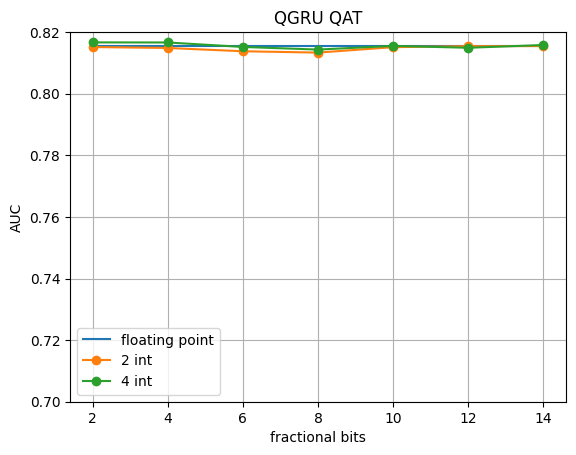

In [36]:
GRU_float = [0.8154915881472825, 0.8154915881472825, 0.8154915881472825, 0.8154915881472825, 0.8154915881472825, 0.8154915881472825, 0.8154915881472825]
plt.plot([2,4,6,8,10,12, 14], GRU_float, "-", label = "floating point")
plt.plot([2,4,6,8,10,12, 14], GRU_2int, "-o", label = '2 int')
plt.plot([2,4,6,8,10,12, 14], GRU_4int, "-o", label = '4 int')
# plt.plot([1,2,4,6,8,10,12, ], AUC, "-o", label = '6 int')
# plt.plot([1,2,4,6,8,10,12], AUC8, "-o", label = '8 int')
# plt.plot([1,2,4,6,8,10,12], AUC10, "-o", label = '10 int')

plt.legend()
plt.xlabel("fractional bits")
plt.ylabel("AUC")
plt.title("QGRU QAT")
plt.grid()
plt.ylim([0.7, 0.82]) 

## QGRU weight

In [37]:
qgru = load_model('2int_qgru_test3/2frac_qgru_weights.h5', custom_objects={'QGRU': QGRU, 'QDense': QDense, 'quantized_bits': quantized_bits, 'QActivation': QActivation})
model_save_quantized_weights(qgru, f"ptq2int2fra_weight")

... quantizing model


{'gru': {'weights': [array([[ 0.1875 ,  0.40625,  0.9375 , ..., -0.125  ,  1.5    ,  0.     ],
          [ 0.     , -0.125  ,  0.1875 , ...,  1.875  ,  1.875  , -0.0625 ],
          [ 0.9375 , -0.03125,  0.9375 , ..., -0.25   , -0.25   , -0.875  ],
          [ 0.625  , -0.1875 ,  0.125  , ...,  1.875  ,  1.875  , -0.0625 ],
          [ 0.1875 ,  0.46875,  0.125  , ...,  0.25   , -0.125  , -0.1875 ],
          [ 0.3125 , -0.34375, -0.25   , ...,  0.     ,  0.375  ,  0.125  ]],
         dtype=float32),
   array([[ 0.0625  ,  0.      , -0.125   , ..., -0.203125, -0.203125,
            0.21875 ],
          [-0.125   ,  0.125   , -0.0625  , ..., -0.046875,  0.078125,
           -0.09375 ],
          [ 0.      ,  0.0625  , -0.0625  , ..., -0.15625 ,  0.      ,
           -0.15625 ],
          ...,
          [-0.34375 ,  0.21875 , -0.0625  , ...,  0.0625  ,  0.046875,
            0.125   ],
          [-0.03125 , -0.15625 , -0.0625  , ..., -0.0625  ,  0.125   ,
            0.25    ],
         

## QLSTM

In [15]:


l1_reg = 0
l2_reg = 0

## GRU Model
#model = grumodel(15, 6, 120, [50, 10], l1_reg=l1_reg, l2_reg=l2_reg)

## LSTM Model
model = lstmmodel(15, 6, 120, [50, 10], l1_reg=l1_reg, l2_reg=l2_reg)
AUC_2int = []
int_bits = 2
for i in [2]:
    total_bits = i + int_bits + 1
    config = {
        "QLSTM":{
            "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
             "bias_quantizer" : f"quantized_bits({total_bits}, {int_bits},1)",
             "recurrent_quantizer": f"quantized_bits({total_bits},{int_bits},1)",
             "state_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
        },
        "QDense":{
            "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
            "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
        },
        "relu_0" : f"quantized_relu({total_bits},{int_bits},1)",
        "relu_1" : f"quantized_relu({total_bits},{int_bits},1)",
    }
    
    qmodel = model_quantize(model, config, total_bits, transfer_weights=True)
    
# for layer in qmodel.layers:
#         if hasattr(layer, "recurrent_quantizer"):
#             print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal), 
#                     "recurrent:", str(layer.recurrent_quantizer_internal), "state:", str(layer.state_quantizer_internal))
#         elif hasattr(layer, "kernel_quantizer"):
#             print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal))
#         elif hasattr(layer, "quantized_relu"):
#             print(layer.name, "quantized_relu:", str(layer.quantizer))
#         else:
#             print(layer.name)
                
    qmodel.summary()
    
    qmodel.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])
    
    model_output = f'{int_bits}int_qlstm_test3_notweight/{i}frac_qlstm_weights.h5'
    
    train = True
    if train:
        history = qmodel.fit(x_train, y_train,
                batch_size=2**14,
                epochs=150,
                validation_split=0.1,
                shuffle = True,
#                 sample_weight= w_train,
                callbacks = [
                    EarlyStopping(verbose=True, patience=20, monitor='val_accuracy'),
                    ModelCheckpoint(model_output, monitor='val_accuracy', verbose=True, save_best_only=True)
                    ],
                verbose=True
                )
    y_keras = qmodel.predict(x_test, batch_size=2**10)
    auc_score = roc_auc_score(y_test, y_keras)
    print("AUC score:", auc_score)
    AUC_2int.append(auc_score)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 6)]           0         
                                                                 
 lstm1 (QLSTM)               (None, 120)               60960     
                                                                 
 dense_0 (QDense)            (None, 50)                6050      
                                                                 
 relu_0 (QActivation)        (None, 50)                0         
                                                                 
 dense_1 (QDense)            (None, 10)                510       
                                                                 
 relu_1 (QActivation)        (None, 10)                0         
                                                                 
 dense_2 (QDense)            (None, 3)                 33    

Epoch 21/150
39/39 [==============================] - ETA: 0s - loss: 0.7132 - accuracy: 0.7111
Epoch 21: val_accuracy improved from 0.70742 to 0.70896, saving model to 2int_qlstm_test3_notweight\2frac_qlstm_weights.h5
39/39 [==============================] - 7s 185ms/step - loss: 0.7132 - accuracy: 0.7111 - val_loss: 0.7193 - val_accuracy: 0.7090
Epoch 22/150
39/39 [==============================] - ETA: 0s - loss: 0.7116 - accuracy: 0.7119
Epoch 22: val_accuracy improved from 0.70896 to 0.70963, saving model to 2int_qlstm_test3_notweight\2frac_qlstm_weights.h5
39/39 [==============================] - 7s 186ms/step - loss: 0.7116 - accuracy: 0.7119 - val_loss: 0.7183 - val_accuracy: 0.7096
Epoch 23/150
39/39 [==============================] - ETA: 0s - loss: 0.7105 - accuracy: 0.7125
Epoch 23: val_accuracy improved from 0.70963 to 0.71087, saving model to 2int_qlstm_test3_notweight\2frac_qlstm_weights.h5
39/39 [==============================] - 7s 188ms/step - loss: 0.7105 - accuracy:

Epoch 75/150
39/39 [==============================] - ETA: 0s - loss: 0.6761 - accuracy: 0.7281
Epoch 75: val_accuracy improved from 0.72022 to 0.72069, saving model to 2int_qlstm_test3_notweight\2frac_qlstm_weights.h5
39/39 [==============================] - 7s 183ms/step - loss: 0.6761 - accuracy: 0.7281 - val_loss: 0.6977 - val_accuracy: 0.7207
Epoch 76/150
39/39 [==============================] - ETA: 0s - loss: 0.6753 - accuracy: 0.7287
Epoch 76: val_accuracy did not improve from 0.72069
39/39 [==============================] - 7s 184ms/step - loss: 0.6753 - accuracy: 0.7287 - val_loss: 0.6982 - val_accuracy: 0.7200
Epoch 77/150
39/39 [==============================] - ETA: 0s - loss: 0.6751 - accuracy: 0.7286
Epoch 77: val_accuracy did not improve from 0.72069
39/39 [==============================] - 7s 184ms/step - loss: 0.6751 - accuracy: 0.7286 - val_loss: 0.6998 - val_accuracy: 0.7203
Epoch 78/150
39/39 [==============================] - ETA: 0s - loss: 0.6751 - accuracy: 0.7

Epoch 104/150
39/39 [==============================] - ETA: 0s - loss: 0.6662 - accuracy: 0.7322
Epoch 104: val_accuracy did not improve from 0.72121
39/39 [==============================] - 7s 186ms/step - loss: 0.6662 - accuracy: 0.7322 - val_loss: 0.6980 - val_accuracy: 0.7205
Epoch 105/150
39/39 [==============================] - ETA: 0s - loss: 0.6657 - accuracy: 0.7328
Epoch 105: val_accuracy did not improve from 0.72121
39/39 [==============================] - 7s 184ms/step - loss: 0.6657 - accuracy: 0.7328 - val_loss: 0.7012 - val_accuracy: 0.7180
Epoch 106/150
39/39 [==============================] - ETA: 0s - loss: 0.6656 - accuracy: 0.7326
Epoch 106: val_accuracy did not improve from 0.72121
39/39 [==============================] - 7s 184ms/step - loss: 0.6656 - accuracy: 0.7326 - val_loss: 0.7000 - val_accuracy: 0.7200
Epoch 107/150
39/39 [==============================] - ETA: 0s - loss: 0.6656 - accuracy: 0.7325
Epoch 107: val_accuracy did not improve from 0.72121
39/39 [

NameError: name 'x_test' is not defined

In [9]:
AUC_4int = [0.8075657360375654, 0.8087467928467528, 0.8099972878505698, 0.8080579592351906, 0.8068300154461987, 0.8073075475855531, 0.8068326358740538]

In [10]:
print(AUC_4int)

[0.8075657360375654, 0.8087467928467528, 0.8099972878505698, 0.8080579592351906, 0.8068300154461987, 0.8073075475855531, 0.8068326358740538]


In [11]:
AUC_2int = [0.8092423670870935, 0.805096025589327, 0.8058041858617452, 0.8051723112723406, 0.8069855747085065, 0.8056181357932739, 0.8075191545354666]

In [12]:
print(AUC_2int)

[0.8092423670870935, 0.805096025589327, 0.8058041858617452, 0.8051723112723406, 0.8069855747085065, 0.8056181357932739, 0.8075191545354666]


(0.7, 0.82)

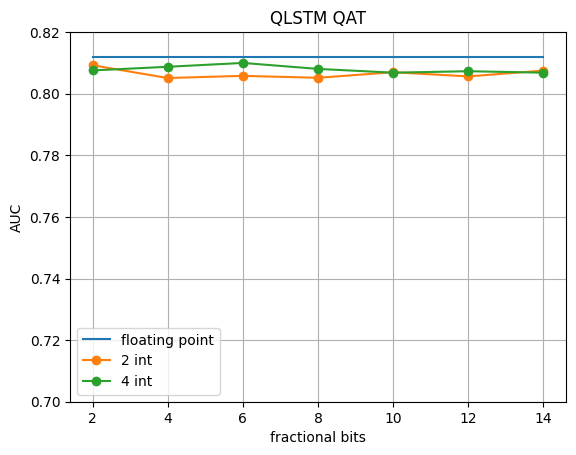

In [13]:
float_lstm = [0.8118647593083379, 0.8118647593083379, 0.8118647593083379, 0.8118647593083379, 0.8118647593083379, 0.8118647593083379, 0.8118647593083379]
plt.plot([2,4,6,8,10,12, 14], float_lstm, "-", label = "floating point")
plt.plot([2,4,6,8,10,12, 14], AUC_2int, "-o", label = '2 int')
plt.plot([2,4,6,8,10,12, 14], AUC_4int, "-o", label = '4 int')
# plt.plot([1,2,4,6,8,10,12, ], AUC, "-o", label = '6 int')
# plt.plot([1,2,4,6,8,10,12], AUC8, "-o", label = '8 int')
# plt.plot([1,2,4,6,8,10,12], AUC10, "-o", label = '10 int')

plt.legend()
plt.xlabel("fractional bits")
plt.ylabel("AUC")
plt.title("QLSTM QAT")
plt.grid()
plt.ylim([0.7, 0.82]) 

In [9]:
qmodel = load_model('2int_qlstm_test2/2frac_qlstm_weights.h5', custom_objects={'QLSTM': QLSTM, 'QDense': QDense, 'quantized_bits': quantized_bits, 'QActivation': QActivation})
model_save_quantized_weights(qmodel, f"qat2int2fra_weight")

... quantizing model


{'lstm1': {'weights': [array([[-0.125  , -1.625  ,  0.625  , ..., -0.0625 , -0.09375, -0.4375 ],
          [-0.25   ,  0.875  ,  0.6875 , ...,  0.9375 ,  0.46875, -0.0625 ],
          [ 1.125  , -0.625  , -0.25   , ...,  0.     ,  0.03125, -0.09375],
          [-0.25   , -0.25   , -0.375  , ...,  0.0625 ,  0.1875 , -0.3125 ],
          [ 0.125  ,  0.625  , -0.0625 , ..., -0.5625 ,  0.125  ,  0.3125 ],
          [-1.375  ,  0.375  ,  0.6875 , ..., -0.375  ,  0.28125,  0.0625 ]],
         dtype=float32),
   array([[-0.125  , -0.15625, -0.09375, ...,  0.03125, -0.15625,  0.0625 ],
          [ 0.03125,  0.     , -0.03125, ...,  0.09375, -0.03125, -0.09375],
          [ 0.25   , -0.03125,  0.15625, ...,  0.21875,  0.1875 , -0.0625 ],
          ...,
          [-0.0625 , -0.125  , -0.03125, ...,  0.03125,  0.15625, -0.03125],
          [-0.09375, -0.25   ,  0.09375, ...,  0.1875 , -0.15625, -0.1875 ],
          [ 0.     , -0.09375,  0.03125, ...,  0.     ,  0.     , -0.25   ]],
         dtype

## Post Training Quantization

## QLSTM

In [14]:
lstm = load_model('new_lstm/model_lstm_weights.h5')

In [22]:
PTQ2int = []
PTQ4int = []
from qkeras.utils import model_quantize
from qkeras.utils import model_save_quantized_weights
for i in [2, 4]:
    for j in [2, 4, 6, 8, 10, 12, 14]:
        int_bits = i
        total_bits = i+j+1
        config = {
            "QLSTM":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "recurrent_quantizer": f"quantized_bits({total_bits},{int_bits},1)",
                 "state_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "QDense":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "relu_0" : f"quantized_relu({total_bits},{int_bits},1)",
            "relu_1" : f"quantized_relu({total_bits},{int_bits},1)",
        }
        qmodel = model_quantize(lstm, config, total_bits, transfer_weights=True)

#         qmodel.summary()

        for layer in qmodel.layers:
            if hasattr(layer, "recurrent_quantizer"):
                print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal), 
                     "recurrent:", str(layer.recurrent_quantizer_internal), "state:", str(layer.state_quantizer_internal))
            elif hasattr(layer, "kernel_quantizer"):
                print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal))
            elif hasattr(layer, "quantized_relu"):
                print(layer.name, "quantized_relu:", str(layer.quantizer))
            else:
                print(layer.name)
                
#         model_save_quantized_weights(qmodel, f"ptq{i}int{j}fra_weight")
        y_keras = qmodel.predict(x_test, batch_size=2**10)
        auc_score = roc_auc_score(y_test, y_keras)
        print("AUC score:", auc_score)
        if i == 2:
            PTQ2int.append(auc_score)
        else:
            PTQ4int.append(auc_score)

input_1
lstm1 kernel: quantized_bits(5,2,1,alpha='auto_po2') bias: quantized_bits(5,2,1) recurrent: quantized_bits(5,2,1,alpha='auto_po2') state: quantized_bits(5,2,1)
dense_0 kernel: quantized_bits(5,2,1,alpha='auto_po2') bias: quantized_bits(5,2,1)
relu_0
dense_1 kernel: quantized_bits(5,2,1,alpha='auto_po2') bias: quantized_bits(5,2,1)
relu_1
dense_2 kernel: quantized_bits(5,2,1,alpha='auto_po2') bias: quantized_bits(5,2,1)
output_softmax
294/294 [==============================] - 16s 50ms/step
AUC score: 0.7697456491241724
input_1
lstm1 kernel: quantized_bits(7,2,1,alpha='auto_po2') bias: quantized_bits(7,2,1) recurrent: quantized_bits(7,2,1,alpha='auto_po2') state: quantized_bits(7,2,1)
dense_0 kernel: quantized_bits(7,2,1,alpha='auto_po2') bias: quantized_bits(7,2,1)
relu_0
dense_1 kernel: quantized_bits(7,2,1,alpha='auto_po2') bias: quantized_bits(7,2,1)
relu_1
dense_2 kernel: quantized_bits(7,2,1,alpha='auto_po2') bias: quantized_bits(7,2,1)
output_softmax
294/294 [============

In [18]:
PTQ_2int = [0.7138402385262174, 0.7697426759545337, 0.795030969988355, 0.7959740415614672, 0.7965695165044027, 0.7965597107777665, 0.796992236571457]

In [19]:
PTQ_4int = [0.7204539145373472, 0.7788773707089733, 0.7948387248147831, 0.7965026440227403, 0.7993372082142057, 0.7999884160098358, 0.8001326665853764]

In [24]:
print(PTQ2int)

[0.7697456491241724, 0.7950334429664642, 0.7962076821540339, 0.7965694400474576, 0.7965596510581459, 0.7969792420735934, 0.7971674337337867]


In [25]:
print(PTQ4int)

[0.778671831721396, 0.7946760751838718, 0.7966748955925538, 0.7977211569496075, 0.7976043675022462, 0.7993241590003554, 0.7999746037087557]


(0.7, 0.82)

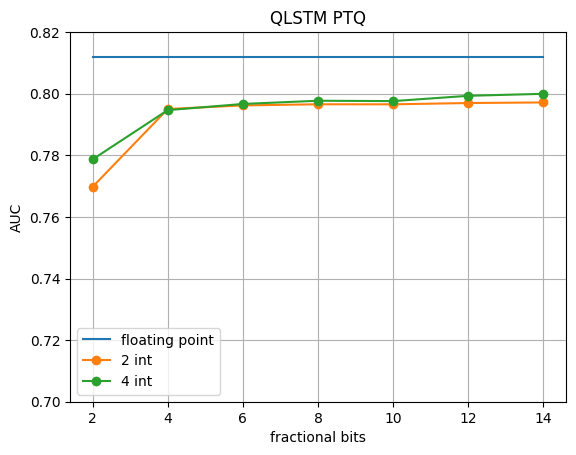

In [26]:
float_lstm = [0.8118647593083379, 0.8118647593083379, 0.8118647593083379, 0.8118647593083379, 0.8118647593083379, 0.8118647593083379, 0.8118647593083379]
plt.plot([2,4,6,8,10,12,14], float_lstm, "-", label = "floating point")
plt.plot([2,4,6,8,10,12,14], PTQ2int, "-o", label = '2 int')
plt.plot([2,4,6,8,10,12,14], PTQ4int, "-o", label = '4 int')
# plt.plot([1,2,4,6,8,10,12, ], AUC, "-o", label = '6 int')
# plt.plot([1,2,4,6,8,10,12], AUC8, "-o", label = '8 int')
# plt.plot([1,2,4,6,8,10,12], AUC10, "-o", label = '10 int')

plt.legend()
plt.xlabel("fractional bits")
plt.ylabel("AUC")
plt.title("QLSTM PTQ")
plt.grid()
plt.ylim([0.7, 0.82]) 

## QGRU

In [40]:
gru = load_model('gru_test3/gru_weights.h5')

In [41]:
PTQ2intgru = []
PTQ4intgru = []
from qkeras.utils import model_quantize
from qkeras.utils import model_save_quantized_weights
for i in [2, 4]:
    for j in [2, 4, 6, 8, 10, 12, 14]:
        int_bits = i
        total_bits = i+j+1
        config = {
            "QGRU":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                 "recurrent_quantizer": f"quantized_bits({total_bits},{int_bits},1)",
                 "state_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "QDense":{
                "kernel_quantizer" : f"quantized_bits({total_bits},{int_bits},1)",
                "bias_quantizer" : f"quantized_bits({total_bits},{int_bits},1)"
            },
            "relu_0" : f"quantized_relu({total_bits},{int_bits},1)",
            "relu_1" : f"quantized_relu({total_bits},{int_bits},1)",
        }
        qmodel = model_quantize(gru, config, total_bits, transfer_weights=True)

#         qmodel.summary()

        for layer in qmodel.layers:
            if hasattr(layer, "recurrent_quantizer"):
                print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal), 
                     "recurrent:", str(layer.recurrent_quantizer_internal), "state:", str(layer.state_quantizer_internal))
            elif hasattr(layer, "kernel_quantizer"):
                print(layer.name, "kernel:", str(layer.kernel_quantizer_internal), "bias:", str(layer.bias_quantizer_internal))
            elif hasattr(layer, "quantized_relu"):
                print(layer.name, "quantized_relu:", str(layer.quantizer))
            else:
                print(layer.name)
                
#         model_save_quantized_weights(qmodel, f"ptq{i}int{j}fra_weight")
        y_keras = qmodel.predict(x_test, batch_size=2**10)
        auc_score = roc_auc_score(y_test, y_keras)
        print("AUC score:", auc_score)
        if i == 2:
            PTQ2intgru.append(auc_score)
        else:
            PTQ4intgru.append(auc_score)

input_1
gru kernel: quantized_bits(5,2,1,alpha='auto_po2') bias: quantized_bits(5,2,1) recurrent: quantized_bits(5,2,1,alpha='auto_po2') state: quantized_bits(5,2,1)
dense_0 kernel: quantized_bits(5,2,1,alpha='auto_po2') bias: quantized_bits(5,2,1)
relu_0
dense_1 kernel: quantized_bits(5,2,1,alpha='auto_po2') bias: quantized_bits(5,2,1)
relu_1
dense_2 kernel: quantized_bits(5,2,1,alpha='auto_po2') bias: quantized_bits(5,2,1)
output_softmax
294/294 [==============================] - 15s 47ms/step
AUC score: 0.756710119543415
input_1
gru kernel: quantized_bits(7,2,1,alpha='auto_po2') bias: quantized_bits(7,2,1) recurrent: quantized_bits(7,2,1,alpha='auto_po2') state: quantized_bits(7,2,1)
dense_0 kernel: quantized_bits(7,2,1,alpha='auto_po2') bias: quantized_bits(7,2,1)
relu_0
dense_1 kernel: quantized_bits(7,2,1,alpha='auto_po2') bias: quantized_bits(7,2,1)
relu_1
dense_2 kernel: quantized_bits(7,2,1,alpha='auto_po2') bias: quantized_bits(7,2,1)
output_softmax
294/294 [=================

(0.7, 0.82)

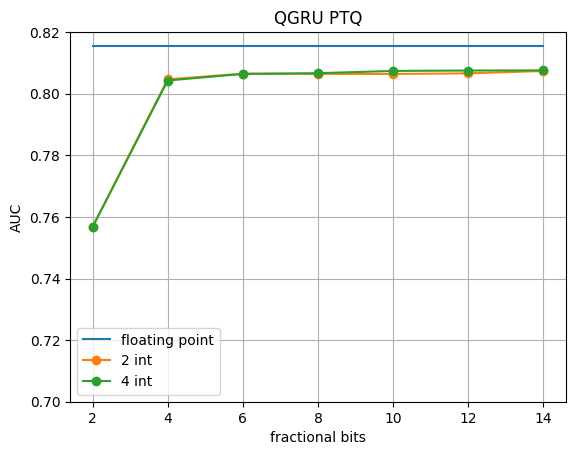

In [42]:
GRU_float = [0.8154915881472825, 0.8154915881472825, 0.8154915881472825, 0.8154915881472825, 0.8154915881472825, 0.8154915881472825, 0.8154915881472825]
plt.plot([2,4,6,8,10,12,14], GRU_float, "-", label = "floating point")
plt.plot([2,4,6,8,10,12,14], PTQ2intgru, "-o", label = '2 int')
plt.plot([2,4,6,8,10,12,14], PTQ4intgru, "-o", label = '4 int')
# plt.plot([1,2,4,6,8,10,12, ], AUC, "-o", label = '6 int')
# plt.plot([1,2,4,6,8,10,12], AUC8, "-o", label = '8 int')
# plt.plot([1,2,4,6,8,10,12], AUC10, "-o", label = '10 int')

plt.legend()
plt.xlabel("fractional bits")
plt.ylabel("AUC")
plt.title("QGRU PTQ")
plt.grid()
plt.ylim([0.7, 0.82])

## Check AUC detail 

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False, 
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    cbar = plt.colorbar()
    plt.clim(0,1)
    cbar.set_label(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    #plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plotRoc(y, predict_test, linestyle, legend=True):
    
    labels = ['b vs l (pb/pl)', 'b vs c (pb/pc)']
    
    pb_b = predict_test[:,0] [y[:,0] == 1]
    pc_b = predict_test[:,1] [y[:,0] == 1]
    pl_b = predict_test[:,2] [y[:,0] == 1]
    
    pc_c = predict_test[:,1] [y[:,1] == 1]
    pb_c = predict_test[:,0] [y[:,1] == 1]
    
    pl_l = predict_test[:,2] [y[:,2] == 1]
    pb_l = predict_test[:,0] [y[:,2] == 1]
    
    hist_b_bvl = np.histogram( pb_b/(pb_b+pl_b), range=(0,1), bins=100000 )
    hist_l_bvl = np.histogram( pb_l/(pb_l+pl_l), range=(0,1), bins=100000 )

    hist_b_bvc = np.histogram( pb_b/(pb_b+pc_b), range=(0,1), bins=100000 )
    hist_c_bvc = np.histogram( pb_c/(pb_c+pc_c), range=(0,1), bins=100000 )

    hist_b_bvl_eff = hist_b_bvl[0][::-1].cumsum()[::-1]/hist_b_bvl[0].sum()
    hist_l_bvl_eff = hist_l_bvl[0][::-1].cumsum()[::-1]/hist_l_bvl[0].sum()
    
    hist_b_bvc_eff = hist_b_bvc[0][::-1].cumsum()[::-1]/hist_b_bvc[0].sum()
    hist_c_bvc_eff = hist_c_bvc[0][::-1].cumsum()[::-1]/hist_c_bvc[0].sum()
    
    auc_bvl = auc(hist_l_bvl_eff, hist_b_bvl_eff)
    auc_bvc = auc(hist_c_bvc_eff, hist_b_bvc_eff)
    
    plt.plot( hist_b_bvl_eff, hist_l_bvl_eff, label=f'b vs l (pb/pl), AUC = {auc_bvl:.2f}', linestyle=linestyle )
    plt.plot( hist_b_bvc_eff, hist_c_bvc_eff, label=f'b vs c (pb/pc), AUC = {auc_bvc:.2f}', linestyle=linestyle )
    
    plt.semilogy()
    plt.xlabel("b-Jet Efficiency")
    plt.ylabel("Background Efficiency")
    plt.ylim(0.001,1)
    plt.grid(True)
    if legend: plt.legend(loc='upper left')
    plt.figtext(0.25, 0.90,'hls4ml',fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)

def rocData(y, predict_test):
    
    labels = ['b vs l (pb/pl)', 'b vs c (pb/pc)']
    
    pb_b = predict_test[:,0] [y[:,0] == 1]
    pc_b = predict_test[:,1] [y[:,0] == 1]
    pl_b = predict_test[:,2] [y[:,0] == 1]
    
    pc_c = predict_test[:,1] [y[:,1] == 1]
    pb_c = predict_test[:,0] [y[:,1] == 1]
    
    pl_l = predict_test[:,2] [y[:,2] == 1]
    pb_l = predict_test[:,0] [y[:,2] == 1]
    
    
    hist_b_bvl = np.histogram( pb_b/(pb_b+pl_b), range=(0,1), bins=1000 )
    hist_l_bvl = np.histogram( pb_l/(pb_l+pl_l), range=(0,1), bins=1000 )

    hist_b_cvl = np.histogram( pb_b/(pb_b+pc_b), range=(0,1), bins=1000 )
    hist_c_cvl = np.histogram( pb_c/(pb_c+pc_c), range=(0,1), bins=1000 )

    hist_b_bvl_eff = hist_b_bvl.cumsum()/hist_b_bvl.sum()
    hist_l_bvl_eff = hist_l_bvl.cumsum()/hist_l_bvl.sum()
    
    hist_b_cvl_eff = hist_b_cvl.cumsum()/hist_b_cvl.sum()
    hist_c_cvl_eff = hist_c_cvl.cumsum()/hist_c_cvl.sum()

    df = pd.DataFrame()

    fpr = {}
    tpr = {}
    auc1 = {}

    for i, label in enumerate(labels):
        df[label] = y[:,i]
        df[label + '_pred'] = predict_test[:,i]

        fpr[label], tpr[label], threshold = roc_curve(df[label],df[label+'_pred'])

        auc1[label] = auc(fpr[label], tpr[label])
    return effs, auc1

def makeRoc(y, predict_test, linestyle='-', legend=True):
      
    plotRoc(y, predict_test, linestyle, legend)
    
#     effs, auc1 = rocData(y, predict_test, labels)
#     plotRoc(fpr, tpr, auc1, labels, linestyle, legend=legend)
#     return predict_test

def print_dict(d, indent=0):
    align=20
    for key, value in d.items():
        print('  ' * indent + str(key), end='')
        if isinstance(value, dict):
            print()
            print_dict(value, indent+1)
        else:
            print(':' + ' ' * (20 - len(key) - 2 * indent) + str(value))

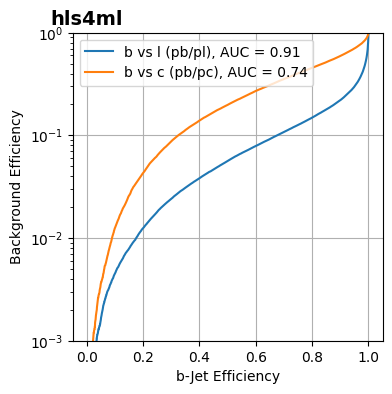

In [39]:
plt.figure(figsize=(4,4))
_ = makeRoc(y_test, y_keras)